## Lim Jin Ming, Jeremy Denzel - A0172720M
## Sung Zheng Jie - A0168188M

# Qns 8 Open ended Tuning Problem

8. Your manager has given you a task of tuning a model that could be operationalized for predicting loan defaults. He has asked you to use the given full dataset and has left it up to you to decide how to use it. Your job is therefore to come out with a model that can generalize well, hence overfitting to data is of concern as the dataset is relatively small. 

### (a) (3 points) Describe your validation and testing procedure, noting down what techniques worked for you and what did not. Tabulate any results across the different tuning attempts and note down the various techniques you tried (e.g. feature engineering, different base models etc) in a separate column. 

### (b) (3 points) Also discuss any insights you may uncovered while tuning the models (what parameters made the most difference for which models, etc)

In [1]:
import warnings
warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
from lightgbm import LGBMClassifier

from math import sqrt, log
from copy import deepcopy
from collections import defaultdict

from xgboost import XGBClassifier

# Import libraries
from sklearn import datasets
from sklearn.model_selection import (train_test_split,
                                     StratifiedKFold
                                    )
from sklearn.metrics import (accuracy_score, 
                             f1_score, 
                             precision_score, 
                             recall_score, 
                             classification_report, 
                             confusion_matrix, 
                             roc_curve, 
                             auc, 
                             matthews_corrcoef,
                             roc_auc_score
                            )


from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as make_pipeline_imb, Pipeline

from sklearn.ensemble import AdaBoostClassifier,ExtraTreesClassifier
from sklearn import tree, manifold, datasets
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans
from sklearn.naive_bayes import GaussianNB,BernoulliNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import validation_curve
from sklearn.feature_selection import SelectKBest, chi2, f_classif

from sklearn.decomposition import PCA

from hyperopt import hp
from hyperopt.pyll import scope
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

sns.set_style(style="whitegrid")
%matplotlib inline

Using TensorFlow backend.


In [3]:
import plotly.offline as py
import plotly.graph_objs as go

py.offline.init_notebook_mode(connected=True)

In [4]:
colormap = plt.cm.RdBu

## 1. Data Overview

In [5]:
# read in the data as a pandas dataframe
loans = pd.read_csv("Data/Assignment2Data.csv")
loans.head()

acc_now_delinq  acc_open_past_24mths  all_util  annual_inc  avg_cur_bal  \
0             0.0                   3.0       1.0     52000.0      25099.0   
1             0.0                   2.0      47.0     55000.0       2222.0   
2             0.0                   3.0      86.0     51000.0       4541.0   
3             0.0                   2.0      41.0     62000.0      18520.0   
4             0.0                  11.0      60.0     30000.0       5990.0   

   bc_open_to_buy  bc_util  chargeoff_within_12_mths  \
0         30359.0      0.5                       0.0   
1         10551.0     52.0                       0.0   
2          2498.0      0.1                       0.0   
3         18310.0     51.2                       0.0   
4          7898.0      7.1                       0.0   

   collections_12_mths_ex_med  delinq_amnt  ...  total_cu_tl  \
0                         0.0          0.0  ...          2.0   
1                         0.0          0.0  ...          1.0   
2                         0.0          0.0  ...          0.0   
3                         0.0          0.0  ...          0.0   
4                         0.0          0.0  ...          5.0   

   total_il_high_credit_limit   total_pymnt  total_pymnt_inv  total_rec_int  \
0                         0.0   3011.577285          3011.58          11.58   
1                     27751.0   5013.306667          5013.31          13.31   
2                     24001.0   1032.903619          1032.90          32.90   
3                     21976.0  20009.805556         19984.79           9.81   
4                     62319.0  24334.736554         24334.74         334.74   

   total_rec_late_fee  total_rec_prncp  total_rev_hi_lim  delinq_2yrs  \
0                 0.0           3000.0           31000.0          0.0   
1                 0.0           5000.0           33800.0          0.0   
2                 0.0           1000.0            2500.0          0.0   
3                 0.0          20000.0           39500.0          0.0   
4                 0.0          24000.0           12000.0          0.0   

   bad_loans  
0          0  
1          0  
2          0  
3          0  
4          0  

[5 rows x 71 columns]

In [6]:
print ("\033[1m" + "Rows     : " +  "\033[0m", loans.shape[0])
print ("\033[1m" + "Columns  : " + "\033[0m", loans.shape[1])
print ("\033[1m" + "\nColumn Names : \n" + "\033[0m", loans.columns.tolist())

Rows     :  2992
Columns  :  71

Column Names : 
 ['acc_now_delinq', 'acc_open_past_24mths', 'all_util', 'annual_inc', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'collections_12_mths_ex_med', 'delinq_amnt', 'dti', 'inq_fi', 'inq_last_12m', 'inq_last_6mths', 'installment', 'int_rate', 'last_pymnt_amnt', 'loan_amnt', 'max_bal_bc', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_last_delinq', 'mths_since_rcnt_il', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'open_acc', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 'open_rv_12m', 'open_rv_24m', 'out_prncp', 'out_prncp_inv', 'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'pub_rec_bankruptcies', 'revol_bal', 'revol_util', 'tax_liens', 'tot_coll_amt', 'tot_cur_

In [7]:
# see the data types
loans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2992 entries, 0 to 2991
Data columns (total 71 columns):
acc_now_delinq                2992 non-null float64
acc_open_past_24mths          2992 non-null float64
all_util                      2992 non-null float64
annual_inc                    2992 non-null float64
avg_cur_bal                   2992 non-null float64
bc_open_to_buy                2992 non-null float64
bc_util                       2992 non-null float64
chargeoff_within_12_mths      2992 non-null float64
collections_12_mths_ex_med    2992 non-null float64
delinq_amnt                   2992 non-null float64
dti                           2992 non-null float64
inq_fi                        2992 non-null float64
inq_last_12m                  2992 non-null float64
inq_last_6mths                2992 non-null float64
installment                   2992 non-null float64
int_rate                      2992 non-null float64
last_pymnt_amnt               2992 non-null float64
loan_amnt

Hence, all features are numeric.

## 2. Data Cleaning

In [8]:
missing_values = loans.isna().sum()
counter = 0
for val in missing_values:
    if val > 0:
        counter += 0
print(counter)

0


**Observation:**
There are no missing values.

## 3. Exploratory Data Analysis

In [9]:
loans_viz = deepcopy(loans) # maintain a loans_viz dataframe purely for EDA and visualisations

### 3.1 Overall Bad Loans Rate

In [10]:
loans_viz["bad_loans"].value_counts()

0    2516
1     476
Name: bad_loans, dtype: int64

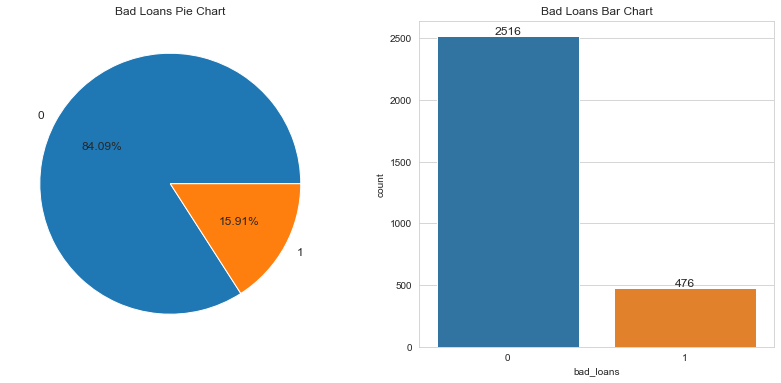

In [11]:
# Pie Chart showing percentages
plt.figure(figsize=(14,6))
plt.subplot(121)
loans_viz["bad_loans"].value_counts().plot.pie(autopct  = "%.2f%%", fontsize=12)
plt.title("Bad Loans Pie Chart")
plt.ylabel("")

# Bar Chart Raw Number
plt.subplot(122)
ax = sns.countplot(x="bad_loans", data=loans_viz)
for i, j in enumerate(loans["bad_loans"].value_counts().values):
    ax.annotate(str(j), (i, j), ha="center", va="bottom", fontsize=12)

plt.title("Bad Loans Bar Chart")
plt.show()

In [12]:
cols = list(loans_viz.columns)
cols.remove('bad_loans')

### 3.2 Analyse the distribution of the variable by class

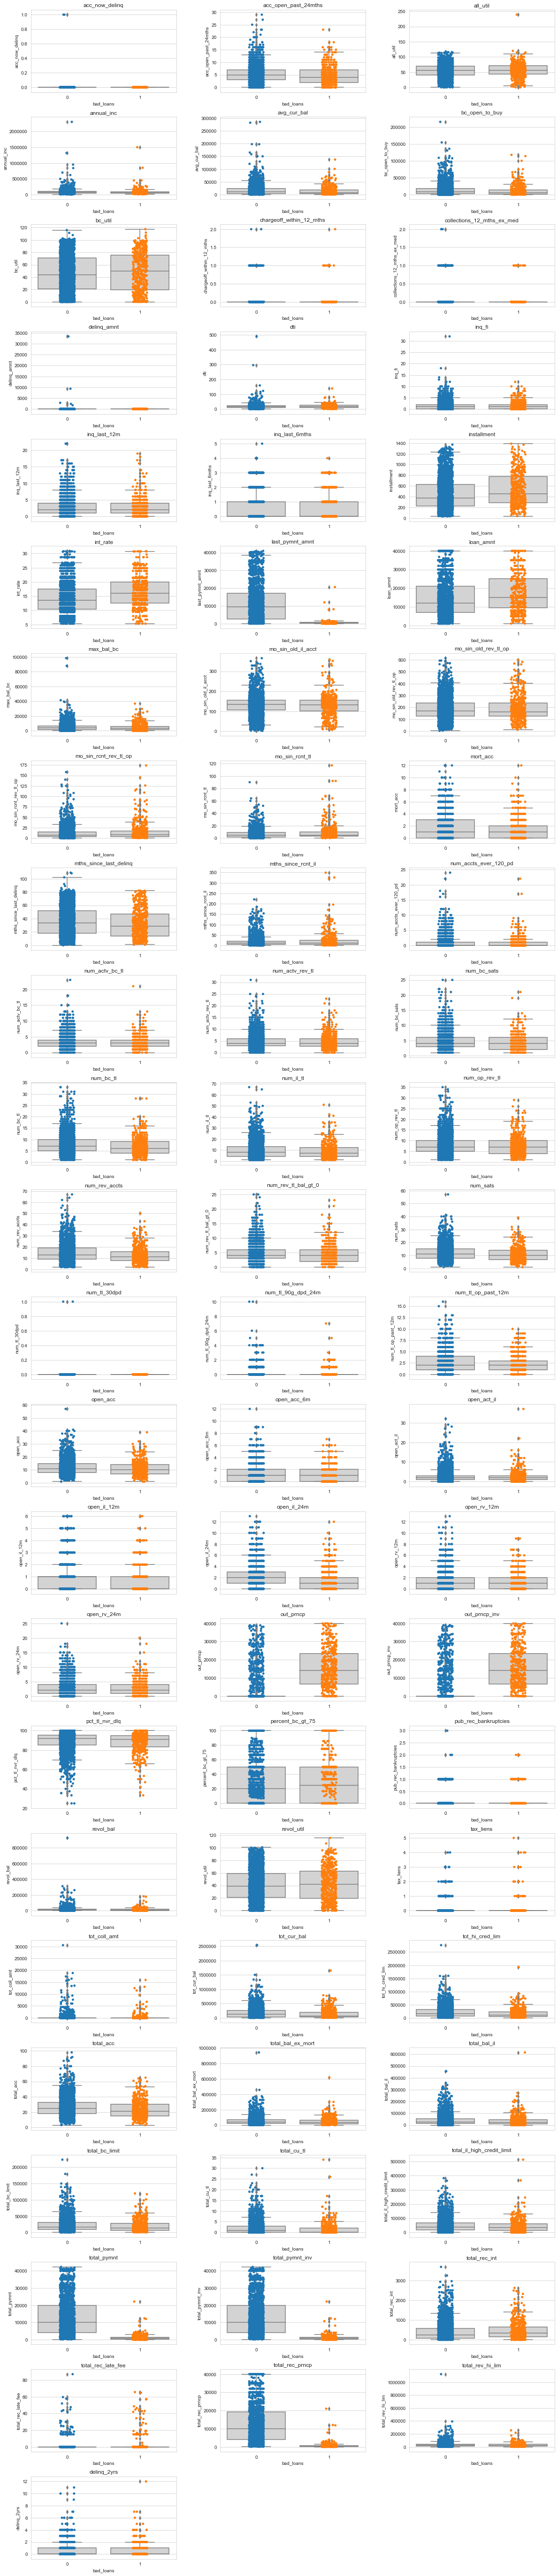

In [13]:
fig = plt.figure(constrained_layout=False, figsize=(20,100))
spec = fig.add_gridspec(24, 3, wspace=0.3, hspace=0.3)

for i in range(len(cols)):
    axes = fig.add_subplot(spec[i])
    sns.boxplot(x=loans_viz["bad_loans"],y=loans_viz[cols[i]],ax=axes,color='lightgray')
    sns.stripplot(x=loans_viz["bad_loans"],y=loans_viz[cols[i]],ax=axes)
    fig.add_subplot(axes)
    axes.title.set_text(cols[i])

fig.show()

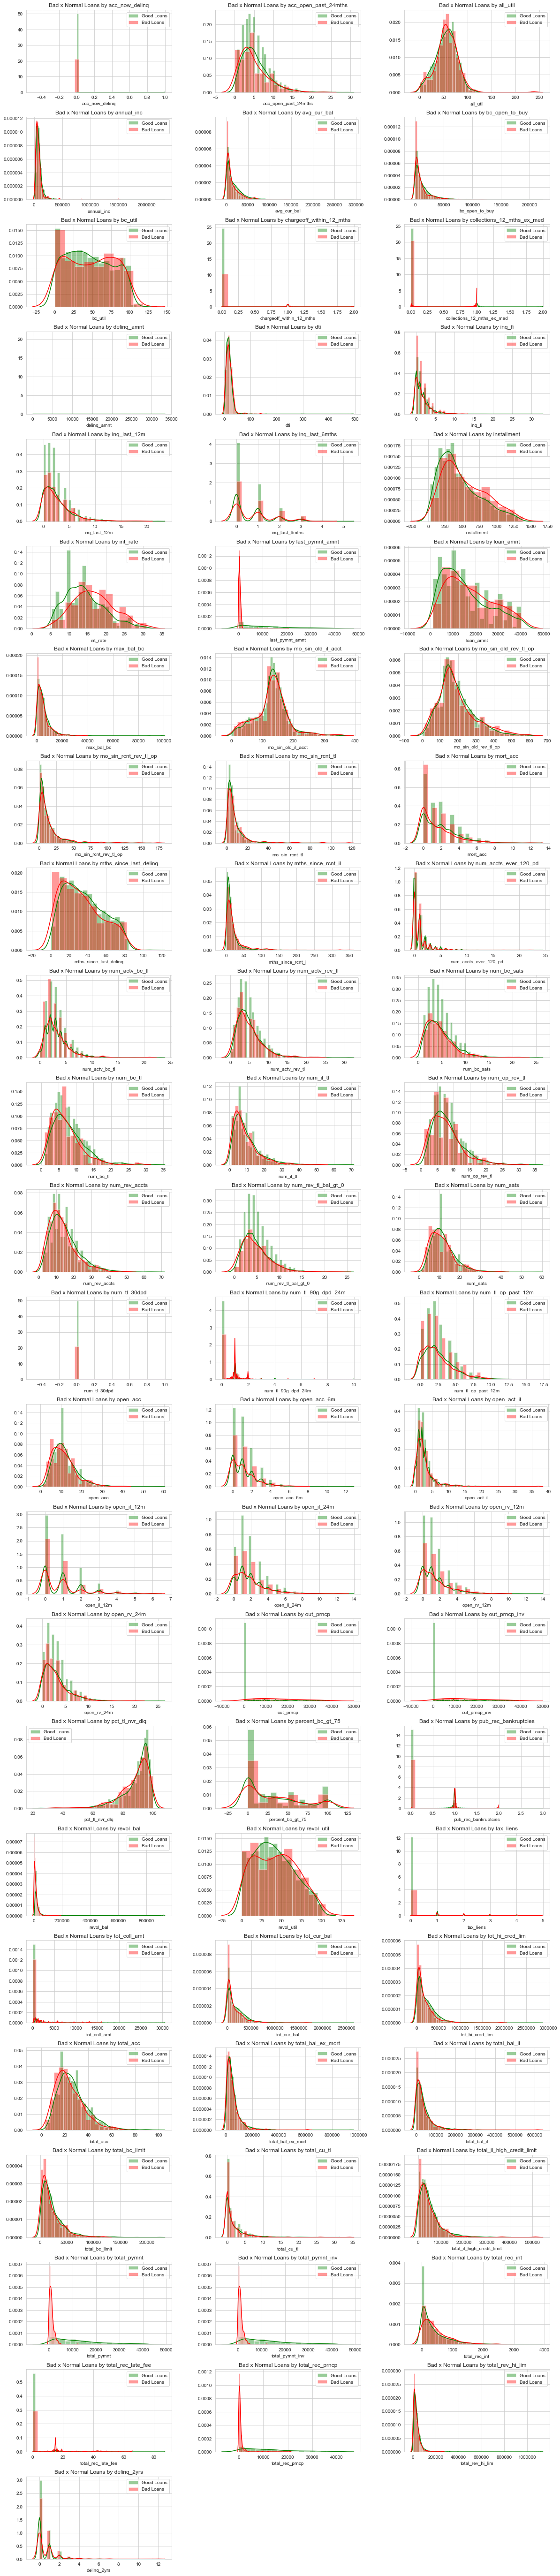

In [14]:
fig = plt.figure(constrained_layout=False, figsize=(20,100))
spec = fig.add_gridspec(24, 3, wspace=0.3, hspace=0.3)

for i in range(len(cols)):
    axes = fig.add_subplot(spec[i])
    sns.distplot(loans_viz[loans_viz['bad_loans'] == 0][cols[i]], 
             color='g', label="Good Loans")
    sns.distplot(loans_viz[loans_viz['bad_loans'] == 1][cols[i]], 
                 color='r', label="Bad Loans")
    fig.add_subplot(axes)
    axes.title.set_text('Bad x Normal Loans by {}'.format(cols[i]))
    plt.legend(prop={'size': 10})

fig.show()

**Observation:** There are some features which distinctly separates the class (bad and normal loans). We belive these features will be more statistically significant.  

### 3.3 Analysis by Income Category:

- **Low income category:** Borrowers that have an annual income lower or equal to 100,000 usd.
- **Medium income category:** Borrowers that have an annual income higher than 100,000 usd but lower or equal to 200,000 usd.
- **High income category:** Borrowers that have an annual income higher than 200,000 usd.

**Summary:**
- Borrowers that made part of the **high income category** took higher loan amounts than people from **low** and **medium income categories.** People with higher annual incomes are more likely to pay loans with a higher amount.
- Borrowers with a lower income had on average **higher interest rates** while people with a higher annual income had **lower interest rates** on their loans.

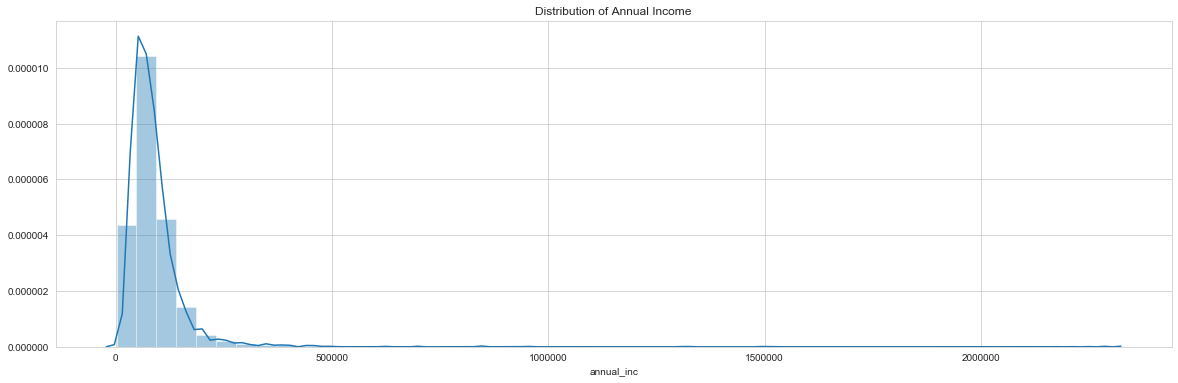

In [15]:
fig = plt.figure(constrained_layout=False, figsize=(20,6))
sns.distplot(loans_viz.annual_inc)
plt.title('Distribution of Annual Income')
fig.show()

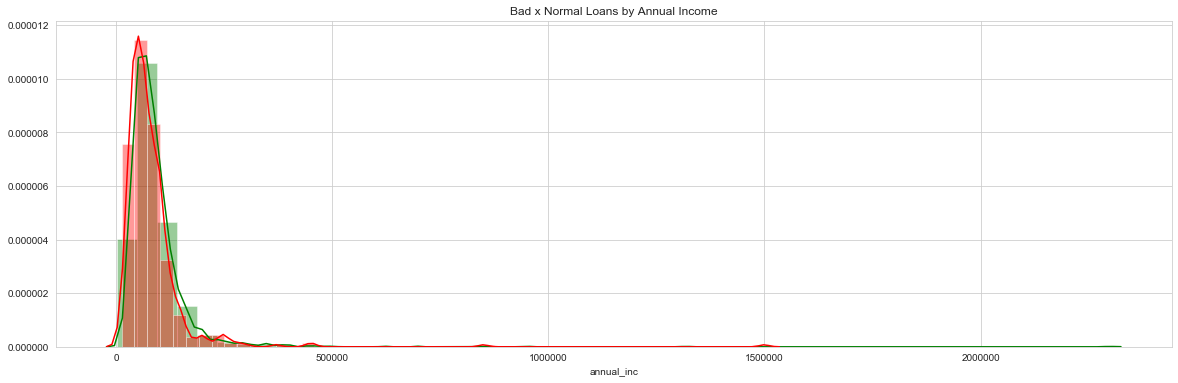

In [16]:
fig = plt.figure(constrained_layout=False, figsize=(20,6))
sns.distplot(loans_viz[loans_viz['bad_loans'] == 0]["annual_inc"], 
             color='g', label="Good Loans")
sns.distplot(loans_viz[loans_viz['bad_loans'] == 1]["annual_inc"], 
             color='r', label="Bad Loans")
plt.title('Bad x Normal Loans by Annual Income')
fig.show()

In [17]:
def categorise_income(income):
    if income > 200000:
        return "High"
    elif income > 100000:
        return "Medium"
    else:
        return "Low"

In [18]:
loans_viz["income_category"] = loans_viz.annual_inc.apply(categorise_income)

In [19]:
loans_viz.income_category.value_counts()

Low       2237
Medium     655
High       100
Name: income_category, dtype: int64

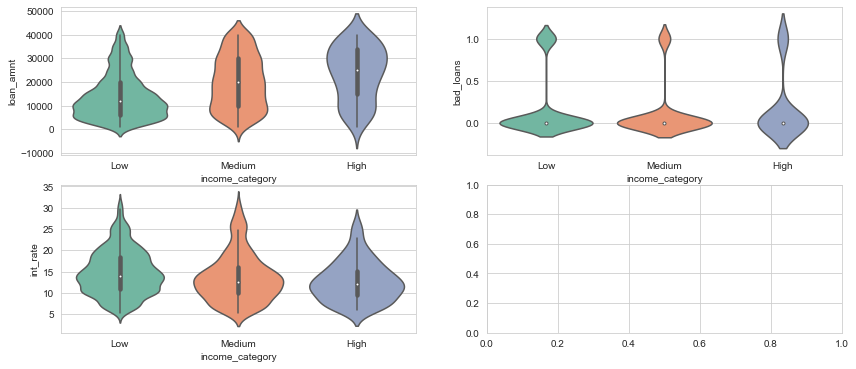

In [20]:
fig, ((ax1, ax2), (ax3, ax4))= plt.subplots(nrows=2, ncols=2, figsize=(14,6))

# Change the Palette types tomorrow!

sns.violinplot(x="income_category", y="loan_amnt", data=loans_viz, palette="Set2", ax=ax1 )
sns.violinplot(x="income_category", y="bad_loans", data=loans_viz, palette="Set2", ax=ax2)
sns.violinplot(x="income_category", y="int_rate", data=loans_viz, palette="Set2", ax=ax3)

**Observation**: The higher the income, the higher the loan amount. The higher the income, the lower the interest rate. 

In [21]:
income_bad =  loans_viz[loans_viz["bad_loans"] == 1]["income_category"].value_counts().reset_index()
income_bad.columns = ["income_category", "count"]

income_good =  loans_viz[loans_viz["bad_loans"] == 0]["income_category"].value_counts().reset_index()
income_good.columns = ["income_category", "count"]

In [22]:
# bar - bad loans
trace1 = go.Bar(x = income_bad["income_category"]  , y = income_bad["count"],
                name = "Customers with Bad Loans",
                marker = dict(line = dict(width = .5,color = "black")),
                opacity = .9)

# bar - good loans
trace2 = go.Bar(x = income_good["income_category"] , y = income_good["count"],
                name = "Customers with Good Loans",
                marker = dict(line = dict(width = .5,color = "black")),
                opacity = .9)

layout = go.Layout(dict(title = "Bad Loans by Income Category",
                        plot_bgcolor  = "rgb(243,243,243)",paper_bgcolor = "rgb(243,243,243)",
                        xaxis = dict(gridcolor = 'rgb(255, 255, 255)',title = "Income Category",
                                     zerolinewidth=1,ticklen=5,gridwidth=2),
                        yaxis = dict(gridcolor = 'rgb(255, 255, 255)',title = "count",
                                     zerolinewidth=1,ticklen=5,gridwidth=2),
                       )
                  )
data = [trace2,trace1]
fig  = go.Figure(data=data,layout=layout)
py.iplot(fig)

**Observation:** There are more customers with bad loans in the low income category as compared to the other categories. However, this may not be reflected when comparing the proportion of the bad loans in each income category. 

In [23]:
loans_viz["bad_loans"] = loans_viz["bad_loans"].map(lambda x : "Yes" if x == 1 else "No")

<Figure size 1296x864 with 0 Axes>

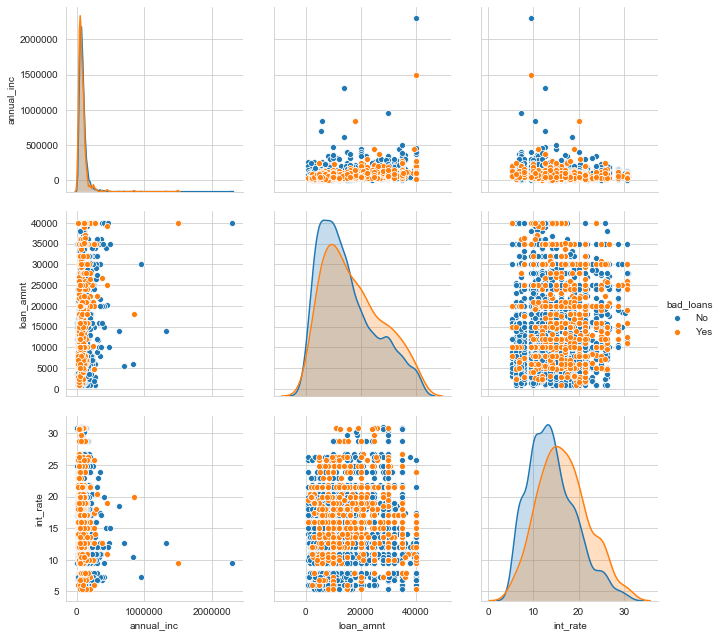

In [24]:
plt.figure(figsize=(18,12))
features = ['annual_inc','loan_amnt','int_rate','bad_loans']
sns.pairplot(loans_viz[features],hue="bad_loans",height=3)
plt.show()

**Observation:** There is no clear pairwise correlation among the loan_amount, int_rate and annual_income. Nonetheless, we can see a clear separation in classes (bad and normal loans) when analysing the relation between loan_amnt and annual_inc as well as int_rate and annual_inc. This is due to the fact that there are more bad loans in the lower income group.

In [25]:
loans_viz["int_rate"].describe()

count    2992.000000
mean       14.588252
std         5.385267
min         5.310000
25%        10.420000
50%        14.070000
75%        18.060000
max        30.940000
Name: int_rate, dtype: float64

In [26]:
# Average interest is 14.59%. Anything above this will be considered of high risk. Let's see if this is true.
loans_viz["int_rate_type"] = loans_viz["int_rate"].map(lambda x: "Low" if x <= np.mean(loans_viz.int_rate) else "High")

In [27]:
loans_viz.head()

acc_now_delinq  acc_open_past_24mths  all_util  annual_inc  avg_cur_bal  \
0             0.0                   3.0       1.0     52000.0      25099.0   
1             0.0                   2.0      47.0     55000.0       2222.0   
2             0.0                   3.0      86.0     51000.0       4541.0   
3             0.0                   2.0      41.0     62000.0      18520.0   
4             0.0                  11.0      60.0     30000.0       5990.0   

   bc_open_to_buy  bc_util  chargeoff_within_12_mths  \
0         30359.0      0.5                       0.0   
1         10551.0     52.0                       0.0   
2          2498.0      0.1                       0.0   
3         18310.0     51.2                       0.0   
4          7898.0      7.1                       0.0   

   collections_12_mths_ex_med  delinq_amnt  ...   total_pymnt  \
0                         0.0          0.0  ...   3011.577285   
1                         0.0          0.0  ...   5013.306667   
2                         0.0          0.0  ...   1032.903619   
3                         0.0          0.0  ...  20009.805556   
4                         0.0          0.0  ...  24334.736554   

   total_pymnt_inv  total_rec_int  total_rec_late_fee  total_rec_prncp  \
0          3011.58          11.58                 0.0           3000.0   
1          5013.31          13.31                 0.0           5000.0   
2          1032.90          32.90                 0.0           1000.0   
3         19984.79           9.81                 0.0          20000.0   
4         24334.74         334.74                 0.0          24000.0   

   total_rev_hi_lim  delinq_2yrs  bad_loans  income_category  int_rate_type  
0           31000.0          0.0         No              Low            Low  
1           33800.0          0.0         No              Low            Low  
2            2500.0          0.0         No              Low           High  
3           39500.0          0.0         No              Low            Low  
4           12000.0          0.0         No              Low           High  

[5 rows x 73 columns]

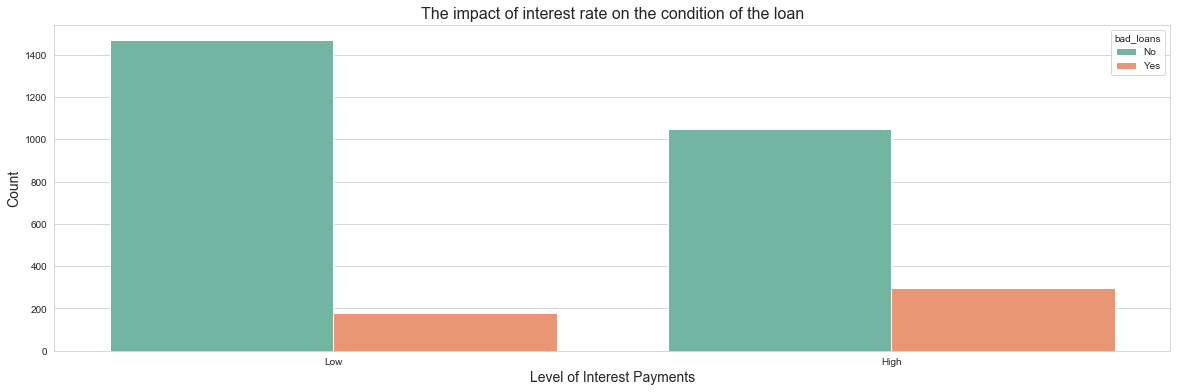

In [28]:
plt.figure(figsize=(20,6))

ax = sns.countplot(x='int_rate_type', data=loans_viz, 
                  palette="Set2", hue='bad_loans')

ax.set_title('The impact of interest rate on the condition of the loan', fontsize=16)
ax.set_xlabel('Level of Interest Payments', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
plt.show()

**Observation:** Loans that have a **high interest rate** are more likely to default.

### 3.4 Analysis by Correlation of Numerical Variables

In [29]:
# We will use df_correlations dataframe to analyze our correlations.
df_correlations = loans_viz[[i for i in loans_viz.columns if i not in ["bad_loans", "income_category"]]].corr()


trace = go.Heatmap(z=df_correlations.values,
                   x=df_correlations.columns,
                   y=df_correlations.columns,
                   colorscale=[[0.0, 'rgb(165,0,38)'], 
                               [0.1111111111111111, 'rgb(215,48,39)'], 
                               [0.2222222222222222, 'rgb(244,109,67)'], 
                               [0.3333333333333333, 'rgb(253,174,97)'], 
                               [0.4444444444444444, 'rgb(254,224,144)'], 
                               [0.5555555555555556, 'rgb(224,243,248)'], 
                               [0.6666666666666666, 'rgb(171,217,233)'], 
                               [0.7777777777777778, 'rgb(116,173,209)'], 
                               [0.8888888888888888, 'rgb(69,117,180)'], 
                               [1.0, 'rgb(49,54,149)']
                              ],
                   
                   colorbar = dict(title = 'Level of Correlation',
                                   titleside = 'top',
                                   tickmode = 'array',
                                   tickvals = [-0.52,0.2,0.95],
                                   ticktext = ['Negative Correlation','Low Correlation','Positive Correlation'],
                                   ticks = 'outside'
                                  )
                  )


layout = {"title": "Correlation Heatmap"}
data=[trace]

fig = dict(data=data, layout=layout)
py.iplot(fig)

**Observation:** It is difficult to analyse the correlation of all 70 variables. Instead, we will look at the correlation heatmap of the more significant features later on in the notebook.

## 4. Dataset Preparation
- Train-Test Split
- Standardisation

In [30]:
loans.head()

acc_now_delinq  acc_open_past_24mths  all_util  annual_inc  avg_cur_bal  \
0             0.0                   3.0       1.0     52000.0      25099.0   
1             0.0                   2.0      47.0     55000.0       2222.0   
2             0.0                   3.0      86.0     51000.0       4541.0   
3             0.0                   2.0      41.0     62000.0      18520.0   
4             0.0                  11.0      60.0     30000.0       5990.0   

   bc_open_to_buy  bc_util  chargeoff_within_12_mths  \
0         30359.0      0.5                       0.0   
1         10551.0     52.0                       0.0   
2          2498.0      0.1                       0.0   
3         18310.0     51.2                       0.0   
4          7898.0      7.1                       0.0   

   collections_12_mths_ex_med  delinq_amnt  ...  total_cu_tl  \
0                         0.0          0.0  ...          2.0   
1                         0.0          0.0  ...          1.0   
2                         0.0          0.0  ...          0.0   
3                         0.0          0.0  ...          0.0   
4                         0.0          0.0  ...          5.0   

   total_il_high_credit_limit   total_pymnt  total_pymnt_inv  total_rec_int  \
0                         0.0   3011.577285          3011.58          11.58   
1                     27751.0   5013.306667          5013.31          13.31   
2                     24001.0   1032.903619          1032.90          32.90   
3                     21976.0  20009.805556         19984.79           9.81   
4                     62319.0  24334.736554         24334.74         334.74   

   total_rec_late_fee  total_rec_prncp  total_rev_hi_lim  delinq_2yrs  \
0                 0.0           3000.0           31000.0          0.0   
1                 0.0           5000.0           33800.0          0.0   
2                 0.0           1000.0            2500.0          0.0   
3                 0.0          20000.0           39500.0          0.0   
4                 0.0          24000.0           12000.0          0.0   

   bad_loans  
0          0  
1          0  
2          0  
3          0  
4          0  

[5 rows x 71 columns]

In [31]:
loans_viz

acc_now_delinq  acc_open_past_24mths  all_util  annual_inc  avg_cur_bal  \
0                0.0                   3.0       1.0    52000.00      25099.0   
1                0.0                   2.0      47.0    55000.00       2222.0   
2                0.0                   3.0      86.0    51000.00       4541.0   
3                0.0                   2.0      41.0    62000.00      18520.0   
4                0.0                  11.0      60.0    30000.00       5990.0   
...              ...                   ...       ...         ...          ...   
2987             0.0                   5.0      44.0    49900.00       9753.0   
2988             0.0                   5.0      71.0   100000.00      42892.0   
2989             0.0                   9.0      55.0    50000.00       5005.0   
2990             0.0                   3.0      87.0    89625.39      47389.0   
2991             0.0                   3.0       4.0    80000.00        162.0   

      bc_open_to_buy  bc_util  chargeoff_within_12_mths  \
0            30359.0      0.5                       0.0   
1            10551.0     52.0                       0.0   
2             2498.0      0.1                       0.0   
3            18310.0     51.2                       0.0   
4             7898.0      7.1                       0.0   
...              ...      ...                       ...   
2987          8074.0     20.1                       0.0   
2988         10026.0     78.3                       0.0   
2989         11845.0     35.3                       0.0   
2990           908.0     94.9                       1.0   
2991         28839.0      4.8                       0.0   

      collections_12_mths_ex_med  delinq_amnt  ...   total_pymnt  \
0                            0.0          0.0  ...   3011.577285   
1                            0.0          0.0  ...   5013.306667   
2                            0.0          0.0  ...   1032.903619   
3                            0.0          0.0  ...  20009.805556   
4                            0.0          0.0  ...  24334.736554   
...                          ...          ...  ...           ...   
2987                         0.0          0.0  ...   7428.099445   
2988                         0.0          0.0  ...      0.000000   
2989                         0.0          0.0  ...   2687.940000   
2990                         0.0          0.0  ...  12483.154233   
2991                         0.0          0.0  ...  14662.947011   

      total_pymnt_inv  total_rec_int  total_rec_late_fee  total_rec_prncp  \
0             3011.58          11.58                 0.0           3000.0   
1             5013.31          13.31                 0.0           5000.0   
2             1032.90          32.90                 0.0           1000.0   
3            19984.79           9.81                 0.0          20000.0   
4            24334.74         334.74                 0.0          24000.0   
...               ...            ...                 ...              ...   
2987          7403.00          28.10                 0.0           7400.0   
2988             0.00           0.00                 0.0              0.0   
2989          2684.58         823.24                 0.0           1864.7   
2990         12483.15         483.15                 0.0          12000.0   
2991         14636.76         662.95                 0.0          14000.0   

      total_rev_hi_lim  delinq_2yrs  bad_loans  income_category  int_rate_type  
0              31000.0          0.0         No              Low            Low  
1              33800.0          0.0         No              Low            Low  
2               2500.0          0.0         No              Low           High  
3              39500.0          0.0         No              Low            Low  
4              12000.0          0.0         No              Low           High  
...                ...          ...        ...              ...            ...  
2987           

### 4.1 Train-Test Split 80/20

In [32]:
# Split the dataset: 80% for train, 20% for test
output = "bad_loans"
X = loans.drop(output, axis=1)
y = loans[output]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234, stratify=y)

### 4.2 Standardize Features
- StandardScaler
- Normalise train and test set separately to prevent leaking of information from the test set
- Use the scaler fitted on the train set to scale the test set. This ensures consistency in the transformation and makes it possible to evaluate if the model can generalize well

In [33]:
features = X_train.columns

In [34]:
X_train_scaled = deepcopy(X_train)
X_test_scaled = deepcopy(X_test)

In [35]:
# Normalize features
scaler = StandardScaler()
scaler = scaler.fit(X_train)

X_train_scaled[features] = scaler.transform(X_train)
X_test_scaled[features] = scaler.transform(X_test)

In [36]:
X_train_scaled.head()

acc_now_delinq  acc_open_past_24mths  all_util  annual_inc  avg_cur_bal  \
1200       -0.028922             -1.194271  1.648873    3.983099    -0.729644   
1083       -0.028922             -0.911591 -0.814731   -0.909573    -0.738275   
2593       -0.028922              0.784486  1.380116    0.422017     2.972719   
1316       -0.028922             -0.346232  0.260296   -0.366508    -0.345184   
2500       -0.028922             -0.628912  1.648873    0.574635    -0.499447   

      bc_open_to_buy   bc_util  chargeoff_within_12_mths  \
1200       -0.722667  1.518049                 -0.133139   
1083       -0.318528 -0.602306                 -0.133139   
2593       -0.757372  0.128737                 -0.133139   
1316       -0.560591  0.433062                 -0.133139   
2500        0.660295  0.042732                 -0.133139   

      collections_12_mths_ex_med  delinq_amnt  ...  total_bc_limit  \
1200                   -0.163745    -0.027817  ...       -0.546420   
1083                   -0.163745    -0.027817  ...       -0.546420   
2593                   -0.163745    -0.027817  ...       -1.034781   
1316                   -0.163745    -0.027817  ...       -0.636506   
2500                   -0.163745    -0.027817  ...        1.160472   

      total_cu_tl  total_il_high_credit_limit  total_pymnt  total_pymnt_inv  \
1200    -0.604186                   -1.046418    -0.880171        -0.880064   
1083    -0.604186                   -1.046418    -0.730620        -0.730487   
2593     0.356490                    0.146048    -0.880864        -0.880758   
1316    -0.604186                    0.252301    -0.986399        -0.986311   
2500    -0.283961                    0.726704     0.416256         0.416591   

      total_rec_int  total_rec_late_fee  total_rec_prncp  total_rev_hi_lim  \
1200       0.615512           -0.151844        -0.917089         -0.593372   
1083      -0.778175           -0.151844        -0.704409         -0.367847   
2593       0.187125           -0.151844        -0.898901         -0.803693   
1316      -0.563533           -0.151844        -0.972518         -0.588304   
2500       0.363175           -0.151844         0.404985          0.339137   

      delinq_2yrs  
1200    -0.543827  
1083    -0.543827  
2593    -0.543827  
1316    -0.543827  
2500    -0.543827  

[5 rows x 70 columns]

## 5. Feature Selection using f_classif

In [37]:
X_train_scaled.columns

Index(['acc_now_delinq', 'acc_open_past_24mths', 'all_util', 'annual_inc',
       'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths',
       'collections_12_mths_ex_med', 'delinq_amnt', 'dti', 'inq_fi',
       'inq_last_12m', 'inq_last_6mths', 'installment', 'int_rate',
       'last_pymnt_amnt', 'loan_amnt', 'max_bal_bc', 'mo_sin_old_il_acct',
       'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl',
       'mort_acc', 'mths_since_last_delinq', 'mths_since_rcnt_il',
       'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl',
       'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl',
       'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_30dpd',
       'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'open_acc', 'open_acc_6m',
       'open_act_il', 'open_il_12m', 'open_il_24m', 'open_rv_12m',
       'open_rv_24m', 'out_prncp', 'out_prncp_inv', 'pct_tl_nvr_dlq',
       'percent_bc_gt_75', 'pub_rec_bankruptcies', 'revol_bal', 'revo

In [38]:
num_cols = list(X_train_scaled.columns)

#dataframe with non negative values
df_x = X_train_scaled
df_y = y_train

#fit model with k= all
select = SelectKBest(score_func = f_classif,k = 10)
fit    = select.fit(df_x,df_y)

#create dataframe
score = pd.DataFrame({"features":cols,"scores":fit.scores_,"p_values":fit.pvalues_ })
score = score.sort_values(by = "scores" ,ascending =False)


#plot
trace  = go.Scatter(x = score["features"],
                    y = score["scores"],
                    name = "Feature Scores",mode = "lines+markers",
                    marker = dict(color = "red",line = dict(width =1))
                   )

layout = go.Layout(dict(title = "Scores for Features",
                        plot_bgcolor  = "rgb(243,243,243)",
                        paper_bgcolor = "rgb(243,243,243)",
                        xaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     tickfont = dict(size =10),
                                     domain=[0, 1],
                                     tickangle = 90,zerolinewidth=1,
                                     ticklen=5,gridwidth=2),
                        yaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     title = "scores",
                                     zerolinewidth=1,ticklen=5,gridwidth=2),
                        margin = dict(b=200)
                        )
                  )

data=[trace]
fig = go.Figure(data=data,layout=layout)
py.iplot(fig)

print("P-value of Insignificant Features")
for index,row in score.iterrows():
    if row[2] > 0.05:
        print(row[0],":",row[2])

score

P-value of Insignificant Features
num_actv_bc_tl : 0.05252575580576725
revol_bal : 0.08540660172864437
pct_tl_nvr_dlq : 0.1800867307883076
chargeoff_within_12_mths : 0.18300527701000285
open_act_il : 0.22943881235563757
num_rev_tl_bal_gt_0 : 0.23423818970457982
num_actv_rev_tl : 0.2577152092161444
open_rv_12m : 0.26713096051584334
dti : 0.30198352753327024
revol_util : 0.319441613818675
all_util : 0.3585311227400354
open_acc_6m : 0.3874866845151871
pub_rec_bankruptcies : 0.42428741465965747
inq_fi : 0.47294649846107994
bc_util : 0.47777508544989766
open_rv_24m : 0.5056119387590903
acc_now_delinq : 0.5383113646799482
num_tl_30dpd : 0.5383113646799482
delinq_amnt : 0.5539484218212842
tot_coll_amt : 0.5580572005113633
num_tl_op_past_12m : 0.5731764701754158
mo_sin_old_rev_tl_op : 0.6389947061688945
collections_12_mths_ex_med : 0.7057291703937605
inq_last_12m : 0.7530793613899531
num_accts_ever_120_pd : 0.8154261364567255
percent_bc_gt_75 : 0.8253975784300124
mo_sin_old_il_acct : 0.8922637

features      scores       p_values
46                   out_prncp  926.680821  2.649759e-172
47               out_prncp_inv  926.380505  2.952956e-172
67             total_rec_prncp  481.272066   2.414538e-97
63                 total_pymnt  462.980534   5.091217e-94
64             total_pymnt_inv  462.914549   5.234216e-94
..                         ...         ...            ...
8   collections_12_mths_ex_med    0.142614   7.057292e-01
12                inq_last_12m    0.098984   7.530794e-01
26       num_accts_ever_120_pd    0.054502   8.154261e-01
49            percent_bc_gt_75    0.048679   8.253976e-01
19          mo_sin_old_il_acct    0.018348   8.922638e-01

[70 rows x 3 columns]

In [39]:
len(score[score.p_values < 0.05])

43

In [40]:
top10_feats = list(score["features"][:10])

In [41]:
top10_feats

['out_prncp',
 'out_prncp_inv',
 'total_rec_prncp',
 'total_pymnt',
 'total_pymnt_inv',
 'last_pymnt_amnt',
 'int_rate',
 'total_rec_late_fee',
 'tot_hi_cred_lim',
 'tot_cur_bal']

## 6. Dimensionality Reduction
- Principal Component Analysis
- t-SNE

In [42]:
X_train_scaled.head()

acc_now_delinq  acc_open_past_24mths  all_util  annual_inc  avg_cur_bal  \
1200       -0.028922             -1.194271  1.648873    3.983099    -0.729644   
1083       -0.028922             -0.911591 -0.814731   -0.909573    -0.738275   
2593       -0.028922              0.784486  1.380116    0.422017     2.972719   
1316       -0.028922             -0.346232  0.260296   -0.366508    -0.345184   
2500       -0.028922             -0.628912  1.648873    0.574635    -0.499447   

      bc_open_to_buy   bc_util  chargeoff_within_12_mths  \
1200       -0.722667  1.518049                 -0.133139   
1083       -0.318528 -0.602306                 -0.133139   
2593       -0.757372  0.128737                 -0.133139   
1316       -0.560591  0.433062                 -0.133139   
2500        0.660295  0.042732                 -0.133139   

      collections_12_mths_ex_med  delinq_amnt  ...  total_bc_limit  \
1200                   -0.163745    -0.027817  ...       -0.546420   
1083                   -0.163745    -0.027817  ...       -0.546420   
2593                   -0.163745    -0.027817  ...       -1.034781   
1316                   -0.163745    -0.027817  ...       -0.636506   
2500                   -0.163745    -0.027817  ...        1.160472   

      total_cu_tl  total_il_high_credit_limit  total_pymnt  total_pymnt_inv  \
1200    -0.604186                   -1.046418    -0.880171        -0.880064   
1083    -0.604186                   -1.046418    -0.730620        -0.730487   
2593     0.356490                    0.146048    -0.880864        -0.880758   
1316    -0.604186                    0.252301    -0.986399        -0.986311   
2500    -0.283961                    0.726704     0.416256         0.416591   

      total_rec_int  total_rec_late_fee  total_rec_prncp  total_rev_hi_lim  \
1200       0.615512           -0.151844        -0.917089         -0.593372   
1083      -0.778175           -0.151844        -0.704409         -0.367847   
2593       0.187125           -0.151844        -0.898901         -0.803693   
1316      -0.563533           -0.151844        -0.972518         -0.588304   
2500       0.363175           -0.151844         0.404985          0.339137   

      delinq_2yrs  
1200    -0.543827  
1083    -0.543827  
2593    -0.543827  
1316    -0.543827  
2500    -0.543827  

[5 rows x 70 columns]

### 6.1 Principal Component Analysis

In [43]:
X_train_reduced = X_train_scaled[top10_feats]

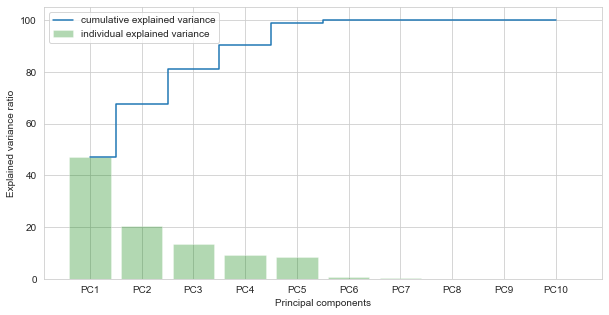

In [44]:
pca = PCA()
pca.fit(X_train_reduced)
pca_data = pca.transform(X_train_reduced)
per_var = np.round(pca.explained_variance_ratio_ * 100, decimals=1)

labels=['PC' + str(testing) for testing in range(1, len(per_var) + 1)]

cum_var = np.cumsum(per_var)

plt.figure(figsize=(10, 5))
plt.bar(range(len(per_var)), per_var, alpha=0.3, align='center', label='individual explained variance', color = 'g',tick_label=labels)
plt.step(range(len(cum_var)), cum_var, where='mid',label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.show();

In [45]:
labels

['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10']

In [46]:
### pca.components_ is the set of all eigenvectors (aka loadings) for your projection space
features_components = pd.DataFrame(pca.components_, columns=X_train_reduced.columns, index = labels)

Text(0.5, 1, 'Correlation between features and components')

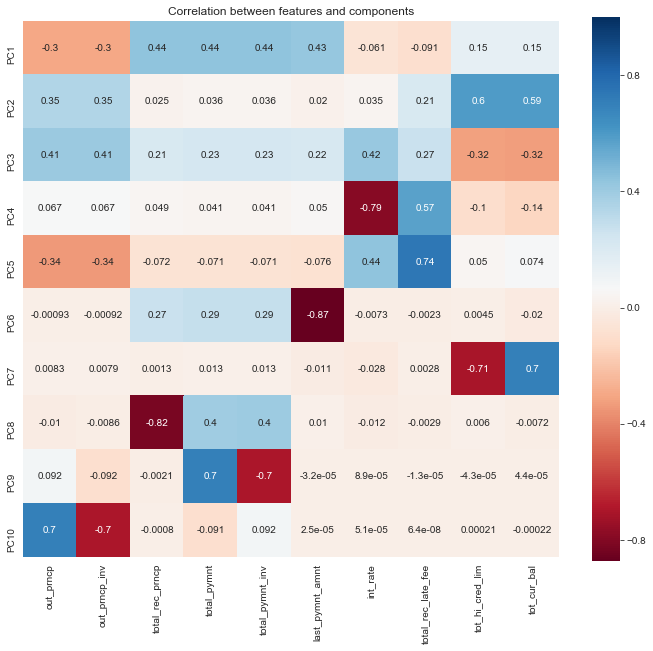

In [47]:
plt.figure(figsize=(12,10))
sns.heatmap(features_components, vmax=1, square=True,annot=True,cmap=colormap, linecolor='white')
plt.title('Correlation between features and components')

**Observation:** The correlation heatmap above allows us to see the breakdown of each Principal Component and potentially aid in its interpretability i.e. is there a particular set of features that are heavily weighted in the Principal Component

In [48]:
pca_df = pd.DataFrame(pca_data, columns = labels)


In [49]:
pca_df.head()

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -2.513732 -0.454958  1.060798 -0.671851 -0.254161  0.013454  0.057601   
1 -1.150302 -1.559096 -0.693661  0.314942  0.109859 -0.049479  0.033853   
2 -1.642761  1.527499 -1.089899 -0.024384 -0.423958  0.007485  0.183452   
3 -2.494591 -0.112190  0.240761  0.415551 -0.893428 -0.052376  0.108818   
4  0.951375 -0.727229  0.262581 -0.204109  0.180502 -0.074662  0.075648   

        PC8       PC9      PC10  
0  0.006946  0.000034 -0.000229  
1  0.002574 -0.000165 -0.000060  
2  0.012131 -0.000106 -0.000301  
3 -0.017233 -0.000194 -0.000363  
4  0.013018 -0.000173  0.000027

In [50]:
y_train

1200    0
1083    0
2593    0
1316    1
2500    0
       ..
373     0
618     0
2567    1
1051    0
630     0
Name: bad_loans, Length: 2393, dtype: int64

In [51]:
pca_df = pca_df.join(y_train.reset_index().drop("index", axis=1)[["bad_loans"]])

In [52]:
pca_df.head()

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -2.513732 -0.454958  1.060798 -0.671851 -0.254161  0.013454  0.057601   
1 -1.150302 -1.559096 -0.693661  0.314942  0.109859 -0.049479  0.033853   
2 -1.642761  1.527499 -1.089899 -0.024384 -0.423958  0.007485  0.183452   
3 -2.494591 -0.112190  0.240761  0.415551 -0.893428 -0.052376  0.108818   
4  0.951375 -0.727229  0.262581 -0.204109  0.180502 -0.074662  0.075648   

        PC8       PC9      PC10  bad_loans  
0  0.006946  0.000034 -0.000229          0  
1  0.002574 -0.000165 -0.000060          0  
2  0.012131 -0.000106 -0.000301          0  
3 -0.017233 -0.000194 -0.000363          1  
4  0.013018 -0.000173  0.000027          0

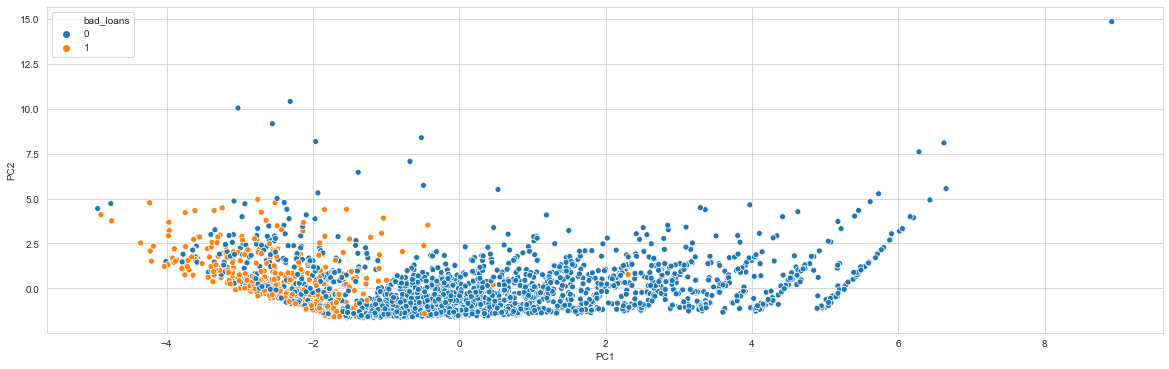

In [53]:
plt.figure(figsize=(20,6))
ax = sns.scatterplot(x="PC1", y="PC2", hue="bad_loans", data=pca_df)
plt.show()

**Observation:** Combining both PC1 and PC2 gives a total variation of around 70%. Plotting the 2 PCs, we can see there is clearly separation between the good loans and bad loans.

### 6.2 t-SNE

In [54]:
X_train_reduced

out_prncp  out_prncp_inv  total_rec_prncp  total_pymnt  total_pymnt_inv  \
1200   1.069451       1.069825        -0.917089    -0.880171        -0.880064   
1083  -0.501512      -0.501477        -0.704409    -0.730620        -0.730487   
2593   0.712691       0.712989        -0.898901    -0.880864        -0.880758   
1316   1.135314       1.135702        -0.972518    -0.986399        -0.986311   
2500  -0.501512      -0.501477         0.404985     0.416256         0.416591   
...         ...            ...              ...          ...              ...   
373   -0.501512      -0.501477        -0.629196    -0.659431        -0.659286   
618   -0.501512      -0.501477         2.285314     2.313301         2.313971   
2567   0.153711       0.153887        -0.992579    -1.013789        -1.013706   
1051   1.683262       1.683769        -0.869556    -0.834231        -0.834116   
630   -0.501512      -0.501477        -0.553983    -0.583861        -0.583702   

      last_pymnt_amnt  int_rate  total_rec_late_fee  tot_hi_cred_lim  \
1200        -0.879567  0.998138           -0.151844        -0.974444   
1083        -0.625716 -0.476178           -0.151844        -0.931298   
2593        -0.891085 -0.476178           -0.151844         0.868276   
1316        -0.885177 -0.476178           -0.151844        -0.683480   
2500         0.491535  0.265582           -0.151844        -0.400118   
...               ...       ...                 ...              ...   
373         -0.915232 -0.857181           -0.151844         1.127050   
618          2.362939 -0.478019           -0.151844         0.627847   
2567        -0.912875 -0.091494           -0.151844        -0.779797   
1051        -0.864802 -0.181683           -0.151844        -0.785794   
630         -0.476369 -0.857181           -0.151844        -0.428090   

      tot_cur_bal  
1200    -0.865808  
1083    -0.880202  
2593     1.122626  
1316    -0.555418  
2500    -0.281989  
...           ...  
373      0.534445  
618      0.822429  
2567    -0.730192  
1051    -0.763649  
630     -0.425659  

[2393 rows x 10 columns]

In [55]:
train_set_reduced = X_train_reduced.join(y_train)

In [56]:
time_start = time.time()

train_set_reduced_sne = deepcopy(train_set_reduced)

tsne = manifold.TSNE(n_components=2, verbose=1, perplexity=10, n_iter=5000,learning_rate=50,random_state=1234)
tsne_results = tsne.fit_transform(train_set_reduced)

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 2393 samples in 0.004s...
[t-SNE] Computed neighbors for 2393 samples in 0.071s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2393
[t-SNE] Computed conditional probabilities for sample 2000 / 2393
[t-SNE] Computed conditional probabilities for sample 2393 / 2393
[t-SNE] Mean sigma: 0.261775
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.771606
[t-SNE] KL divergence after 5000 iterations: 0.798326


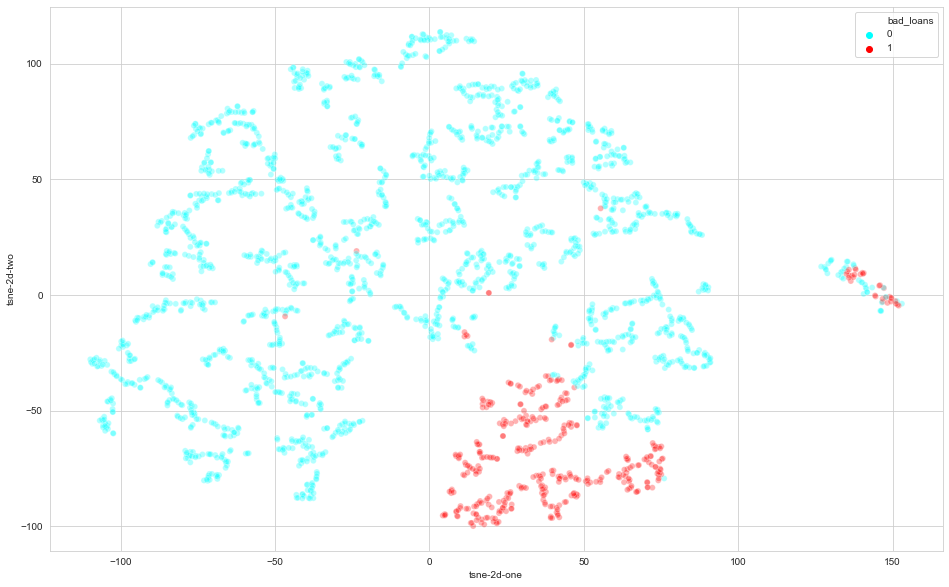

In [57]:
train_set_reduced_sne['tsne-2d-one'] = tsne_results[:,0]
train_set_reduced_sne['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(16,10))

flatui = ["#00FFFF","#FF0000"]

sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue='bad_loans',
    palette=sns.color_palette(flatui, 2),
    data=train_set_reduced_sne,
    legend="full",
    alpha=0.3
)

**Observation:** There is also a clear separation between the good and bad loans.

## 7. Correlation of top 10 Features

In [58]:
X_train_reduced.corr()

out_prncp  out_prncp_inv  total_rec_prncp  total_pymnt  \
out_prncp            1.000000       0.999998        -0.458615    -0.436868   
out_prncp_inv        0.999998       1.000000        -0.458584    -0.436833   
total_rec_prncp     -0.458615      -0.458584         1.000000     0.999097   
total_pymnt         -0.436868      -0.436833         0.999097     1.000000   
total_pymnt_inv     -0.436832      -0.436797         0.999091     0.999998   
last_pymnt_amnt     -0.436563      -0.436531         0.946038     0.944441   
int_rate             0.169145       0.169242        -0.066942    -0.048750   
total_rec_late_fee   0.251200       0.251205        -0.118670    -0.109531   
tot_hi_cred_lim      0.013690       0.013687         0.242973     0.246589   
tot_cur_bal          0.006739       0.006731         0.229844     0.233868   

                    total_pymnt_inv  last_pymnt_amnt  int_rate  \
out_prncp                 -0.436832        -0.436563  0.169145   
out_prncp_inv             -0.436797        -0.436531  0.169242   
total_rec_prncp            0.999091         0.946038 -0.066942   
total_pymnt                0.999998         0.944441 -0.048750   
total_pymnt_inv            1.000000         0.944429 -0.048589   
last_pymnt_amnt            0.944429         1.000000 -0.060511   
int_rate                  -0.048589        -0.060511  1.000000   
total_rec_late_fee        -0.109527        -0.113808  0.059746   
tot_hi_cred_lim            0.246585         0.221579 -0.090075   
tot_cur_bal                0.233873         0.210658 -0.055000   

                    total_rec_late_fee  tot_hi_cred_lim  tot_cur_bal  
out_prncp                     0.251200         0.013690     0.006739  
out_prncp_inv                 0.251205         0.013687     0.006731  
total_rec_prncp              -0.118670         0.242973     0.229844  
total_pymnt                  -0.109531         0.246589     0.233868  
total_pymnt_inv              -0.109527         0.246585     0.233873  
last_pymnt_amnt              -0.113808         0.221579     0.210658  
int_rate                      0.059746        -0.090075    -0.055000  
total_rec_late_fee            1.000000         0.052091     0.047758  
tot_hi_cred_lim               0.052091         1.000000     0.983993  
tot_cur_bal                   0.047758         0.983993     1.000000

Text(0.5, 1, 'Correlation of Top 10 Features')

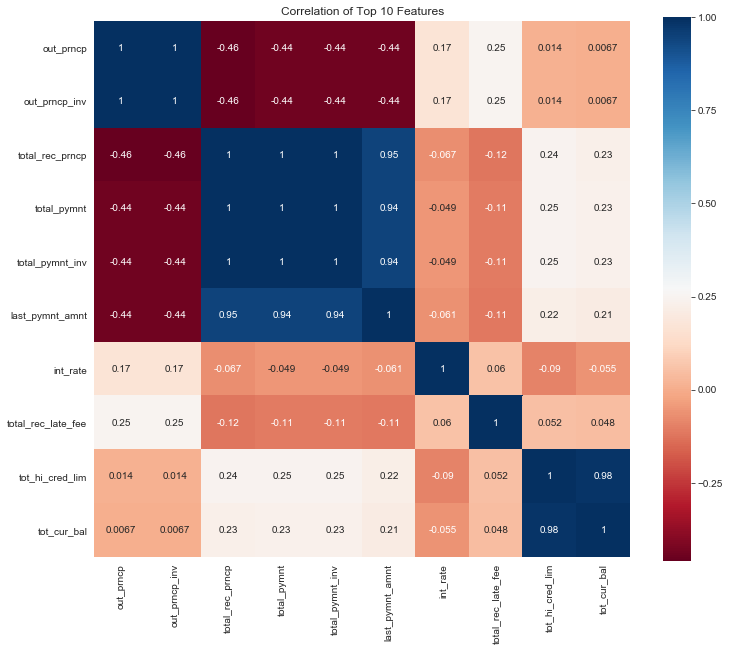

In [59]:
plt.figure(figsize=(12,10))
sns.heatmap(X_train_reduced.corr(), vmax=1, square=True,annot=True,cmap=colormap, linecolor='white')

plt.title('Correlation of Top 10 Features')

#### Only keep features that are not highly correlated

In [60]:
top5_feats = ['out_prncp','total_rec_prncp','int_rate','total_rec_late_fee','tot_hi_cred_lim']

Text(0.5, 1, 'Correlation of Top 5 Features')

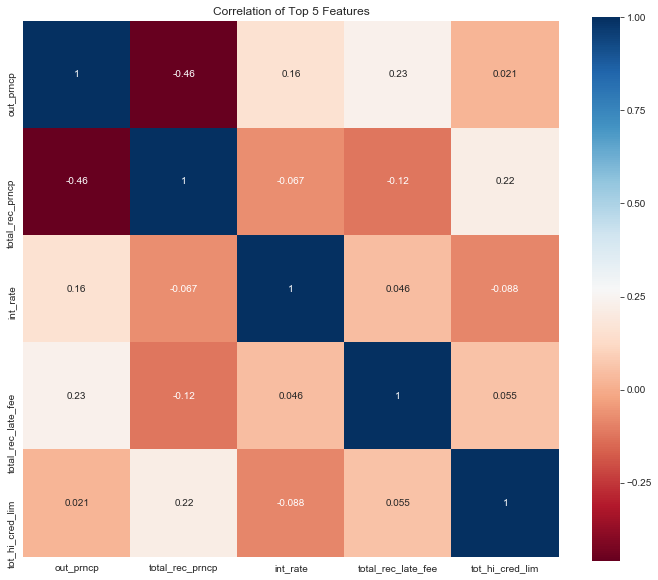

In [61]:
plt.figure(figsize=(12,10))
sns.heatmap(loans[top5_feats].corr(), vmax=1, square=True,annot=True,cmap=colormap, linecolor='white')

plt.title('Correlation of Top 5 Features')

## 8. Modelling

In [62]:
def cross_validation_smote_modified(splits, X_train, y_train, classifier):
 
    skf = StratifiedKFold(n_splits=splits,random_state=1234)    
    accuracy = []
    recall = []
    precision = []
    f1 = []
    roc_auc = []
    mcc = []
    
    for train_index, test_index in skf.split(X_train, y_train):
        # train-test split in each fold
        X_train_cv, X_test_cv = X_train[train_index], X_train[test_index]
        y_train_cv, y_test_cv = y_train[train_index], y_train[test_index]

        
        # SMOTE oversampling on the training set of the fold 
        pipeline = make_pipeline_imb(SMOTE(random_state = 1234), classifier)
        model = pipeline.fit(X_train_cv, y_train_cv)
        y_pred = model.predict(X_test_cv)
            
        accuracy.append(accuracy_score(y_test_cv, y_pred))
        recall.append(recall_score(y_test_cv, y_pred))
        precision.append(precision_score(y_test_cv, y_pred))
        f1.append(f1_score(y_test_cv, y_pred))
        roc_auc.append(roc_auc_score(y_test_cv, y_pred))
        mcc.append(matthews_corrcoef(y_test_cv, y_pred))
        
    average_result = {}
    average_result["accuracy"] = np.mean(accuracy)
    average_result["recall_score"] = np.mean(recall)
    average_result["precision"] = np.mean(precision)
    average_result["f1_score"] = np.mean(f1)
    average_result["roc_auc_score"] = np.mean(roc_auc)
    average_result["mcc"] = np.mean(mcc)
        
    full_result = {}
    full_result["accuracy"] = accuracy
    full_result["recall_score"] = recall
    full_result["precision"] = precision
    full_result["f1_score"] = f1
    full_result["roc_auc_score"] = roc_auc
    full_result["mcc"] = mcc
    
    return average_result,full_result

In [63]:
def cm_and_roc(confusion_matrix, class_names, Y_test, testPredict, figsize = (15,5), fontsize=12):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    
    # Confusion Matrix
    plt.subplot(121)
    heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title("Confusion Matrix")
    
    # ROC 
    plt.subplot(122)

    # Plot ROC Curve
    fpr, tpr, thresholds = roc_curve(Y_test, testPredict) # fpr: FP Rate, tpr: TP Rate, thresholds: Pr(y=1)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label='AUC = %0.2f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.1,1.1])
    plt.ylim([-0.1,1.1])
    plt.title('Receiver operating characteristic')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
    return

In [64]:
#for categorical value
#top7_feats = top5_feats + ["income_category_High","income_category_Low"]

In [65]:
random_state = 1234
classifiers = []
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(BaggingClassifier(random_state=random_state))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(BernoulliNB())
classifiers.append(GaussianNB())
classifiers.append(LinearSVC(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())
classifiers.append(xgb.XGBClassifier(objective="binary:logistic", random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(SVC(kernel='rbf',probability=True,random_state=random_state))
classifiers.append(lgb.LGBMClassifier(random_state=random_state))

In [66]:
classifier_names = ["DecisionTree","AdaBoost","BaggingClassifier","RandomForest","ExtraTrees","GradientBoosting"
                          ,"KNeighboursClassifier","LogisticRegression","BernoulliNB","GaussianNB","LinearSVC"
                          ,"LDA","XGB","MLPClassifier","SVC", "LGB"]

cv_average_results = dict()
cv_full_results = dict()
for i,classifier in enumerate(classifiers):
    print(f"Training Classifier {classifier_names[i]}...")
    
    try:
        average_result,full_result = cross_validation_smote_modified(5, X_train_scaled[top5_feats].values, y_train.values, classifier)
        acc = average_result["accuracy"]
        f1 = average_result["f1_score"]
        recall = average_result["recall_score"]
        precision = average_result["precision"]
        roc_auc = average_result['roc_auc_score']
        mcc = average_result['mcc']

        print(f"Mean Accuracy of {classifier_names[i]} is {acc}")
        print(f"Mean F1 of {classifier_names[i]} is {f1}")
        print(f"Mean Recall of {classifier_names[i]} is {recall}")
        print(f"Mean Precision of {classifier_names[i]} is {precision}")
        print(f"Mean ROC_AUC of {classifier_names[i]} is {roc_auc}")
        print(f"Mean MCC of {classifier_names[i]} is {mcc}")

        cv_average_results[classifier_names[i]] = average_result
        cv_full_results[classifier_names[i]] = full_result
    except:
        print(f"{classifier_names[i]} Error")
        cv_average_results[classifier_names[i]] = 0
        cv_full_results[classifier_names[i]] = 0

Training Classifier DecisionTree...
Mean Accuracy of DecisionTree is 0.8809197195750095
Mean F1 of DecisionTree is 0.6659817803461994
Mean Recall of DecisionTree is 0.7428571428571429
Mean Precision of DecisionTree is 0.604676062319055
Mean ROC_AUC of DecisionTree is 0.8249593048581977
Mean MCC of DecisionTree is 0.5997101319147767
Training Classifier AdaBoost...
Mean Accuracy of AdaBoost is 0.8805091565412602
Mean F1 of AdaBoost is 0.6629273606345032
Mean Recall of AdaBoost is 0.7350649350649351
Mean Precision of AdaBoost is 0.6043031403609899
Mean ROC_AUC of AdaBoost is 0.8215625651831718
Mean MCC of AdaBoost is 0.5956652019817853
Training Classifier BaggingClassifier...
Mean Accuracy of BaggingClassifier is 0.8825925080726643
Mean F1 of BaggingClassifier is 0.6778346461197735
Mean Recall of BaggingClassifier is 0.7797676008202324
Mean Precision of BaggingClassifier is 0.6006068256760263
Mean ROC_AUC of BaggingClassifier is 0.8409269716506875
Mean MCC of BaggingClassifier is 0.615869

In [67]:
cv_average_results

{'DecisionTree': {'accuracy': 0.8809197195750095,
  'recall_score': 0.7428571428571429,
  'precision': 0.604676062319055,
  'f1_score': 0.6659817803461994,
  'roc_auc_score': 0.8249593048581977,
  'mcc': 0.5997101319147767},
 'AdaBoost': {'accuracy': 0.8805091565412602,
  'recall_score': 0.7350649350649351,
  'precision': 0.6043031403609899,
  'f1_score': 0.6629273606345032,
  'roc_auc_score': 0.8215625651831718,
  'mcc': 0.5956652019817853},
 'BaggingClassifier': {'accuracy': 0.8825925080726643,
  'recall_score': 0.7797676008202324,
  'precision': 0.6006068256760263,
  'f1_score': 0.6778346461197735,
  'roc_auc_score': 0.8409269716506875,
  'mcc': 0.6158691795350129},
 'RandomForest': {'accuracy': 0.8821714775086406,
  'recall_score': 0.7953861927546139,
  'precision': 0.5985256410256411,
  'f1_score': 0.6826526971642022,
  'roc_auc_score': 0.8469986776520745,
  'mcc': 0.6217565356412516},
 'ExtraTrees': {'accuracy': 0.8817513386500817,
  'recall_score': 0.7688311688311689,
  'precisi

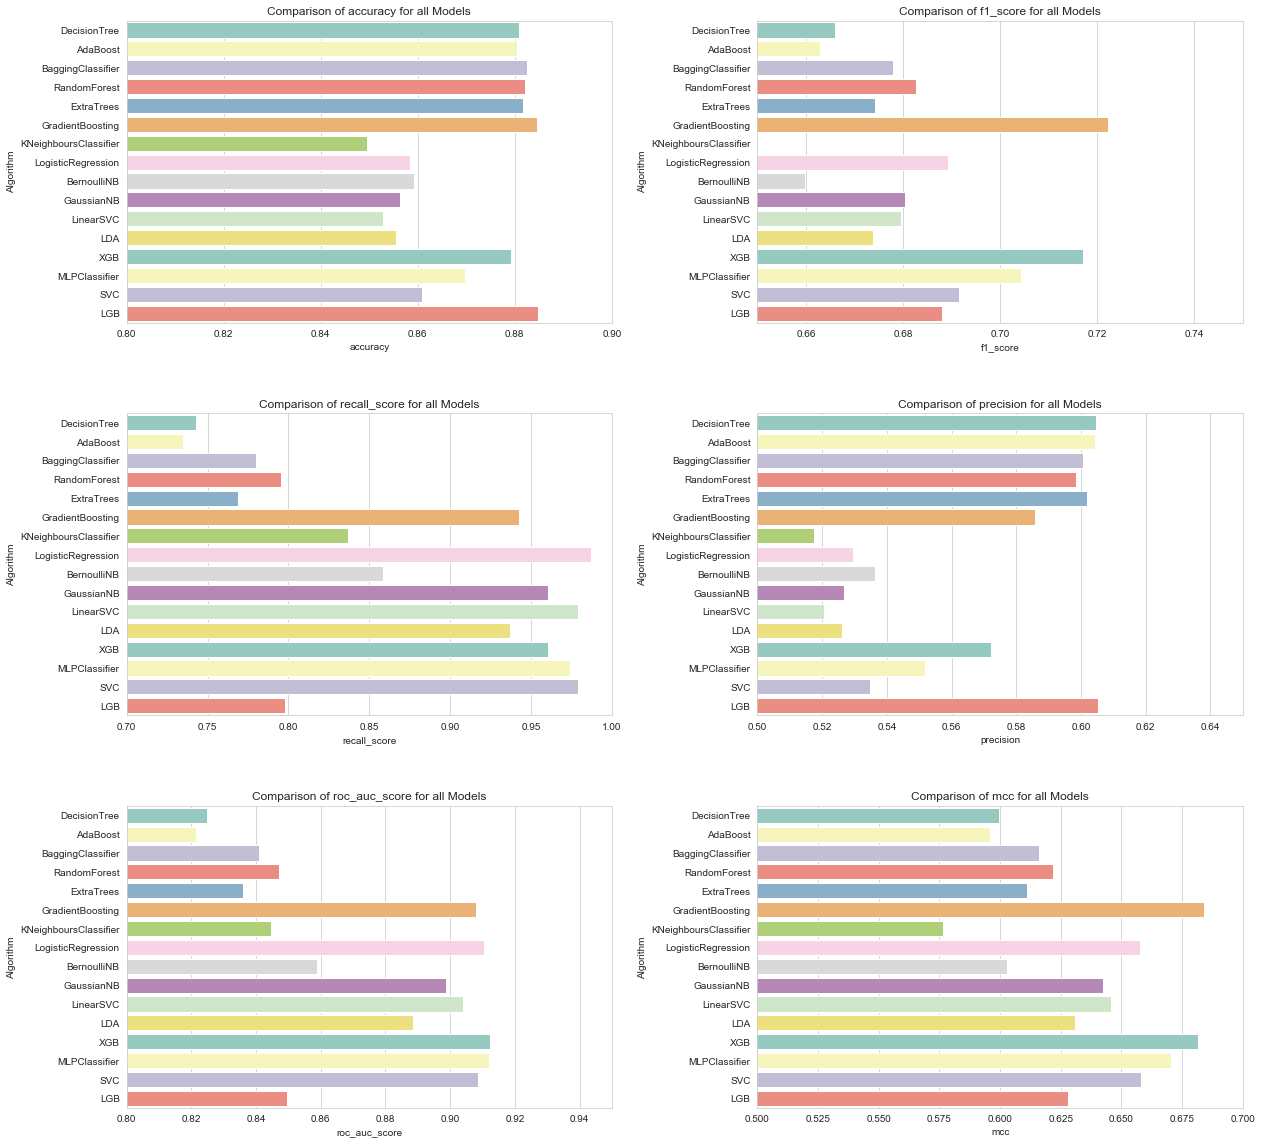

In [68]:
metrics = ["accuracy","f1_score","recall_score","precision","roc_auc_score","mcc"]

model_score_by_metric = []

for i in metrics:
    sub = []
    for j in classifier_names:
        sub.append(cv_average_results[j][i])
    model_score_by_metric.append(sub)


fig = plt.figure(constrained_layout=False, figsize=(20,20))
spec = fig.add_gridspec(3, 2, wspace=0.3, hspace=0.3)

for i,met in enumerate(metrics):
    #print(met)
    cv_res = pd.DataFrame({"CrossValScore":model_score_by_metric[i],"Algorithm":classifier_names})
    #print(cv_res)
    
    axes = fig.add_subplot(spec[i])

    g = sns.barplot("CrossValScore","Algorithm",data = cv_res, palette="Set3",orient = "h")
    g.set_xlabel(met)
    if met == "accuracy":
        g.set_xlim(0.8, 0.9)
    elif met == "f1_score":
        g.set_xlim(0.65, 0.75)
    elif met == "recall_score":
        g.set_xlim(0.7, 1)
    elif met == "precision":
        g.set_xlim(0.5,0.65)
    elif met == "roc_auc_score":
        g.set_xlim(0.8,0.95)
    else:
        g.set_xlim(0.5,0.7)
    g = g.set_title(f"Comparison of {met} for all Models")

## 9. SMOTE Oversampling on Training Set
- This oversampled training set will be used solely to fit the model and then evaluate it on the test set

In [69]:
# Address the Unbalanced Training Set by Oversampling SMOTE
sm = SMOTE(random_state=1234)
sm_X_train, sm_y_train = sm.fit_sample(X_train_scaled[top5_feats], y_train.ravel())

## 10. Analysing the impact of Hyperparameters on Training and Validation Score 


## (Validation Curve and Bayesian Optimisation Tuning)

- Random Forest, Logistic Regression, XGBoost, SVM, MLP, Bagging, Decision Tree

In [70]:
from sklearn.model_selection import validation_curve
from imblearn import pipeline as pl

### Validation Curve

In [71]:
def plot_validation_curve(classifier, classifier_name, parameter, param_range, X_train, y_train, scoring, base):
    
    # Create SMOTE pipeline
    pipeline = pl.make_pipeline(SMOTE(random_state=1234), classifier)
    
    # Create Stratified Kfold
    skf = StratifiedKFold(n_splits=5,random_state=1234)
    
    # Create validation curve
    train_scores, test_scores = validation_curve(
        pipeline,
        X_train, y_train,
        param_name = '{0}__{1}'.format(classifier_name, parameter),
        param_range = param_range,
        cv=skf,
        scoring=scoring
    )
    
    # Create the graph
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    fig = plt.figure(figsize=(8, 3), dpi=100)
    ax = plt.gca()

    plt.title("Validation Curve with {}".format(classifier_name))
    plt.xlabel(parameter)
    plt.ylabel(scoring)
    
    temp = list(train_scores_mean)
    temp.extend(test_scores_mean)
    
    temp2 = list(test_scores_std)
    temp2.extend(train_scores_std)
    
    max_y = max(temp) + (1.1*max(temp2))
    min_y = min(temp) - (1.1*max(temp2))
    plt.ylim(min_y, max_y)
    
    if base == "norm":
    
        plt.plot([str(i) for i in param_range],
                 train_scores_mean,
                 label="Training score",
                 color="r")

        plt.plot([str(i) for i in param_range],
                 test_scores_mean,
                 label="Cross-validation score",
                 color="g")

        plt.fill_between([str(i) for i in param_range],
                         train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std,
                         alpha=0.2, color="r")

        plt.fill_between([str(i) for i in param_range],
                         test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std,
                         alpha=0.2, color="g")
        
    else:
        plt.plot([i for i in param_range],
                 train_scores_mean,
                 label="Training score",
                 color="r")

        plt.plot([i for i in param_range],
                 test_scores_mean,
                 label="Cross-validation score",
                 color="g")

        plt.fill_between([i for i in param_range],
                         train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std,
                         alpha=0.2, color="r")

        plt.fill_between([i for i in param_range],
                         test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std,
                         alpha=0.2, color="g")
        
        ax.set_xscale('log', basex = 2)

    plt.axhline(y=1, color='k', ls='dashed')

    plt.legend(loc="best")
    plt.show()

    i = np.argmax(test_scores_mean)
    print("Best cross-validation result ({0:.2f}) obtained for {1}: {2}".format(test_scores_mean[i], parameter, param_range[i]))
    
    return param_range[i]

### Bayesian Optimisation Tuning

* choice : categorical variables
* quniform : discrete uniform (integers spaced evenly)
* uniform: continuous uniform (floats spaced evenly)
* loguniform: continuous log uniform (floats spaced evenly on a log scale)

#### Grid Search using 5-fold cross validation
- a pipeline is created to SMOTE the training set during the cross-validation at every iteration rather than before cross-validation to prevent overfitting

In [72]:
def bayes_opt(classifier,param_space,X_train,y_train,metric):

    def objective_function(param_space):

        clf = classifier(random_state=1234, **param_space)
        pipeline = Pipeline([
            ('sampling', SMOTE(random_state=1234)),
            ('classification', clf)
        ])    
        score = cross_val_score(pipeline, X_train,y_train, cv=5,scoring=metric).mean()
        return {'loss': -score, 'status': STATUS_OK}
    
    trials = Trials()
    best_param = fmin(objective_function, 
                      param_space, 
                      algo=tpe.suggest, 
                      max_evals=100, 
                      trials=trials,
                      rstate= np.random.RandomState(1234)
                     )

    loss = [x['result']['loss'] for x in trials.trials]
    
    print("")
    print("##### Results")
    print("Score best parameters: ", min(loss)*-1)
    print("Best parameters: ", best_param)
    

### Random Forest

- max_depth, max_features, min_samples_split, min_samples_leaf, boostrap, n_estimators, criterion

#### Define parameters and parameter range

In [73]:
params_dic = {
    "max_depth": np.arange(5,16,1),
    "max_features": np.arange(3,6,1),
    "min_samples_split": np.arange(10, 51, 10),
    "min_samples_leaf": np.arange(10,31,10),
    "n_estimators": np.arange(50,301, 50),
    "bootstrap": np.array([False, True]),
    "criterion": np.array(["gini", "entropy"])
}

In [74]:
classifier = RandomForestClassifier(random_state=1234)
classifier_name = "randomforestclassifier"

#### Run Validation Curve
- Identify the value of parameter that gives the best score

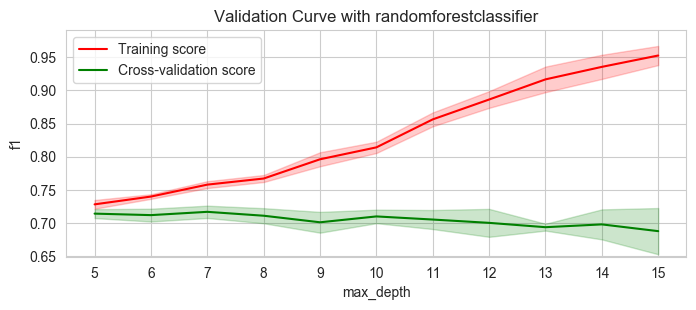

Best cross-validation result (0.72) obtained for max_depth: 7


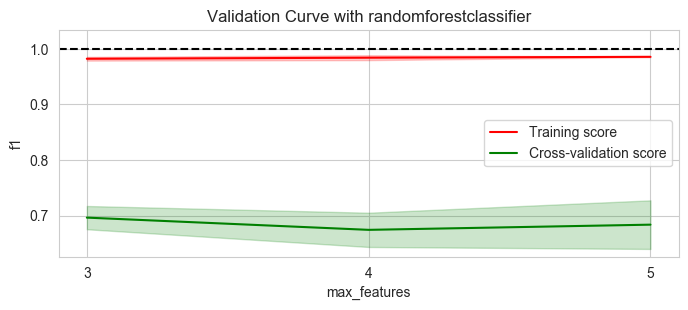

Best cross-validation result (0.70) obtained for max_features: 3


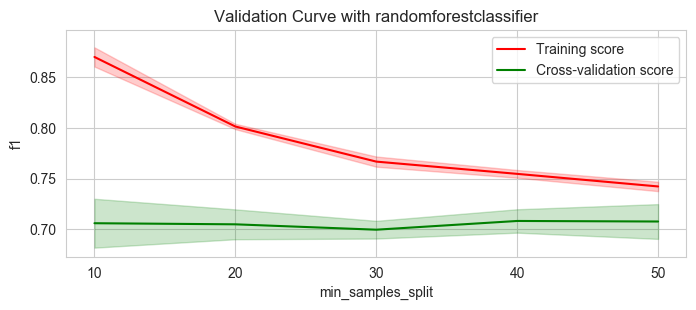

Best cross-validation result (0.71) obtained for min_samples_split: 40


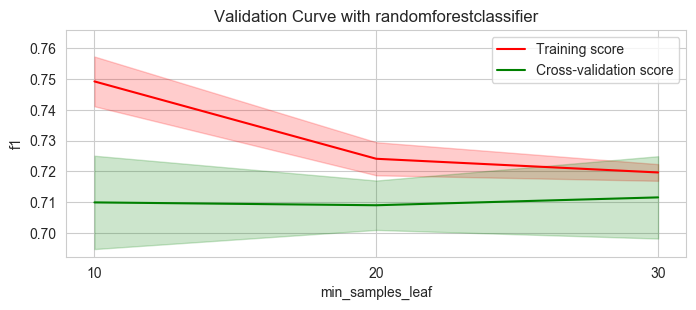

Best cross-validation result (0.71) obtained for min_samples_leaf: 30


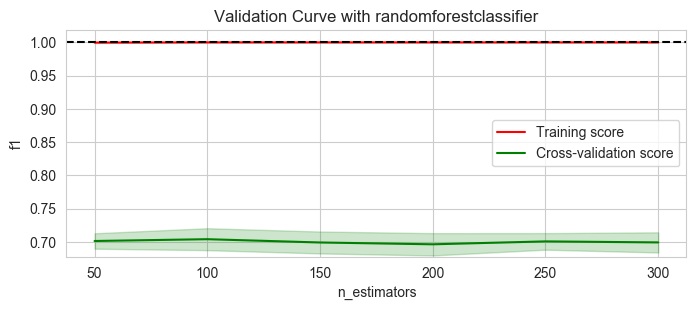

Best cross-validation result (0.70) obtained for n_estimators: 100


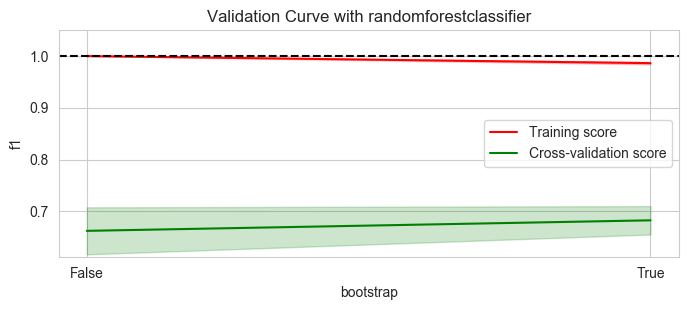

Best cross-validation result (0.68) obtained for bootstrap: True


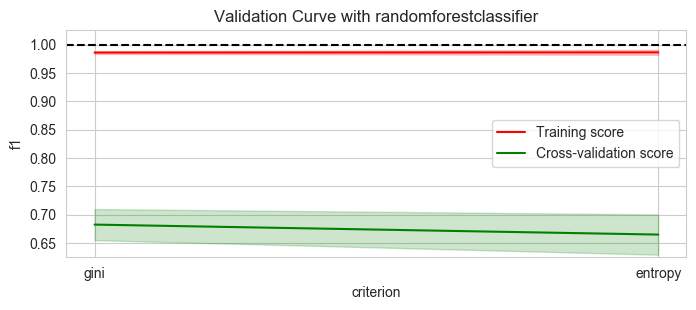

Best cross-validation result (0.68) obtained for criterion: gini


In [75]:
rf_best_params = {}
for param in params_dic:
    parameter = param
    param_range = params_dic[param]
    if param != "C":
        best_param = plot_validation_curve(classifier, classifier_name, parameter, param_range, 
                                           X_train_scaled[top5_feats].values, y_train.values, "f1","norm")
    else:
        best_param = plot_validation_curve(classifier, classifier_name, parameter, param_range, 
                                           X_train_scaled[top5_feats].values, y_train.values, "f1","log")
    
    rf_best_params[param] = best_param

#### Run Bayesian Optimisation Tuning
- Use Validation Curve to scope parameter range

##### Tuning Attempt 1 (Use Validation Curve to scope Parameter Range)
- Cross Validation and Test Results

In [76]:
rf_param_space1 = {"max_depth": scope.int(hp.quniform('max_depth', 5, 15, 1)),
                  "max_features": scope.int(hp.quniform('max_features', 3, 5, 1)),
                  "min_samples_split": scope.int(hp.quniform("min_samples_split", 10, 50, 10)),
                  "min_samples_leaf":  scope.int(hp.quniform("min_samples_leaf", 10,30,10)),
                  "bootstrap": hp.choice("bootstrap", [False,True]),
                  "n_estimators" : scope.int(hp.quniform("n_estimators", 50,300,50)),
                  "criterion": hp.choice("criterion", ["gini","entropy"])}

bayes_opt(RandomForestClassifier,rf_param_space1,X_train_scaled[top5_feats].values, y_train.values,"f1")

100%|██████████| 100/100 [05:09<00:00,  3.09s/it, best loss: -0.7157917567350246]

##### Results
Score best parameters:  0.7157917567350246
Best parameters:  {'bootstrap': 1, 'criterion': 0, 'max_depth': 14.0, 'max_features': 5.0, 'min_samples_leaf': 10.0, 'min_samples_split': 40.0, 'n_estimators': 100.0}


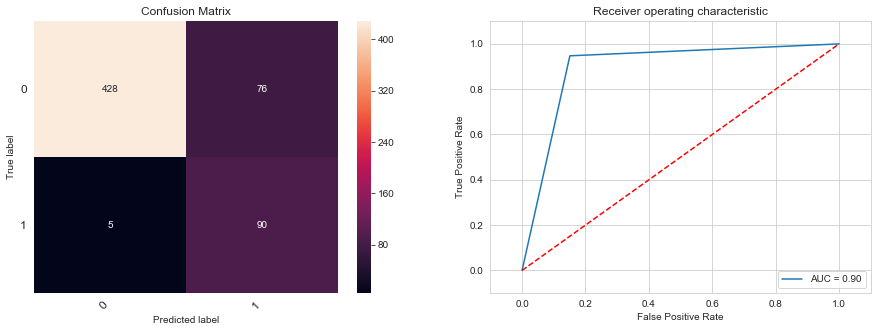

Accuracy:  0.8647746243739566
Sensitivity:  0.9473684210526315
Precision:  0.5421686746987951
f1 Score:  0.6896551724137931
ROC_AUC_Score: 0.8982873851294902
MCC:  0.6501381118713189


In [77]:
rf = RandomForestClassifier(bootstrap='True',criterion='gini',max_depth=14,max_features=5,min_samples_leaf=10,min_samples_split=40,n_estimators=100,random_state=1234)
rf.fit(sm_X_train, sm_y_train)
y_pred_rf = rf.predict(X_test_scaled[top5_feats].values)
cm = confusion_matrix(y_test, y_pred_rf)
cm_and_roc(cm, [0, 1], y_test, y_pred_rf, figsize = (15,5), fontsize=12)

print ("Accuracy: ", accuracy_score(y_test, y_pred_rf))
print("Sensitivity: ", recall_score(y_test, y_pred_rf))
print("Precision: ", precision_score(y_test, y_pred_rf))
print ("f1 Score: ", f1_score(y_test, y_pred_rf))
print("ROC_AUC_Score:", roc_auc_score(y_test, y_pred_rf))
print("MCC: ", matthews_corrcoef(y_test, y_pred_rf))

##### Tuning Attempt 2 (Use Attempt 1 to scope Parameter Range)
- Cross Validation and Test Results

In [78]:
rf_param_space2 = {"max_depth": scope.int(hp.quniform('max_depth', 5, 15, 1)),
                  "max_features": scope.int(hp.quniform('max_features', 3, 5, 1)),
                  "min_samples_split": scope.int(hp.quniform("min_samples_split", 10, 50, 5)),
                  "min_samples_leaf":  scope.int(hp.quniform("min_samples_leaf", 10,50,5)),
                  "bootstrap": hp.choice("bootstrap", [False,True]),
                  "n_estimators" : scope.int(hp.quniform("n_estimators", 50,200,25)),
                  "criterion": hp.choice("criterion", ["gini","entropy"])}

bayes_opt(RandomForestClassifier,rf_param_space2,X_train_scaled[top5_feats].values, y_train.values,"f1")


100%|██████████| 100/100 [04:25<00:00,  2.65s/it, best loss: -0.7150921872924803]

##### Results
Score best parameters:  0.7150921872924803
Best parameters:  {'bootstrap': 1, 'criterion': 0, 'max_depth': 9.0, 'max_features': 5.0, 'min_samples_leaf': 10.0, 'min_samples_split': 40.0, 'n_estimators': 150.0}


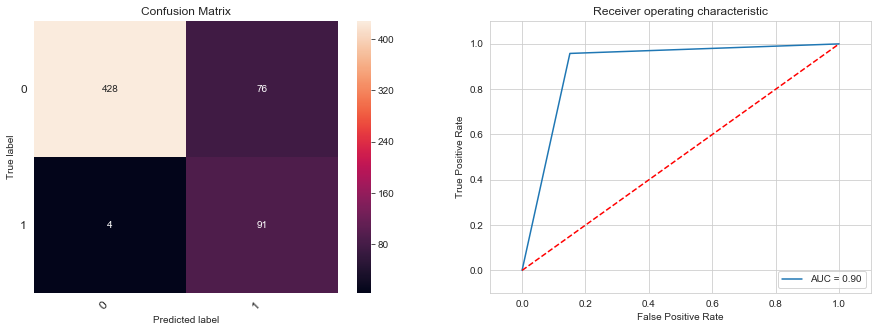

Accuracy:  0.8664440734557596
Sensitivity:  0.9578947368421052
Precision:  0.5449101796407185
f1 Score:  0.6946564885496184
ROC_AUC_Score: 0.9035505430242271
MCC:  0.6575138322368055


In [79]:
rf = RandomForestClassifier(bootstrap='True',criterion='gini',max_depth=9,max_features=5,min_samples_leaf=10,min_samples_split=40,n_estimators=150,random_state=1234)
rf.fit(sm_X_train, sm_y_train)
y_pred_rf = rf.predict(X_test_scaled[top5_feats].values)
cm = confusion_matrix(y_test, y_pred_rf)
cm_and_roc(cm, [0, 1], y_test, y_pred_rf, figsize = (15,5), fontsize=12)

print ("Accuracy: ", accuracy_score(y_test, y_pred_rf))
print("Sensitivity: ", recall_score(y_test, y_pred_rf))
print("Precision: ", precision_score(y_test, y_pred_rf))
print ("f1 Score: ", f1_score(y_test, y_pred_rf))
print("ROC_AUC_Score:", roc_auc_score(y_test, y_pred_rf))
print("MCC: ", matthews_corrcoef(y_test, y_pred_rf))

##### Tuning Attempt 3 (Use Attempt 2 to scope Parameter Range)
- Cross Validation and Test Results

In [80]:
rf_param_space3 = {"max_depth": scope.int(hp.quniform('max_depth', 5, 15, 1)),
                  "max_features": scope.int(hp.quniform('max_features', 3, 5, 1)),
                  "min_samples_split": scope.int(hp.quniform("min_samples_split", 5, 40, 5)),
                  "min_samples_leaf":  scope.int(hp.quniform("min_samples_leaf", 5,60,5)),
                  "bootstrap": hp.choice("bootstrap", [True]),
                  "n_estimators" : scope.int(hp.quniform("n_estimators", 100,250,10)),
                  "criterion": hp.choice("criterion", ["gini"])}

bayes_opt(RandomForestClassifier,rf_param_space3,X_train_scaled[top5_feats].values, y_train.values,"f1")

100%|██████████| 100/100 [06:58<00:00,  4.19s/it, best loss: -0.7163262768275407]

##### Results
Score best parameters:  0.7163262768275407
Best parameters:  {'bootstrap': 0, 'criterion': 0, 'max_depth': 10.0, 'max_features': 5.0, 'min_samples_leaf': 10.0, 'min_samples_split': 40.0, 'n_estimators': 210.0}


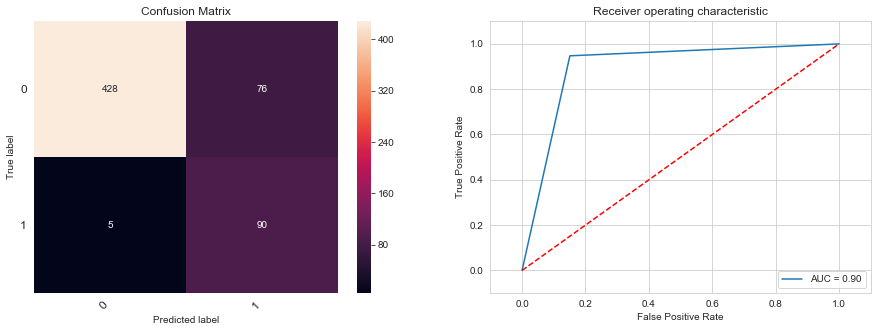

Accuracy:  0.8647746243739566
Sensitivity:  0.9473684210526315
Precision:  0.5421686746987951
f1 Score:  0.6896551724137931
ROC_AUC_Score: 0.8982873851294902
MCC:  0.6501381118713189


In [81]:
rf = RandomForestClassifier(bootstrap='True',criterion='gini',max_depth=10,max_features=5,min_samples_leaf=10,min_samples_split=40,n_estimators=210,random_state=1234)
rf.fit(sm_X_train, sm_y_train)
y_pred_rf = rf.predict(X_test_scaled[top5_feats].values)
cm = confusion_matrix(y_test, y_pred_rf)
cm_and_roc(cm, [0, 1], y_test, y_pred_rf, figsize = (15,5), fontsize=12)

print ("Accuracy: ", accuracy_score(y_test, y_pred_rf))
print("Sensitivity: ", recall_score(y_test, y_pred_rf))
print("Precision: ", precision_score(y_test, y_pred_rf))
print ("f1 Score: ", f1_score(y_test, y_pred_rf))
print("ROC_AUC_Score:", roc_auc_score(y_test, y_pred_rf))
print("MCC: ", matthews_corrcoef(y_test, y_pred_rf))

### Logistic Regression

- penalty, fit_intercept, C, max_iter

#### Define Parameters and Parameter Range

In [82]:
params_dic = {
    "penalty": np.array(["l1", "l2"]),
    "fit_intercept": np.array([True, False]),
    "C": np.logspace(-5,5,500),
    "max_iter": np.array([100,200,500,800,1000,1500])
}

In [83]:
classifier = LogisticRegression(random_state=1234)
classifier_name = "logisticregression"

#### Run Validation Curve
- Identify the value of parameter that gives the best score

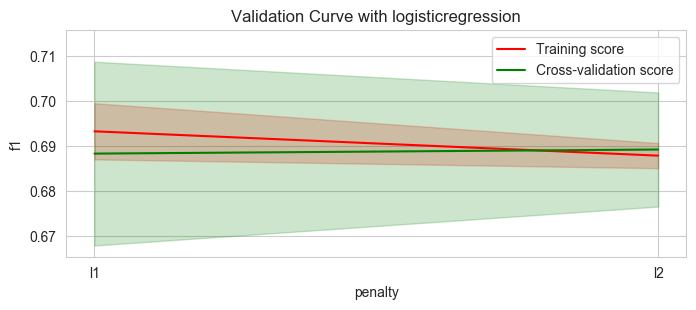

Best cross-validation result (0.69) obtained for penalty: l2


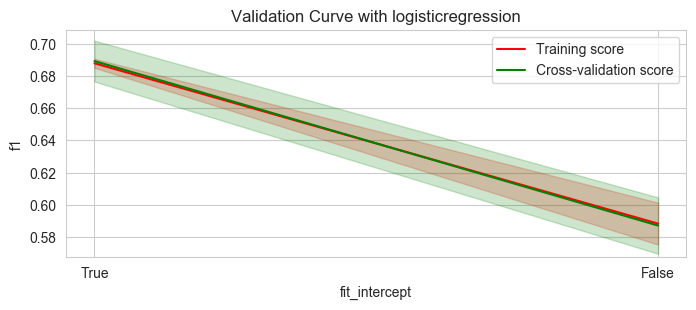

Best cross-validation result (0.69) obtained for fit_intercept: True


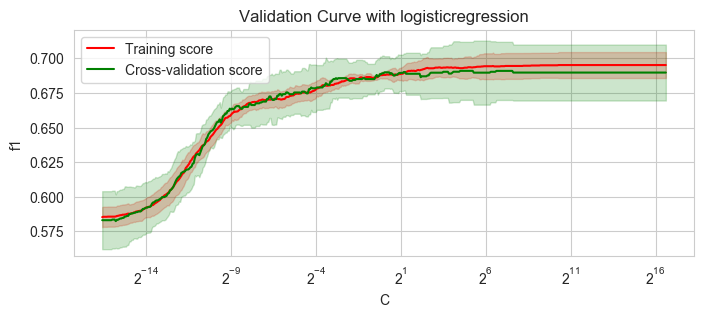

Best cross-validation result (0.69) obtained for C: 22.52710642645978


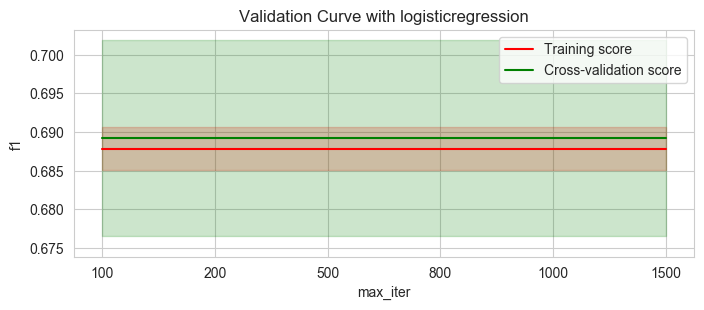

Best cross-validation result (0.69) obtained for max_iter: 100


In [84]:
log_best_params = {}
for param in params_dic:
    parameter = param
    param_range = params_dic[param]
    if param != "C":
        best_param = plot_validation_curve(classifier, classifier_name, parameter, param_range, 
                                           X_train_scaled[top5_feats].values, y_train.values, "f1","norm")
    else:
        best_param = plot_validation_curve(classifier, classifier_name, parameter, param_range, 
                                           X_train_scaled[top5_feats].values, y_train.values, "f1","log")
    
    log_best_params[param] = best_param

#### Run Bayesian Optimisation Tuning

##### Tuning Attempt 1 (Use Validation Curve to scope parameter range)
- Cross Validation and Test Results

In [85]:
log_best_params

{'penalty': 'l2',
 'fit_intercept': True,
 'C': 22.52710642645978,
 'max_iter': 100}

In [86]:
log_param_space1 = {"penalty": hp.choice("penalty", ['l1','l2']),
                   "fit_intercept" : hp.choice("fit_intercept", [True,False]),
                   "C": hp.choice("C", list(np.logspace(-3,5,500))),
                   "max_iter":hp.choice("max_iter", [50,100,200,500]),
                   "n_jobs":hp.choice("n_jobs", [3])}

bayes_opt(LogisticRegression,log_param_space1,X_train_scaled[top5_feats].values, y_train.values,"f1")

100%|██████████| 100/100 [00:14<00:00,  6.92it/s, best loss: -0.6909262940564236]

##### Results
Score best parameters:  0.6909262940564236
Best parameters:  {'C': 272, 'fit_intercept': 0, 'max_iter': 3, 'n_jobs': 0, 'penalty': 1}


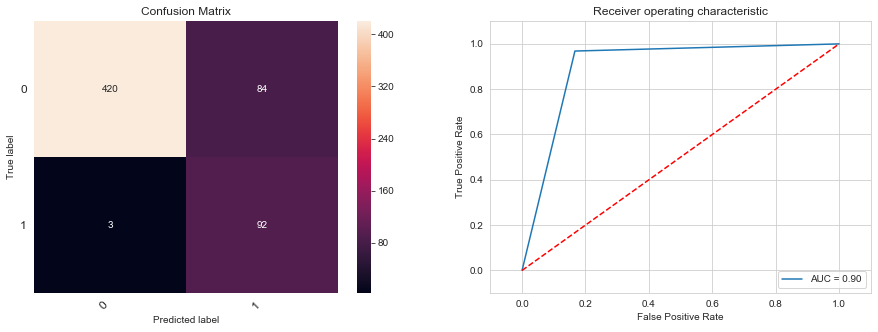

Accuracy:  0.8547579298831386
Sensitivity:  0.968421052631579
Precision:  0.5227272727272727
f1 Score:  0.6789667896678966
ROC_AUC_Score: 0.9008771929824562
MCC:  0.6429717585195074


In [87]:
lr = LogisticRegression(C=list(np.logspace(-3,5,500))[272], 
                        fit_intercept=True,
                        max_iter=500,
                        n_jobs=3,
                        penalty='l2',
                        random_state=1234)
lr.fit(sm_X_train, sm_y_train)
y_pred_lr = lr.predict(X_test_scaled[top5_feats].values)
cm = confusion_matrix(y_test, y_pred_lr)
cm_and_roc(cm, [0, 1], y_test, y_pred_lr, figsize = (15,5), fontsize=12)

print ("Accuracy: ", accuracy_score(y_test, y_pred_lr))
print("Sensitivity: ", recall_score(y_test, y_pred_lr))
print("Precision: ", precision_score(y_test, y_pred_lr))
print ("f1 Score: ", f1_score(y_test, y_pred_lr))
print("ROC_AUC_Score:", roc_auc_score(y_test, y_pred_lr))
print("MCC: ", matthews_corrcoef(y_test, y_pred_lr))

##### Tuning Attempt 2 (Use Attempt 1 to scope parameter range)
- Cross Validation and Test Results

In [88]:
log_param_space2 = {"penalty": hp.choice("penalty", ['l1','l2']),
                   "fit_intercept" : hp.choice("fit_intercept", [True,False]),
                   "C": hp.choice("C", list(np.logspace(-1,5,500))),
                   "max_iter":hp.choice("max_iter", [100,200,500,700,1000]),
                   "n_jobs":hp.choice("n_jobs", [3])}

bayes_opt(LogisticRegression,log_param_space2,X_train_scaled[top5_feats].values, y_train.values,"f1")

100%|██████████| 100/100 [00:22<00:00,  4.49it/s, best loss: -0.6909262940564236]

##### Results
Score best parameters:  0.6909262940564236
Best parameters:  {'C': 198, 'fit_intercept': 0, 'max_iter': 0, 'n_jobs': 0, 'penalty': 1}


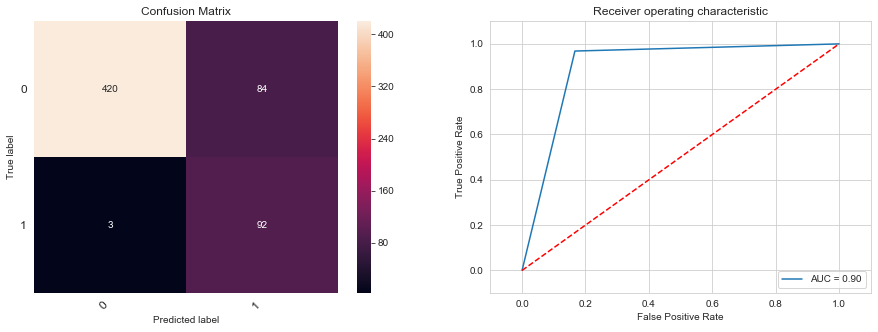

Accuracy:  0.8547579298831386
Sensitivity:  0.968421052631579
Precision:  0.5227272727272727
f1 Score:  0.6789667896678966
ROC_AUC_Score: 0.9008771929824562
MCC:  0.6429717585195074


In [89]:
lr = LogisticRegression(C=list(np.logspace(-1,5,500))[198], 
                        fit_intercept=True,
                        max_iter=100,
                        n_jobs=3,
                        penalty='l2',
                        random_state=1234)
lr.fit(sm_X_train, sm_y_train)
y_pred_lr = lr.predict(X_test_scaled[top5_feats].values)
cm = confusion_matrix(y_test, y_pred_lr)
cm_and_roc(cm, [0, 1], y_test, y_pred_lr, figsize = (15,5), fontsize=12)

print ("Accuracy: ", accuracy_score(y_test, y_pred_lr))
print("Sensitivity: ", recall_score(y_test, y_pred_lr))
print("Precision: ", precision_score(y_test, y_pred_lr))
print ("f1 Score: ", f1_score(y_test, y_pred_lr))
print("ROC_AUC_Score:", roc_auc_score(y_test, y_pred_lr))
print("MCC: ", matthews_corrcoef(y_test, y_pred_lr))

##### Tuning Attempt 3 (Use Attempt 2 to scope parameter range)

In [90]:
log_param_space3 = {"penalty": hp.choice("penalty", ['l1','l2']),
                   "fit_intercept" : hp.choice("fit_intercept", [True,False]),
                   "C": hp.choice("C", list(np.logspace(-1,3,500))),
                   "max_iter":hp.choice("max_iter", [50,75,100,200,500,700,1000]),
                   "n_jobs":hp.choice("n_jobs", [3])}

bayes_opt(LogisticRegression,log_param_space3,X_train_scaled[top5_feats].values, y_train.values,"f1")

100%|██████████| 100/100 [00:20<00:00,  4.81it/s, best loss: -0.6909262940564236]

##### Results
Score best parameters:  0.6909262940564236
Best parameters:  {'C': 313, 'fit_intercept': 0, 'max_iter': 5, 'n_jobs': 0, 'penalty': 1}


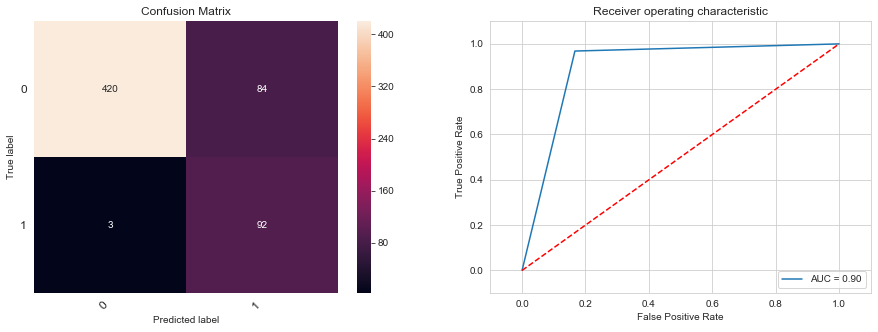

Accuracy:  0.8547579298831386
Sensitivity:  0.968421052631579
Precision:  0.5227272727272727
f1 Score:  0.6789667896678966
ROC_AUC_Score: 0.9008771929824562
MCC:  0.6429717585195074


In [91]:
lr = LogisticRegression(C=list(np.logspace(-1,3,500))[313], fit_intercept=True,max_iter=700,n_jobs=3,penalty='l2',random_state=1234)
lr.fit(sm_X_train, sm_y_train)
y_pred_lr = lr.predict(X_test_scaled[top5_feats].values)
cm = confusion_matrix(y_test, y_pred_lr)
cm_and_roc(cm, [0, 1], y_test, y_pred_lr, figsize = (15,5), fontsize=12)

print ("Accuracy: ", accuracy_score(y_test, y_pred_lr))
print("Sensitivity: ", recall_score(y_test, y_pred_lr))
print("Precision: ", precision_score(y_test, y_pred_lr))
print ("f1 Score: ", f1_score(y_test, y_pred_lr))
print("ROC_AUC_Score:", roc_auc_score(y_test, y_pred_lr))
print("MCC: ", matthews_corrcoef(y_test, y_pred_lr))

### XGBoost
- learning_rate, min_child_weight, gamma, subsample, colsample_bytree, reg_alpha, reg_lambda, max_depth, min_child_weight, n_estimators

#### Define Parameters and Parameter Range

In [92]:
params_dic = {
    "learning_rate": np.array([0.01,0.05,0.1,0.2,0.3,0.5,1]),
    "gamma": np.arange(1,6,1),
    "subsample": np.arange(0.5, 1.01, 0.1),
    "colsample_bytree": np.arange(0.5, 1.01, 0.1),
    "reg_alpha": np.array([1e-5, 1e-2, 0.1, 1, 100]),
    "reg_lambda": np.array([1e-5, 1e-2, 0.1, 1, 100]),
    "max_depth": np.arange(5,11,1),
    "min_child_weight": np.arange(4,21,1),
    "n_estimators": np.array([10,20,50,100,200])
}

In [93]:
classifier = xgb.XGBClassifier(random_state=1234)
classifier_name = "xgbclassifier"

#### Run Validation Curve 
- identify the value of parameter that gives the best score

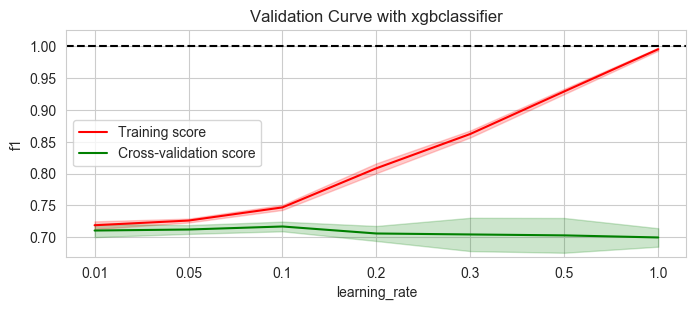

Best cross-validation result (0.72) obtained for learning_rate: 0.1


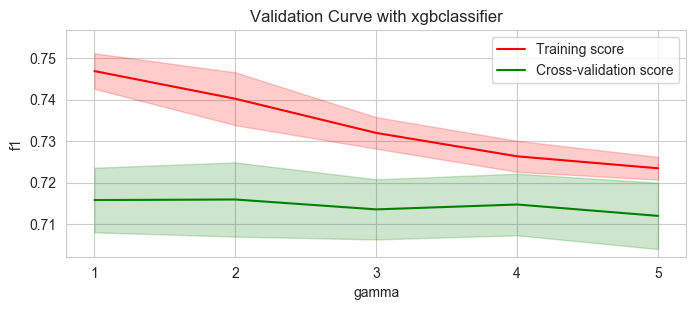

Best cross-validation result (0.72) obtained for gamma: 2


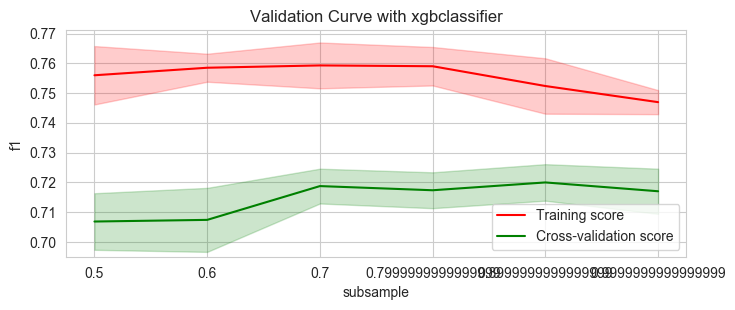

Best cross-validation result (0.72) obtained for subsample: 0.8999999999999999


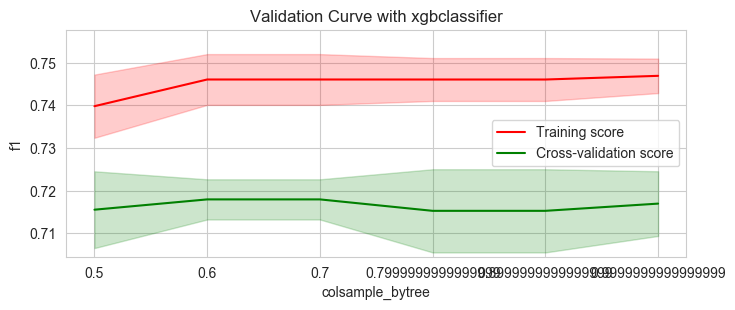

Best cross-validation result (0.72) obtained for colsample_bytree: 0.6


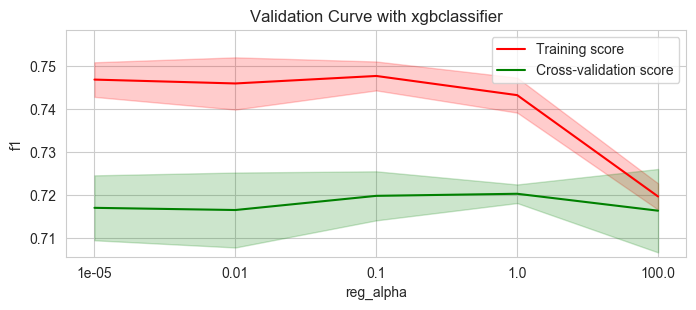

Best cross-validation result (0.72) obtained for reg_alpha: 1.0


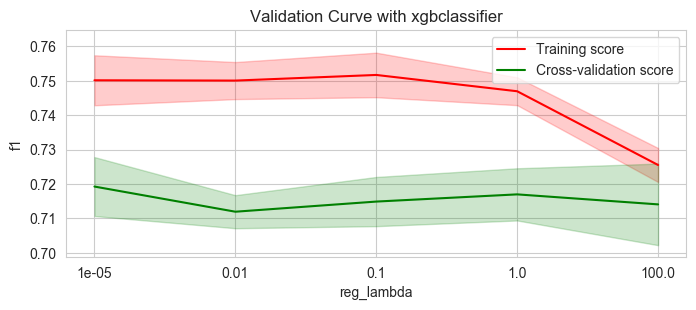

Best cross-validation result (0.72) obtained for reg_lambda: 1e-05


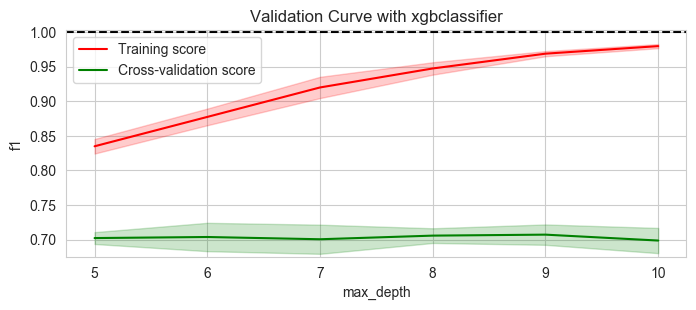

Best cross-validation result (0.71) obtained for max_depth: 9


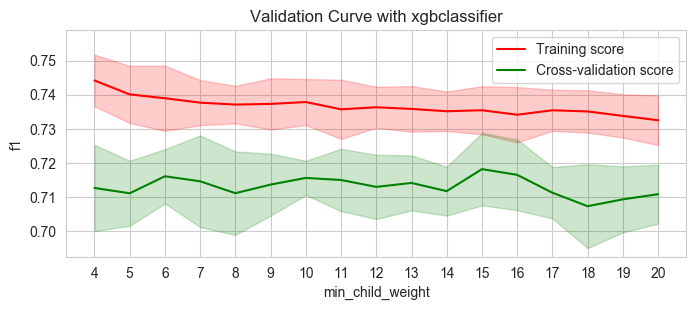

Best cross-validation result (0.72) obtained for min_child_weight: 15


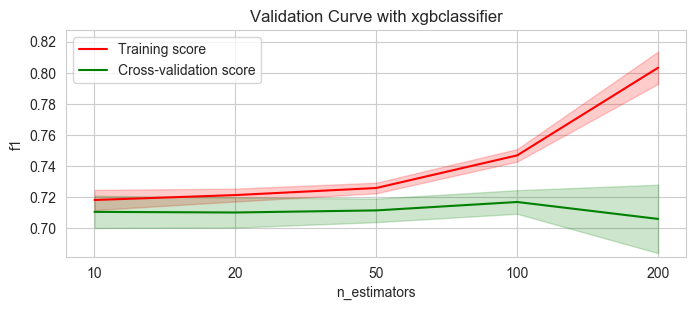

Best cross-validation result (0.72) obtained for n_estimators: 100


In [94]:
xgb_best_params = {}
for param in params_dic:
    parameter = param
    param_range = params_dic[param]
    if param != "C":
        best_param = plot_validation_curve(classifier, classifier_name, parameter, param_range, 
                                           X_train_scaled[top5_feats].values, y_train.values, "f1","norm")
    else:
        best_param = plot_validation_curve(classifier, classifier_name, parameter, param_range, 
                                           X_train_scaled[top5_feats].values, y_train.values, "f1","log")
    
    xgb_best_params[param] = best_param

#### Run Bayesian Optimisation Tuning

##### Tuning Attempt 1 (Use Validation Curve to scope parameter range)
- Cross Validation and Test Results

In [95]:
xgb_best_params

{'learning_rate': 0.1,
 'gamma': 2,
 'subsample': 0.8999999999999999,
 'colsample_bytree': 0.6,
 'reg_alpha': 1.0,
 'reg_lambda': 1e-05,
 'max_depth': 9,
 'min_child_weight': 15,
 'n_estimators': 100}

In [96]:
xgb_param_space1 = {"learning_rate": hp.choice("learning_rate", [0.05, 0.07, 0.1, 0.15, 0.2]),
                   "min_child_weight": scope.int(hp.quniform("min_child_weight", 10,20,1)),
                   "gamma": scope.int(hp.quniform("gamma", 0,4,1)),
                   "subsample": hp.uniform("subsample", 0.6, 1.0),
                   "colsample_bytree": hp.uniform("colsample_by_tree", 0.4, 0.7),
                   "reg_alpha": hp.choice("reg_alpha", [0.1, 1, 100]),
                   "reg_lambda": hp.choice("reg_lambda", [1e-5, 1e-2, 0.1]),
                   "max_depth": scope.int(hp.quniform("max_depth", 7, 11, 1)),
                   "n_estimators": hp.choice("n_estimators", [50, 75, 100, 150, 200])
                  }
bayes_opt(XGBClassifier, xgb_param_space1, X_train_scaled[top5_feats].values, y_train.values, "f1")

100%|██████████| 100/100 [01:04<00:00,  1.55it/s, best loss: -0.718667814403829]

##### Results
Score best parameters:  0.718667814403829
Best parameters:  {'colsample_by_tree': 0.6970729260476218, 'gamma': 3.0, 'learning_rate': 3, 'max_depth': 7.0, 'min_child_weight': 18.0, 'n_estimators': 2, 'reg_alpha': 1, 'reg_lambda': 0, 'subsample': 0.7863244971678923}


In [97]:
xgb_model = XGBClassifier(random_state=1234,
                          colsample_bytree=0.6970729260476218,
                          gamma=3,
                          learning_rate=0.15,
                          max_depth=7,
                          min_child_weight=18,
                          n_estimators=100,
                          reg_alpha=1,
                          reg_lambda=1e-5,
                          subsample=0.7863244971678923
                         )

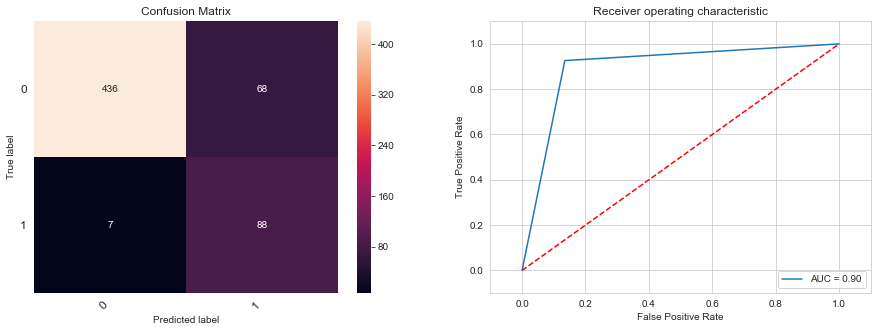

Accuracy:  0.8747913188647746
Sensitivity:  0.9263157894736842
Precision:  0.5641025641025641
f1 Score:  0.701195219123506
ROC_AUC_Score: 0.8956975772765248
MCC:  0.6587282600532297


In [98]:
xgb_model.fit(sm_X_train, sm_y_train)
y_pred_xgb = xgb_model.predict(X_test_scaled[top5_feats].values)
cm = confusion_matrix(y_test, y_pred_xgb)
cm_and_roc(cm, [0, 1], y_test, y_pred_xgb, figsize = (15,5), fontsize=12)

print ("Accuracy: ", accuracy_score(y_test, y_pred_xgb))
print("Sensitivity: ", recall_score(y_test, y_pred_xgb))
print("Precision: ", precision_score(y_test, y_pred_xgb))
print ("f1 Score: ", f1_score(y_test, y_pred_xgb))
print("ROC_AUC_Score:", roc_auc_score(y_test, y_pred_xgb))
print("MCC: ", matthews_corrcoef(y_test, y_pred_xgb))

##### Tuning Attempt 2 (Use Attempt 1 to scope Parameter Range)
- Cross Validation and Test Results

In [99]:
xgb_param_space2 = {"learning_rate": hp.choice("learning_rate", [0.1, 0.15, 0.2, 0.25, 0.3]),
                   "min_child_weight": scope.int(hp.quniform("min_child_weight", 18,25,1)),
                   "gamma": scope.int(hp.quniform("gamma", 3,7,1)),
                   "subsample": hp.uniform("subsample", 0.7, 1.0),
                   "colsample_bytree": hp.uniform("colsample_by_tree", 0.6, 0.7),
                   "reg_alpha": hp.choice("reg_alpha", [0.1, 0.5, 1, 1.5]),
                   "reg_lambda": hp.choice("reg_lambda", [1e-10, 1e-7, 1e-5, 1e-2]),
                   "max_depth": scope.int(hp.quniform("max_depth", 3, 7, 1)),
                   "n_estimators": hp.choice("n_estimators", [50, 75, 100, 150, 200])
                  }
bayes_opt(XGBClassifier, xgb_param_space2, X_train_scaled[top5_feats].values, y_train.values, "f1")

100%|██████████| 100/100 [00:56<00:00,  1.77it/s, best loss: -0.7197545178123297]

##### Results
Score best parameters:  0.7197545178123297
Best parameters:  {'colsample_by_tree': 0.6653997176343666, 'gamma': 5.0, 'learning_rate': 4, 'max_depth': 5.0, 'min_child_weight': 19.0, 'n_estimators': 0, 'reg_alpha': 3, 'reg_lambda': 3, 'subsample': 0.7680129070567101}


In [100]:
xgb_model = XGBClassifier(random_state=1234,
                          colsample_bytree=0.6653997176343666,
                          gamma=5,
                          learning_rate=0.3,
                          max_depth=5,
                          min_child_weight=19,
                          n_estimators=50,
                          reg_alpha=1.5,
                          reg_lambda=1e-2,
                          subsample=0.7680129070567101
                         )

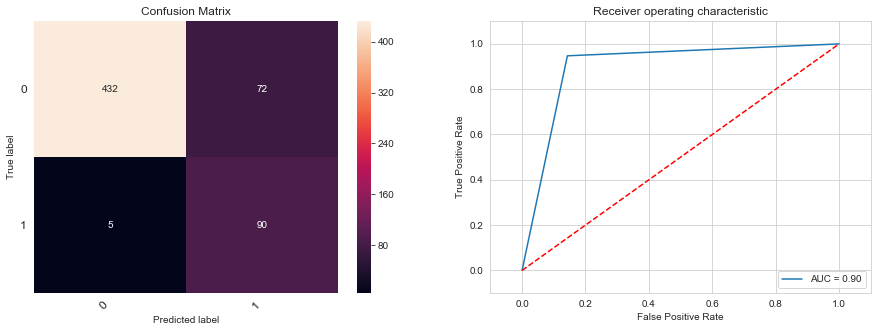

Accuracy:  0.8714524207011686
Sensitivity:  0.9473684210526315
Precision:  0.5555555555555556
f1 Score:  0.7003891050583657
ROC_AUC_Score: 0.9022556390977443
MCC:  0.6616235905524196


In [101]:
xgb_model.fit(sm_X_train, sm_y_train)
y_pred_xgb = xgb_model.predict(X_test_scaled[top5_feats].values)
cm = confusion_matrix(y_test, y_pred_xgb)
cm_and_roc(cm, [0, 1], y_test, y_pred_xgb, figsize = (15,5), fontsize=12)

print ("Accuracy: ", accuracy_score(y_test, y_pred_xgb))
print("Sensitivity: ", recall_score(y_test, y_pred_xgb))
print("Precision: ", precision_score(y_test, y_pred_xgb))
print ("f1 Score: ", f1_score(y_test, y_pred_xgb))
print("ROC_AUC_Score:", roc_auc_score(y_test, y_pred_xgb))
print("MCC: ", matthews_corrcoef(y_test, y_pred_xgb))

##### Tuning Attempt 3 (Use Attempt 2 to scope Parameter Range)
- Cross Validation and Test Results

In [102]:
xgb_param_space3 = {"learning_rate": hp.choice("learning_rate", [0.3, 0.35, 0.4, 0.45, 0.5]),
                   "min_child_weight": scope.int(hp.quniform("min_child_weight", 19,25,1)),
                   "gamma": scope.int(hp.quniform("gamma", 5,10,1)),
                   "subsample": hp.uniform("subsample", 0.7, 1.0),
                   "colsample_bytree": hp.uniform("colsample_by_tree", 0.6, 0.8),
                   "reg_alpha": hp.choice("reg_alpha", [1.5, 2, 2.5, 3]),
                   "reg_lambda": hp.choice("reg_lambda", [1e-2, 0.1, 1]),
                   "max_depth": scope.int(hp.quniform("max_depth", 5, 10, 1)),
                   "n_estimators": hp.choice("n_estimators", [50, 75, 100, 150, 200])
                  }
bayes_opt(XGBClassifier, xgb_param_space3, X_train_scaled[top5_feats].values, y_train.values, "f1")

100%|██████████| 100/100 [01:05<00:00,  1.53it/s, best loss: -0.7199053973231594]

##### Results
Score best parameters:  0.7199053973231594
Best parameters:  {'colsample_by_tree': 0.7465937617317032, 'gamma': 7.0, 'learning_rate': 2, 'max_depth': 6.0, 'min_child_weight': 24.0, 'n_estimators': 4, 'reg_alpha': 0, 'reg_lambda': 2, 'subsample': 0.7069236585610036}


In [103]:
xgb_model = XGBClassifier(random_state=1234,
                          colsample_bytree=0.7465937617317032,
                          gamma=7,
                          learning_rate=0.4,
                          max_depth=6,
                          min_child_weight=24,
                          n_estimators=200,
                          reg_alpha=1.5,
                          reg_lambda=1,
                          subsample=0.7069236585610036
                         )

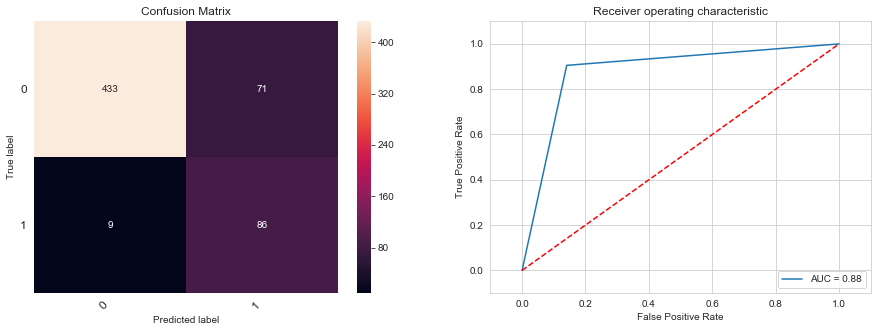

Accuracy:  0.8664440734557596
Sensitivity:  0.9052631578947369
Precision:  0.5477707006369427
f1 Score:  0.6825396825396826
ROC_AUC_Score: 0.8821950710108607
MCC:  0.6349378067975806


In [104]:
xgb_model.fit(sm_X_train, sm_y_train)
y_pred_xgb = xgb_model.predict(X_test_scaled[top5_feats].values)
cm = confusion_matrix(y_test, y_pred_xgb)
cm_and_roc(cm, [0, 1], y_test, y_pred_xgb, figsize = (15,5), fontsize=12)

print ("Accuracy: ", accuracy_score(y_test, y_pred_xgb))
print("Sensitivity: ", recall_score(y_test, y_pred_xgb))
print("Precision: ", precision_score(y_test, y_pred_xgb))
print ("f1 Score: ", f1_score(y_test, y_pred_xgb))
print("ROC_AUC_Score:", roc_auc_score(y_test, y_pred_xgb))
print("MCC: ", matthews_corrcoef(y_test, y_pred_xgb))

### SVM
- gamma, C, kernel

#### Define Parameters and Parameter Range

In [105]:
params_dic = {
    "gamma": np.array([0.01,0.05,0.07,0.1,1]),
    "C": np.array([0.001, 0.01, 0.1, 1, 10]),
    "kernel": np.array(["linear", "poly", "rbf", "sigmoid"])    
}

In [106]:
classifier = SVC(random_state=1234)
classifier_name = "svc"

#### Run Validation Curve
- Identify the value of parameter that gives the best score

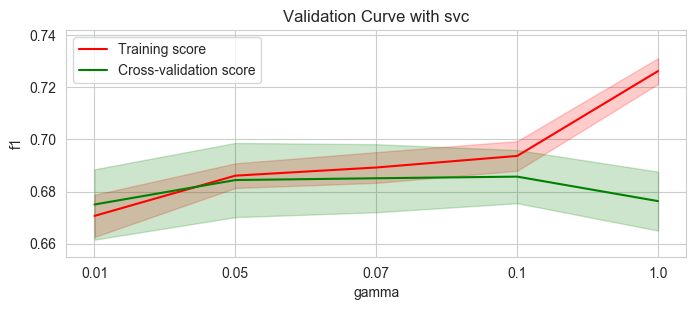

Best cross-validation result (0.69) obtained for gamma: 0.1


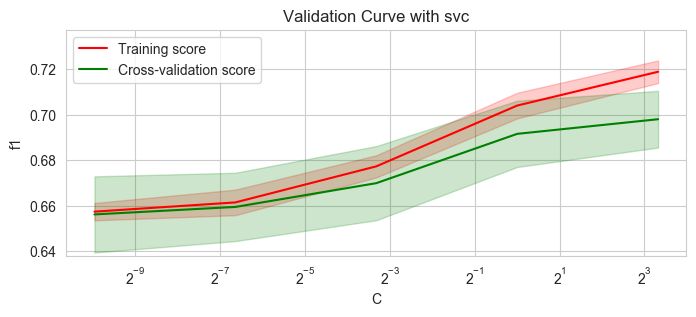

Best cross-validation result (0.70) obtained for C: 10.0


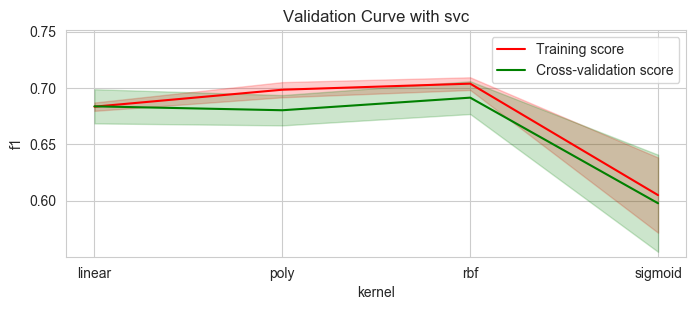

Best cross-validation result (0.69) obtained for kernel: rbf


In [107]:
svm_best_params = {}
for param in params_dic:
    parameter = param
    param_range = params_dic[param]
    if param != "C":
        best_param = plot_validation_curve(classifier, classifier_name, parameter, param_range, 
                                           X_train_scaled[top5_feats].values, y_train.values, "f1","norm")
    else:
        best_param = plot_validation_curve(classifier, classifier_name, parameter, param_range, 
                                           X_train_scaled[top5_feats].values, y_train.values, "f1","log")
    
    svm_best_params[param] = best_param

#### Run Bayesian Optimisation Tuning

##### Tuning Attempt 1 (Use Validation Curve to scope Parameter Range)
- Cross Validation and Test Results

In [108]:
svc_param_space1 = {"probability": hp.choice("probability", [True]),
                   "gamma" : hp.choice("gamma", [0.05,0.07,0.08,0.1,0.5,1]),
                   "C": hp.choice("C", [0.1, 1, 10,50,100]),
                   "kernel": hp.choice("kernel", ["linear", "rbf"])
                  }

bayes_opt(SVC,svc_param_space1,X_train_scaled[top5_feats].values, y_train.values,"f1")

100%|██████████| 100/100 [08:33<00:00,  5.13s/it, best loss: -0.7056837999299926]

##### Results
Score best parameters:  0.7056837999299926
Best parameters:  {'C': 4, 'gamma': 2, 'kernel': 1, 'probability': 0}


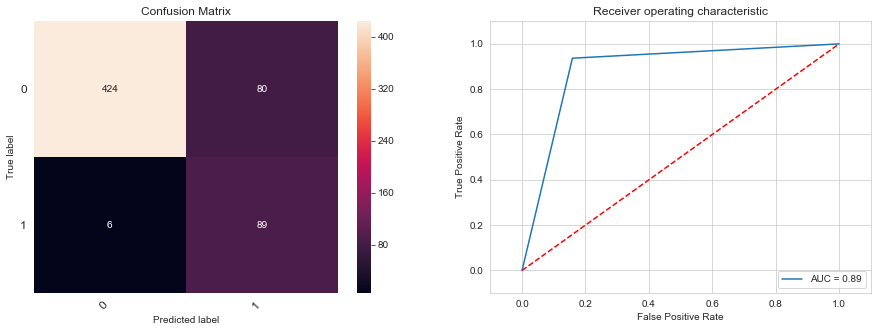

Accuracy:  0.8564273789649416
Sensitivity:  0.9368421052631579
Precision:  0.5266272189349113
f1 Score:  0.6742424242424243
ROC_AUC_Score: 0.8890559732664995
MCC:  0.6315992039454837


In [109]:
svm = SVC(C=100,gamma=0.08,kernel='rbf',probability=True,random_state=1234)
svm.fit(sm_X_train, sm_y_train)
y_pred_svm = svm.predict(X_test_scaled[top5_feats].values)
cm = confusion_matrix(y_test, y_pred_svm)
cm_and_roc(cm, [0, 1], y_test, y_pred_svm, figsize = (15,5), fontsize=12)

print ("Accuracy: ", accuracy_score(y_test, y_pred_svm))
print("Sensitivity: ", recall_score(y_test, y_pred_svm))
print("Precision: ", precision_score(y_test, y_pred_svm))
print ("f1 Score: ", f1_score(y_test, y_pred_svm))
print("ROC_AUC_Score:", roc_auc_score(y_test, y_pred_svm))
print("MCC: ", matthews_corrcoef(y_test, y_pred_svm))

##### Tuning Attempt 2 (Use Attempt 1 to scope Parameter Range)
- Cross Validation and Test Results

In [110]:
svc_param_space2 = {"probability": hp.choice("probability", [True]),
                   "gamma" : hp.choice("gamma", [0.07,0.075,0.08,0.09]),
                   "C": hp.choice("C", [100,125,150,200]),
                   "kernel": hp.choice("kernel", ["linear", "rbf"])
                  }

bayes_opt(SVC,svc_param_space2,X_train_scaled[top5_feats].values, y_train.values,"f1")

100%|██████████| 100/100 [21:07<00:00, 12.68s/it, best loss: -0.7070631842438821]

##### Results
Score best parameters:  0.7070631842438821
Best parameters:  {'C': 1, 'gamma': 1, 'kernel': 1, 'probability': 0}


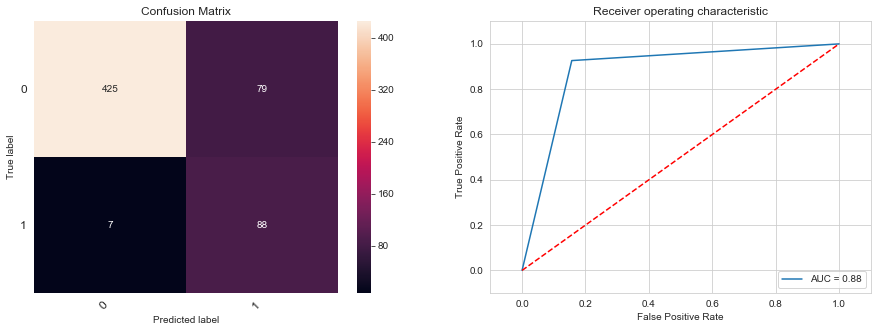

Accuracy:  0.8564273789649416
Sensitivity:  0.9263157894736842
Precision:  0.5269461077844312
f1 Score:  0.6717557251908398
ROC_AUC_Score: 0.8847848788638263
MCC:  0.6269385202471165


In [111]:
svm = SVC(C=125,gamma=0.075,kernel='rbf',probability=True,random_state=1234)
svm.fit(sm_X_train, sm_y_train)
y_pred_svm = svm.predict(X_test_scaled[top5_feats].values)
cm = confusion_matrix(y_test, y_pred_svm)
cm_and_roc(cm, [0, 1], y_test, y_pred_svm, figsize = (15,5), fontsize=12)

print ("Accuracy: ", accuracy_score(y_test, y_pred_svm))
print("Sensitivity: ", recall_score(y_test, y_pred_svm))
print("Precision: ", precision_score(y_test, y_pred_svm))
print ("f1 Score: ", f1_score(y_test, y_pred_svm))
print("ROC_AUC_Score:", roc_auc_score(y_test, y_pred_svm))
print("MCC: ", matthews_corrcoef(y_test, y_pred_svm))


##### Tuning Attempt 3 (Use Attempt 2 to scope Parameter Range)
- Cross Validation and Results

In [112]:
svc_param_space3 = {"probability": hp.choice("probability", [True]),
                   "gamma" : hp.choice("gamma", [0.07,0.072,0.075,0.078,0.08,0.85]),
                   "C": hp.choice("C", [10,30,50,120,125,150,300]),
                   "kernel": hp.choice("kernel", ["rbf"])
                  }

bayes_opt(SVC,svc_param_space3,X_train_scaled[top5_feats].values, y_train.values,"f1")

100%|██████████| 100/100 [05:34<00:00,  3.35s/it, best loss: -0.7070631842438821]

##### Results
Score best parameters:  0.7070631842438821
Best parameters:  {'C': 4, 'gamma': 2, 'kernel': 0, 'probability': 0}


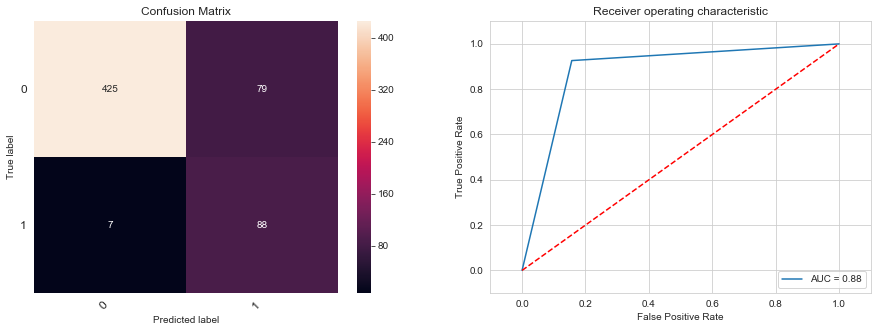

Accuracy:  0.8564273789649416
Sensitivity:  0.9263157894736842
Precision:  0.5269461077844312
f1 Score:  0.6717557251908398
ROC_AUC_Score: 0.8847848788638263
MCC:  0.6269385202471165


In [113]:
svm = SVC(C=125,gamma=0.075,kernel='rbf',probability=True,random_state=1234)
svm.fit(sm_X_train, sm_y_train)
y_pred_svm = svm.predict(X_test_scaled[top5_feats].values)
cm = confusion_matrix(y_test, y_pred_svm)
cm_and_roc(cm, [0, 1], y_test, y_pred_svm, figsize = (15,5), fontsize=12)

print ("Accuracy: ", accuracy_score(y_test, y_pred_svm))
print("Sensitivity: ", recall_score(y_test, y_pred_svm))
print("Precision: ", precision_score(y_test, y_pred_svm))
print ("f1 Score: ", f1_score(y_test, y_pred_svm))
print("ROC_AUC_Score:", roc_auc_score(y_test, y_pred_svm))
print("MCC: ", matthews_corrcoef(y_test, y_pred_svm))


### MLP

- hidden_layer_sizes, activation, solver, learning_rate, alpha, batch_size

#### Define Parameters and Parameter Range

In [114]:
params_dic = {
    "hidden_layer_sizes": np.array([(50,50,50), (50,100,50), (100,)]),
    "activation": np.array(['logistic', 'tanh', 'relu']),
    "solver": np.array(['lbfgs', 'sgd', 'adam']),
    "learning_rate": np.array(['constant','adaptive']),
    "alpha": np.array([0.0001, 0.001, 0.01, 0.05]),
    "batch_size": np.array([32,64,128,256,512])
}

In [115]:
classifier = MLPClassifier(random_state=1234)
classifier_name = "mlpclassifier"

#### Run Validation Curve
- Identify the value for each parameter that gives the best score

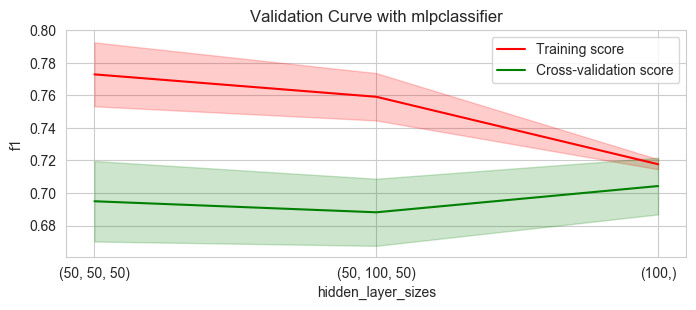

Best cross-validation result (0.70) obtained for hidden_layer_sizes: (100,)


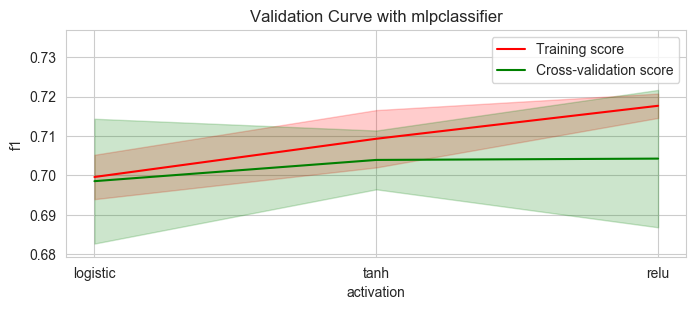

Best cross-validation result (0.70) obtained for activation: relu


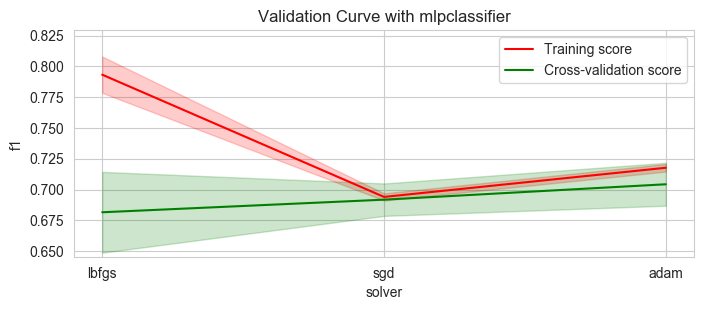

Best cross-validation result (0.70) obtained for solver: adam


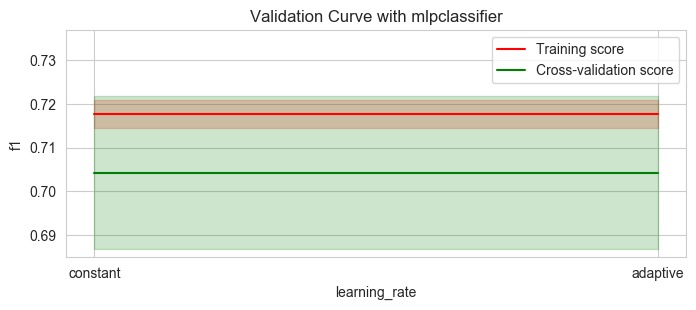

Best cross-validation result (0.70) obtained for learning_rate: constant


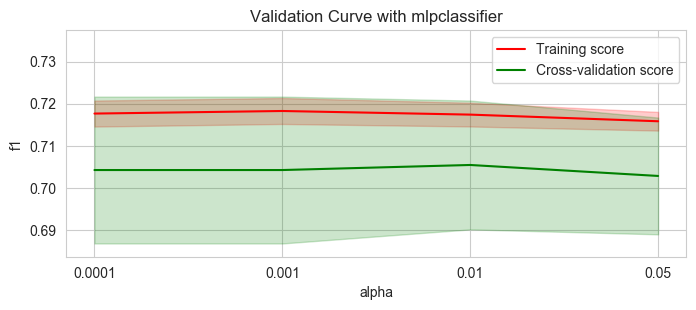

Best cross-validation result (0.71) obtained for alpha: 0.01


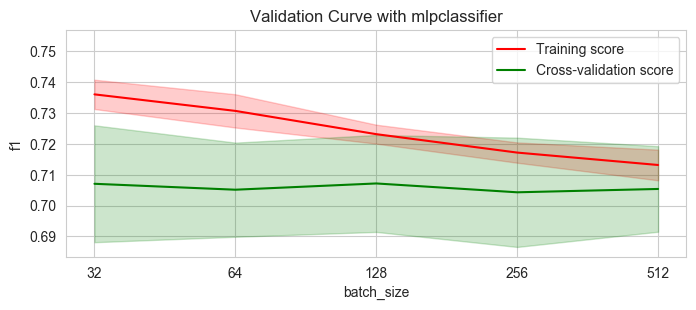

Best cross-validation result (0.71) obtained for batch_size: 128


In [116]:
mlp_best_params = {}
for param in params_dic:
    parameter = param
    param_range = params_dic[param]
    if param != "C":
        best_param = plot_validation_curve(classifier, classifier_name, parameter, param_range, 
                                           X_train_scaled[top5_feats].values, y_train.values, "f1","norm")
    else:
        best_param = plot_validation_curve(classifier, classifier_name, parameter, param_range, 
                                           X_train_scaled[top5_feats].values, y_train.values, "f1","log")
    
    mlp_best_params[param] = best_param

### Decision Tree

#### Define Parameters and Parameter Range

In [117]:
params_dic = {
    "max_depth": np.arange(5,16,1),
    "max_features": np.arange(3,6,1),
    "criterion": np.array(["gini", "entropy"]),
    "min_samples_split": np.arange(5,51,10),
    "min_samples_leaf": np.arange(5,51,5),
    "min_impurity_decrease": np.array([0,1e-07,1e-05,0.001])
}

In [118]:
classifier = DecisionTreeClassifier(random_state=1234)
classifier_name = "decisiontreeclassifier"

#### Run Validation Curve
- Identify the value for each parameter that gives the best score

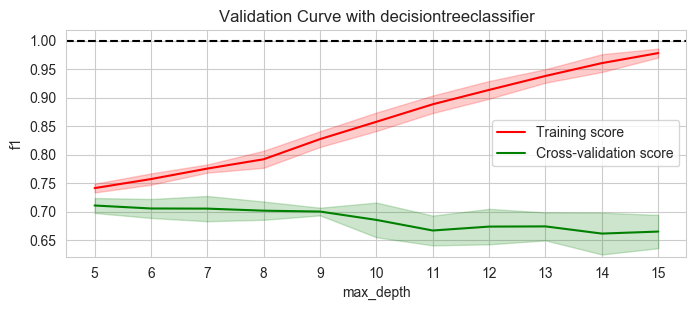

Best cross-validation result (0.71) obtained for max_depth: 5


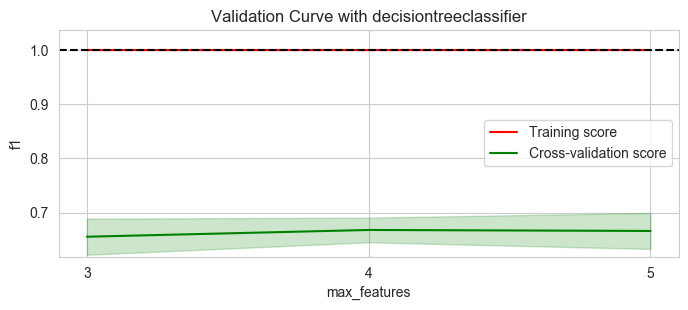

Best cross-validation result (0.67) obtained for max_features: 4


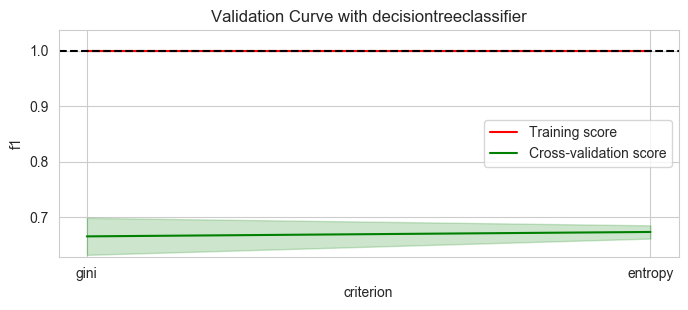

Best cross-validation result (0.67) obtained for criterion: entropy


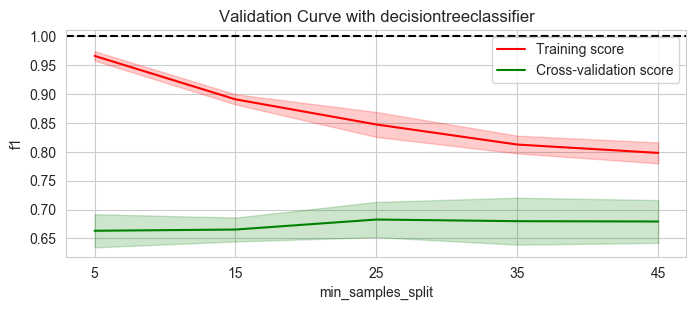

Best cross-validation result (0.68) obtained for min_samples_split: 25


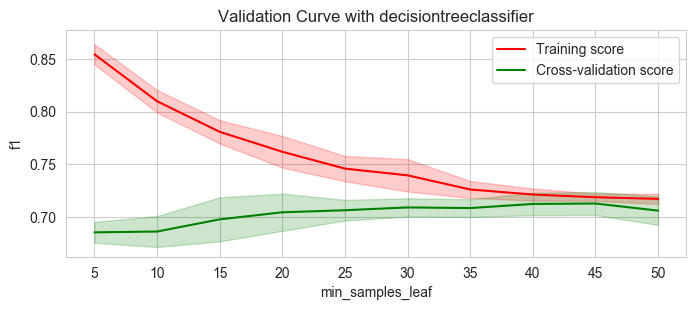

Best cross-validation result (0.71) obtained for min_samples_leaf: 45


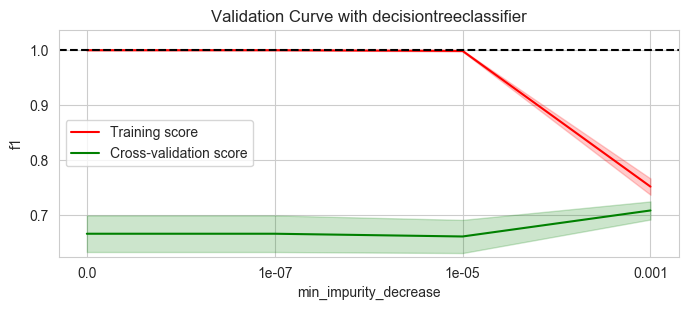

Best cross-validation result (0.71) obtained for min_impurity_decrease: 0.001


In [119]:
dt_best_params = {}
for param in params_dic:
    parameter = param
    param_range = params_dic[param]
    if param != "C":
        best_param = plot_validation_curve(classifier, classifier_name, parameter, param_range, 
                                           X_train_scaled[top5_feats].values, y_train.values, "f1","norm")
    else:
        best_param = plot_validation_curve(classifier, classifier_name, parameter, param_range, 
                                           X_train_scaled[top5_feats].values, y_train.values, "f1","log")
    
    dt_best_params[param] = best_param

#### Run Bayesian Optimisation Tuning 

##### Tuning Attempt 1 (Use Validation Curve to scope Parameter Range)
- Cross Validation and Test Results

In [120]:
DT_param_space1 = {"max_depth": scope.int(hp.quniform('max_depth', 3, 10, 1)),
              "max_features": scope.int(hp.quniform('max_features', 3, 5, 1)),
                   "criterion": hp.choice("criterion", ["gini","entropy"]),
                      "min_samples_split": scope.int(hp.quniform("min_samples_split", 5, 50, 10)),
              "min_samples_leaf":  scope.int(hp.quniform("min_samples_leaf", 30,60,5)),
                 "min_impurity_decrease": hp.choice("min_impurity_decrease",[0,1e-05,0.001,0.005,0.01])}

bayes_opt(DecisionTreeClassifier,DT_param_space1,X_train_scaled[top5_feats].values, y_train.values,"f1")

100%|██████████| 100/100 [00:07<00:00, 13.03it/s, best loss: -0.7161961029299752]

##### Results
Score best parameters:  0.7161961029299752
Best parameters:  {'criterion': 1, 'max_depth': 7.0, 'max_features': 3.0, 'min_impurity_decrease': 2, 'min_samples_leaf': 30.0, 'min_samples_split': 10.0}


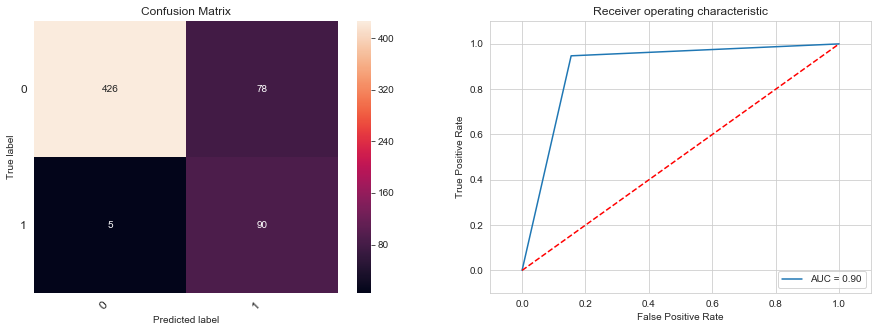

Accuracy:  0.8614357262103506
Sensitivity:  0.9473684210526315
Precision:  0.5357142857142857
f1 Score:  0.6844106463878327
ROC_AUC_Score: 0.8963032581453634
MCC:  0.6445274722930806


In [121]:
dt = DecisionTreeClassifier(criterion='entropy', max_depth=7,max_features=3,min_impurity_decrease=0.001,min_samples_leaf=30,min_samples_split=10,random_state=1234)
dt.fit(sm_X_train, sm_y_train)
y_pred_dt = dt.predict(X_test_scaled[top5_feats].values)
cm = confusion_matrix(y_test, y_pred_dt)
cm_and_roc(cm, [0, 1], y_test, y_pred_dt, figsize = (15,5), fontsize=12)

print ("Accuracy: ", accuracy_score(y_test, y_pred_dt))
print("Sensitivity: ", recall_score(y_test, y_pred_dt))
print("Precision: ", precision_score(y_test, y_pred_dt))
print ("f1 Score: ", f1_score(y_test, y_pred_dt))
print("ROC_AUC_Score:", roc_auc_score(y_test, y_pred_dt))
print("MCC: ", matthews_corrcoef(y_test, y_pred_dt))

##### Tuning Attempt 2 (Use Attempt 1 to scope Parameter Range)
- Cross Validation and Test Results

In [122]:
DT_param_space2 = {"max_depth": scope.int(hp.quniform('max_depth', 5, 15, 1)),
              "max_features": scope.int(hp.quniform('max_features', 3, 5, 1)),
                   "criterion": hp.choice("criterion", ["gini","entropy"]),
                      "min_samples_split": scope.int(hp.quniform("min_samples_split", 5, 50, 10)),
              "min_samples_leaf":  scope.int(hp.quniform("min_samples_leaf", 5,50,5)),
                 "min_impurity_decrease": hp.choice("min_impurity_decrease",[0,1e-05,0.001,0.005,0.01])}

bayes_opt(DecisionTreeClassifier,DT_param_space2,X_train_scaled[top5_feats].values, y_train.values,"f1")

100%|██████████| 100/100 [00:07<00:00, 12.95it/s, best loss: -0.7170286021332207]

##### Results
Score best parameters:  0.7170286021332207
Best parameters:  {'criterion': 0, 'max_depth': 5.0, 'max_features': 3.0, 'min_impurity_decrease': 1, 'min_samples_leaf': 40.0, 'min_samples_split': 30.0}


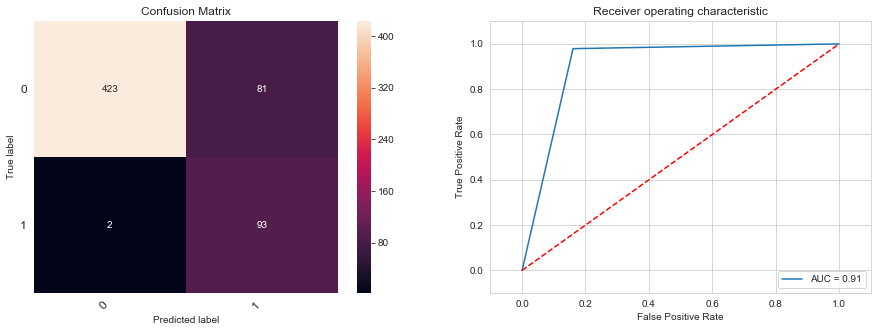

Accuracy:  0.8614357262103506
Sensitivity:  0.9789473684210527
Precision:  0.5344827586206896
f1 Score:  0.6914498141263941
ROC_AUC_Score: 0.9091165413533835
MCC:  0.658392714582506


In [123]:
dt = DecisionTreeClassifier(criterion='gini', max_depth=5,max_features=3,min_impurity_decrease=1e-05,min_samples_leaf=40,min_samples_split=30,random_state=1234)
dt.fit(sm_X_train, sm_y_train)
y_pred_dt = dt.predict(X_test_scaled[top5_feats].values)
cm = confusion_matrix(y_test, y_pred_dt)
cm_and_roc(cm, [0, 1], y_test, y_pred_dt, figsize = (15,5), fontsize=12)

print ("Accuracy: ", accuracy_score(y_test, y_pred_dt))
print("Sensitivity: ", recall_score(y_test, y_pred_dt))
print("Precision: ", precision_score(y_test, y_pred_dt))
print ("f1 Score: ", f1_score(y_test, y_pred_dt))
print("ROC_AUC_Score:", roc_auc_score(y_test, y_pred_dt))
print("MCC: ", matthews_corrcoef(y_test, y_pred_dt))

##### Tuning Attempt 3 (Use Attempt 2 to scope Parameter Range)
- Cross Validation and Test Results

In [124]:
DT_param_space3 = {"max_depth": scope.int(hp.quniform('max_depth', 3, 15, 1)),
              "max_features": scope.int(hp.quniform('max_features', 3, 5, 1)),
                   "criterion": hp.choice("criterion", ["gini","entropy"]),
                      "min_samples_split": scope.int(hp.quniform("min_samples_split", 5, 50, 10)),
              "min_samples_leaf":  scope.int(hp.quniform("min_samples_leaf", 5,50,5)),
                 "min_impurity_decrease": hp.choice("min_impurity_decrease",[0,1e-07,1e-05,0.001,0.005])}

bayes_opt(DecisionTreeClassifier,DT_param_space3,X_train_scaled[top5_feats].values, y_train.values,"f1")

100%|██████████| 100/100 [00:07<00:00, 13.72it/s, best loss: -0.7181431479565417]

##### Results
Score best parameters:  0.7181431479565417
Best parameters:  {'criterion': 0, 'max_depth': 7.0, 'max_features': 4.0, 'min_impurity_decrease': 1, 'min_samples_leaf': 25.0, 'min_samples_split': 20.0}


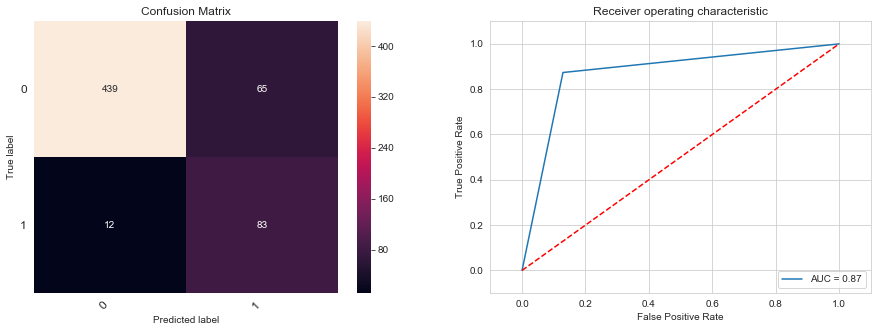

Accuracy:  0.8714524207011686
Sensitivity:  0.8736842105263158
Precision:  0.5608108108108109
f1 Score:  0.6831275720164609
ROC_AUC_Score: 0.8723579782790309
MCC:  0.6307374261211998


In [125]:
dt = DecisionTreeClassifier(criterion='gini', max_depth=7,max_features=4,min_impurity_decrease=1e-07,min_samples_leaf=25,min_samples_split=20,random_state=1234)
dt.fit(sm_X_train, sm_y_train)
y_pred_dt = dt.predict(X_test_scaled[top5_feats].values)
cm = confusion_matrix(y_test, y_pred_dt)
cm_and_roc(cm, [0, 1], y_test, y_pred_dt, figsize = (15,5), fontsize=12)

print ("Accuracy: ", accuracy_score(y_test, y_pred_dt))
print("Sensitivity: ", recall_score(y_test, y_pred_dt))
print("Precision: ", precision_score(y_test, y_pred_dt))
print ("f1 Score: ", f1_score(y_test, y_pred_dt))
print("ROC_AUC_Score:", roc_auc_score(y_test, y_pred_dt))
print("MCC: ", matthews_corrcoef(y_test, y_pred_dt))

##### Tuning Attempt 4 (Use Attempt 3 to scope Parameter Range)
- Cross Validation and Test Resuts

In [126]:
DT_param_space4 = {"max_depth": scope.int(hp.quniform('max_depth', 3, 15, 1)),
              "max_features": scope.int(hp.quniform('max_features', 3, 5, 1)),
                   "criterion": hp.choice("criterion", ["gini"]),
                      "min_samples_split": scope.int(hp.quniform("min_samples_split", 5, 80, 10)),
              "min_samples_leaf":  scope.int(hp.quniform("min_samples_leaf", 5,50,5)),
                 "min_impurity_decrease": hp.choice("min_impurity_decrease",[0,1e-07,1e-06,1e-05,1e-03,0.001])}

bayes_opt(DecisionTreeClassifier,DT_param_space4,X_train_scaled[top5_feats].values, y_train.values,"f1")

100%|██████████| 100/100 [00:07<00:00, 13.82it/s, best loss: -0.7205875894126288]

##### Results
Score best parameters:  0.7205875894126288
Best parameters:  {'criterion': 0, 'max_depth': 11.0, 'max_features': 3.0, 'min_impurity_decrease': 1, 'min_samples_leaf': 20.0, 'min_samples_split': 80.0}


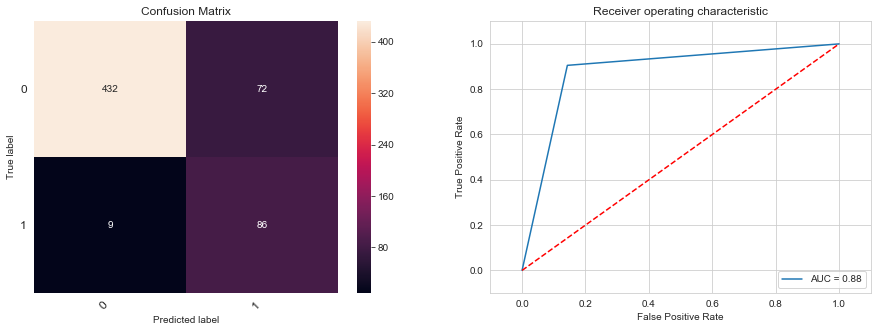

Accuracy:  0.8647746243739566
Sensitivity:  0.9052631578947369
Precision:  0.5443037974683544
f1 Score:  0.6798418972332017
ROC_AUC_Score: 0.8812030075187971
MCC:  0.6319977711735533


In [127]:
dt = DecisionTreeClassifier(criterion='gini', max_depth=11,max_features=3,min_impurity_decrease=1e-07,min_samples_leaf=20,min_samples_split=80,random_state=1234)
dt.fit(sm_X_train, sm_y_train)
y_pred_dt = dt.predict(X_test_scaled[top5_feats].values)
cm = confusion_matrix(y_test, y_pred_dt)
cm_and_roc(cm, [0, 1], y_test, y_pred_dt, figsize = (15,5), fontsize=12)

print ("Accuracy: ", accuracy_score(y_test, y_pred_dt))
print("Sensitivity: ", recall_score(y_test, y_pred_dt))
print("Precision: ", precision_score(y_test, y_pred_dt))
print ("f1 Score: ", f1_score(y_test, y_pred_dt))
print("ROC_AUC_Score:", roc_auc_score(y_test, y_pred_dt))
print("MCC: ", matthews_corrcoef(y_test, y_pred_dt))

##### Tuning Attempt 5 (Use Attempt 4 to scope Parameter Range)
- Cross Validationa and Test Results

In [128]:
DT_param_space5 = {"max_depth": scope.int(hp.quniform('max_depth', 3, 15, 1)),
              "max_features": scope.int(hp.quniform('max_features', 3, 5, 1)),
                   "criterion": hp.choice("criterion", ["gini"]),
                      "min_samples_split": scope.int(hp.quniform("min_samples_split", 5, 100, 10)),
              "min_samples_leaf":  scope.int(hp.quniform("min_samples_leaf", 5,50,5)),
                 "min_impurity_decrease": hp.choice("min_impurity_decrease",[0,1e-08,1e-07,1e-06,1e-05,1e-04,1e-03])}

bayes_opt(DecisionTreeClassifier,DT_param_space5,X_train_scaled[top5_feats].values, y_train.values,"f1")

100%|██████████| 100/100 [00:07<00:00, 13.96it/s, best loss: -0.7182416798235789]

##### Results
Score best parameters:  0.7182416798235789
Best parameters:  {'criterion': 0, 'max_depth': 10.0, 'max_features': 3.0, 'min_impurity_decrease': 5, 'min_samples_leaf': 15.0, 'min_samples_split': 40.0}


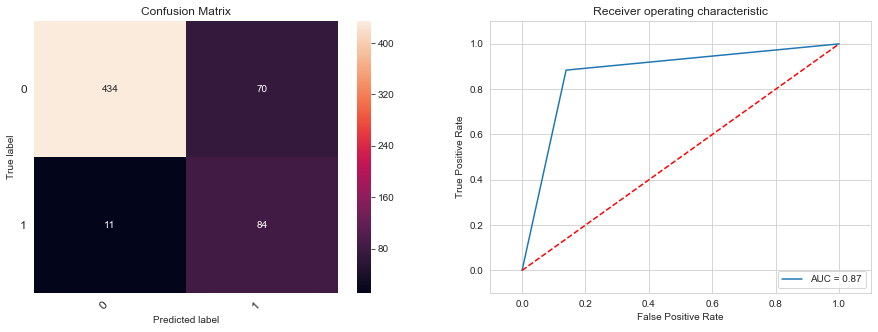

Accuracy:  0.8647746243739566
Sensitivity:  0.8842105263157894
Precision:  0.5454545454545454
f1 Score:  0.6746987951807227
ROC_AUC_Score: 0.8726608187134504
MCC:  0.6229890801891862


In [129]:
dt = DecisionTreeClassifier(criterion='gini', max_depth=10,max_features=3,min_impurity_decrease=1e-04,min_samples_leaf=15,min_samples_split=40,random_state=1234)
dt.fit(sm_X_train, sm_y_train)
y_pred_dt = dt.predict(X_test_scaled[top5_feats].values)
cm = confusion_matrix(y_test, y_pred_dt)
cm_and_roc(cm, [0, 1], y_test, y_pred_dt, figsize = (15,5), fontsize=12)

print ("Accuracy: ", accuracy_score(y_test, y_pred_dt))
print("Sensitivity: ", recall_score(y_test, y_pred_dt))
print("Precision: ", precision_score(y_test, y_pred_dt))
print ("f1 Score: ", f1_score(y_test, y_pred_dt))
print("ROC_AUC_Score:", roc_auc_score(y_test, y_pred_dt))
print("MCC: ", matthews_corrcoef(y_test, y_pred_dt))

### Bagging

#### Define Parameters and Parameter Range

In [130]:
DT = DecisionTreeClassifier(criterion="gini",
                            max_depth=11,
                            max_features=3,
                            min_impurity_decrease=1e-07,
                            min_samples_leaf=20,
                            min_samples_split=80,
                            random_state=1234)

In [131]:
params_dic = {
    #"max_features": np.arange(3,6,1),
    "bootstrap": np.array([False, True]),
    "n_estimators": np.array([10,20,30,50,100])
}

In [132]:
classifier = BaggingClassifier(DT, random_state=1234)
classifier_name = "baggingclassifier"

#### Run Validation Curve
- Identify the value for each parameter that gives the best score

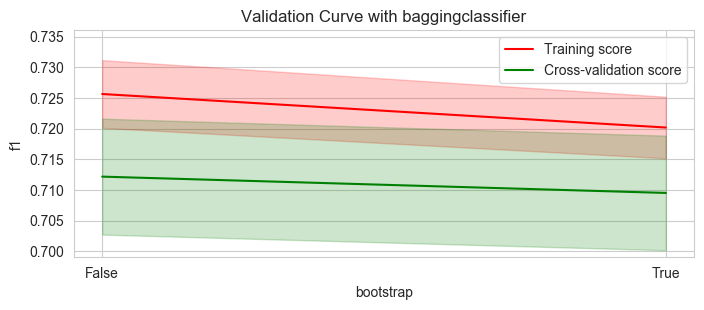

Best cross-validation result (0.71) obtained for bootstrap: False


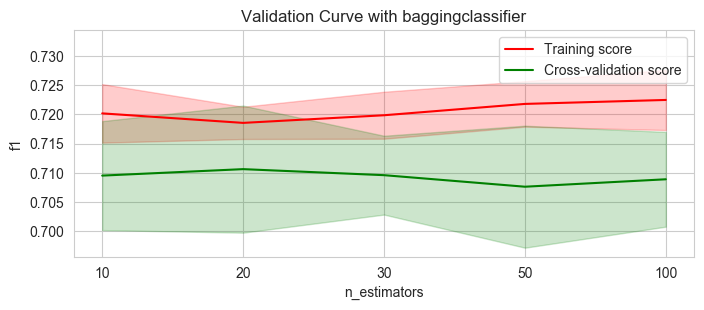

Best cross-validation result (0.71) obtained for n_estimators: 20


In [133]:
bag_best_params = {}
for param in params_dic:
    parameter = param
    param_range = params_dic[param]
    if param != "C":
        best_param = plot_validation_curve(classifier, classifier_name, parameter, param_range, 
                                           X_train_scaled[top5_feats].values, y_train.values, "f1","norm")
    else:
        best_param = plot_validation_curve(classifier, classifier_name, parameter, param_range, 
                                           X_train_scaled[top5_feats].values, y_train.values, "f1","log")
    
    bag_best_params[param] = best_param

#### Run Bayesian Optimisation Tuning

##### Tuning Attempt 1 (Use Validation Curve to scope Parameter Range)
- Cross Validation and Test Results

In [134]:
bagging_param_space1 = {"bootstrap": hp.choice("bootstrap", [False,True]),
                      "n_estimators" : hp.choice("n_estimators", [10,15,20,25,30]),
                      "n_jobs":hp.choice("n_jobs", [3]),
                      "base_estimator":hp.choice("base_estimator", [DT])}

bayes_opt(BaggingClassifier,bagging_param_space1,X_train_scaled[top5_feats].values, y_train.values,"f1")

100%|██████████| 100/100 [00:23<00:00,  4.32it/s, best loss: -0.7121844241414534]

##### Results
Score best parameters:  0.7121844241414534
Best parameters:  {'base_estimator': 0, 'bootstrap': 0, 'n_estimators': 0, 'n_jobs': 0}


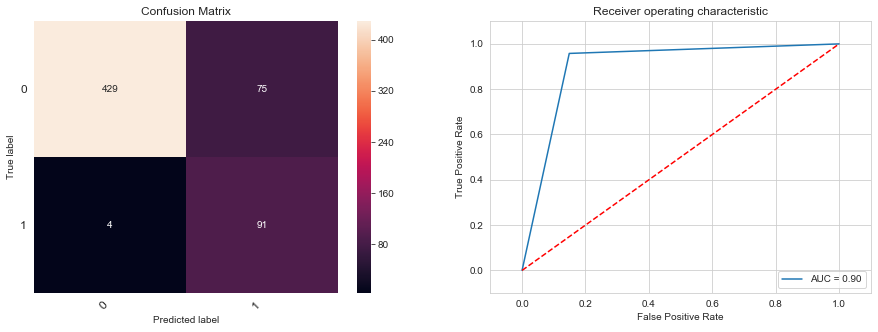

Accuracy:  0.8681135225375626
Sensitivity:  0.9578947368421052
Precision:  0.5481927710843374
f1 Score:  0.6973180076628352
ROC_AUC_Score: 0.9045426065162907
MCC:  0.6603487235391459


In [135]:
bc = BaggingClassifier(DT,bootstrap = False, n_estimators =10 ,random_state=1234)
bc.fit(sm_X_train, sm_y_train)
y_pred_bc = bc.predict(X_test_scaled[top5_feats].values)
cm = confusion_matrix(y_test, y_pred_bc)
cm_and_roc(cm, [0, 1], y_test, y_pred_bc, figsize = (15,5), fontsize=12)

print ("Accuracy: ", accuracy_score(y_test, y_pred_bc))
print("Sensitivity: ", recall_score(y_test, y_pred_bc))
print("Precision: ", precision_score(y_test, y_pred_bc))
print ("f1 Score: ", f1_score(y_test, y_pred_bc))
print("ROC_AUC_Score:", roc_auc_score(y_test, y_pred_bc))
print("MCC: ", matthews_corrcoef(y_test, y_pred_bc))

##### Tuning Attempt 2 (Use Attempt 1 to scope Parameter Range)
- Cross Validation and Test Results

In [136]:
bagging_param_space2 = {"bootstrap": hp.choice("bootstrap", [False,True]),
                      "n_estimators" : hp.choice("n_estimators", [3,4,5,10,15,20,50,100]),
                      "n_jobs":hp.choice("n_jobs", [3]),
                      "base_estimator":hp.choice("base_estimator", [DT])}

bayes_opt(BaggingClassifier,bagging_param_space2,X_train_scaled[top5_feats].values, y_train.values,"f1")

100%|██████████| 100/100 [00:23<00:00,  4.30it/s, best loss: -0.7124194908742785]

##### Results
Score best parameters:  0.7124194908742785
Best parameters:  {'base_estimator': 0, 'bootstrap': 0, 'n_estimators': 2, 'n_jobs': 0}


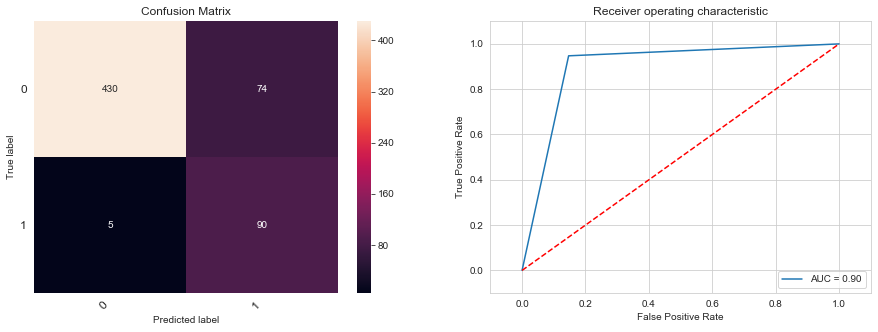

Accuracy:  0.8681135225375626
Sensitivity:  0.9473684210526315
Precision:  0.5487804878048781
f1 Score:  0.694980694980695
ROC_AUC_Score: 0.9002715121136173
MCC:  0.6558359149875671


In [137]:
bc = BaggingClassifier(DT,bootstrap = False, n_estimators =5 ,random_state=1234)
bc.fit(sm_X_train, sm_y_train)
y_pred_bc = bc.predict(X_test_scaled[top5_feats].values)
cm = confusion_matrix(y_test, y_pred_bc)
cm_and_roc(cm, [0, 1], y_test, y_pred_bc, figsize = (15,5), fontsize=12)

print ("Accuracy: ", accuracy_score(y_test, y_pred_bc))
print("Sensitivity: ", recall_score(y_test, y_pred_bc))
print("Precision: ", precision_score(y_test, y_pred_bc))
print ("f1 Score: ", f1_score(y_test, y_pred_bc))
print("ROC_AUC_Score:", roc_auc_score(y_test, y_pred_bc))
print("MCC: ", matthews_corrcoef(y_test, y_pred_bc))

### LightGBM

#### Define Parameters and Parameter Range

In [138]:
params_dic = {"boosting_type": np.array(["gbdt","dart","goss"]),
                                     'num_leaves': np.arange(5, 50, 1),
                    "learning_rate":np.array([0.01,0.05,0.1,0.2,0.3,0.5,1]),
                  "gamma":np.arange(1, 5, 1),
                  'subsample':np.arange(0.5, 1.0,0.1),
                  'colsample_bytree': np.arange(0.5, 1.0,0.1),
                  'reg_alpha': np.array([1e-5, 1e-2, 0.1, 1, 100]),
                  'reg_lambda':np.array([1e-5, 1e-2, 0.1, 1, 100]),
                  "max_depth": np.arange(5, 10, 1),
                  'min_child_weight': np.arange(1, 6, 1),
                  "n_estimators" : np.array([10,20,50,100,200]),
                  "min_split_gain": np.array([0.001,0.01,0.05,0.1,0.5,1]),
                  "min_child_samples":np.arange(5, 30, 5)}

classifier = lgb.LGBMClassifier(random_state=1234)
classifier_name = "lgbmclassifier"

#### Run Validation Curve
- Identify the value for each parameter that gives the best score

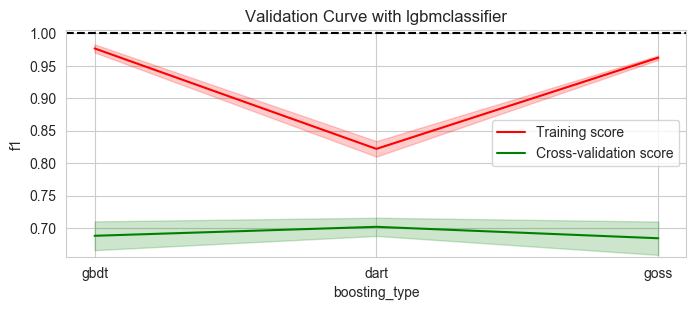

Best cross-validation result (0.70) obtained for boosting_type: dart


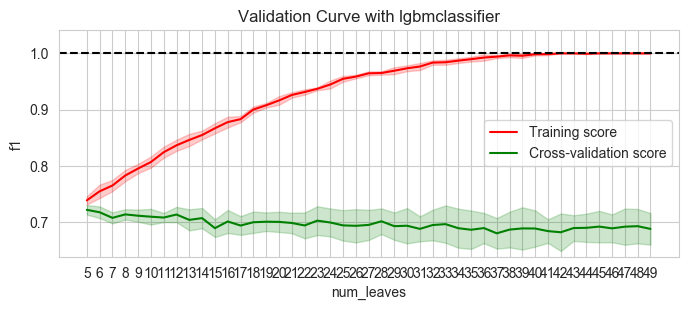

Best cross-validation result (0.72) obtained for num_leaves: 5


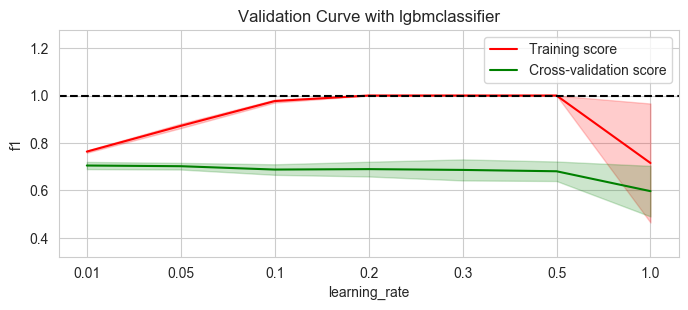

Best cross-validation result (0.71) obtained for learning_rate: 0.01


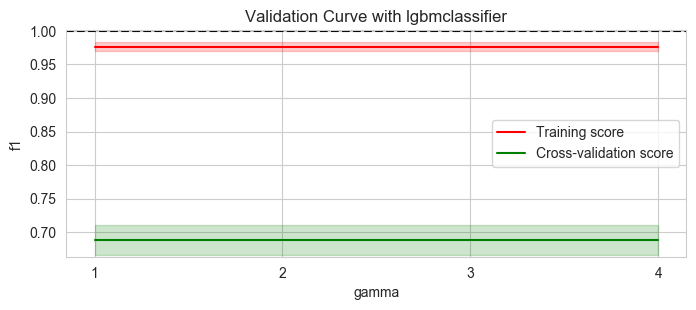

Best cross-validation result (0.69) obtained for gamma: 1


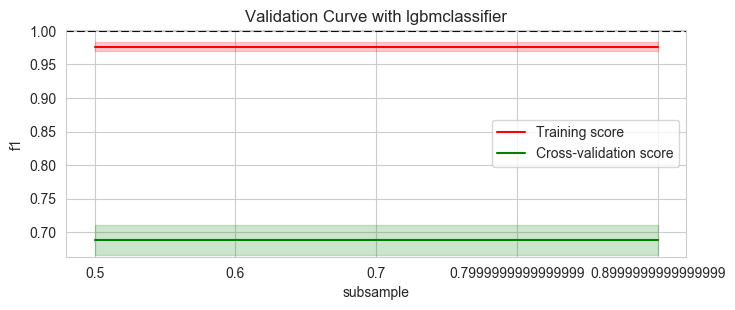

Best cross-validation result (0.69) obtained for subsample: 0.5


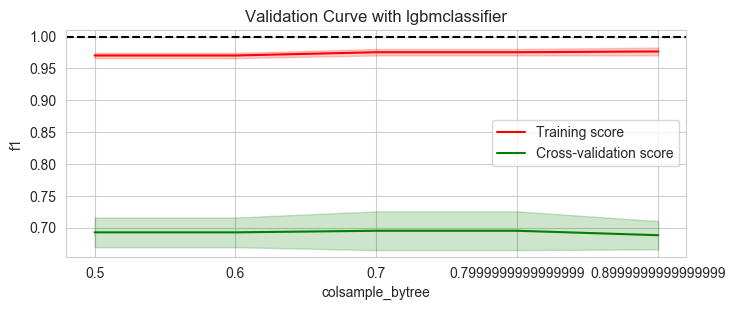

Best cross-validation result (0.70) obtained for colsample_bytree: 0.7


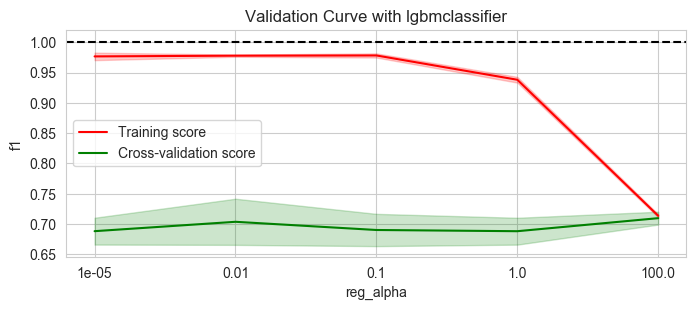

Best cross-validation result (0.71) obtained for reg_alpha: 100.0


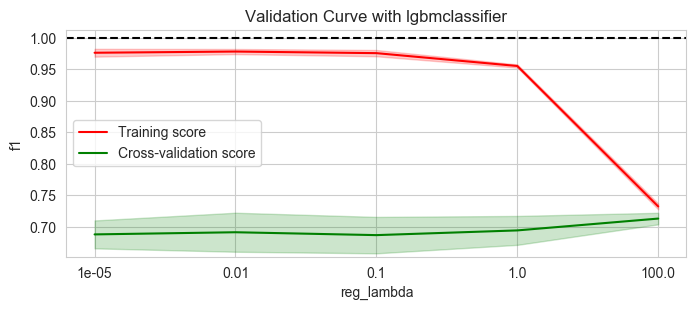

Best cross-validation result (0.71) obtained for reg_lambda: 100.0


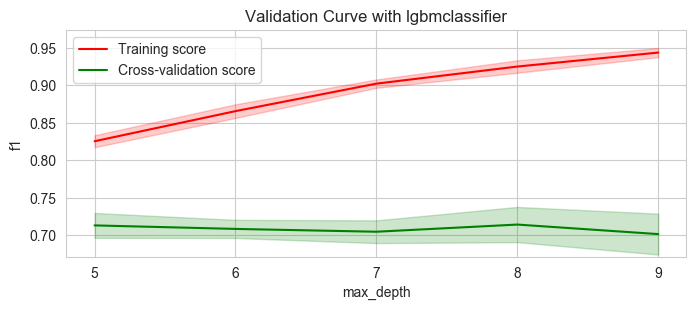

Best cross-validation result (0.71) obtained for max_depth: 8


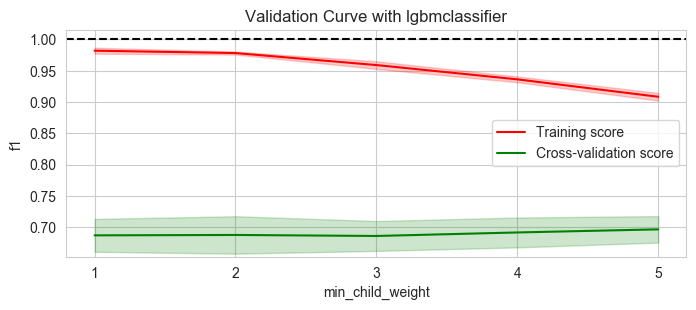

Best cross-validation result (0.70) obtained for min_child_weight: 5


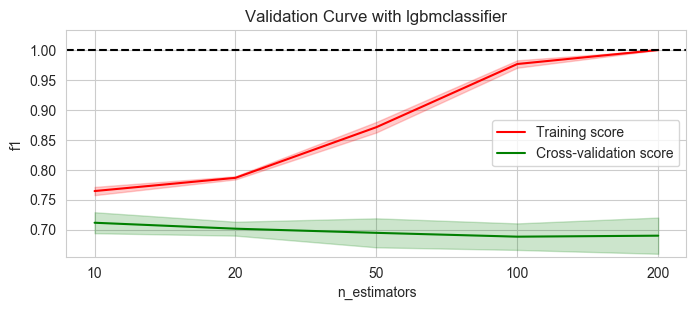

Best cross-validation result (0.71) obtained for n_estimators: 10


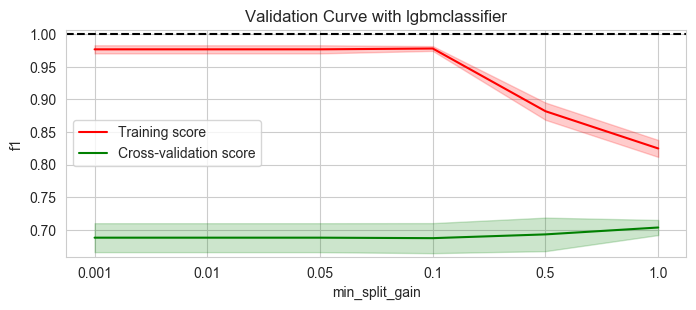

Best cross-validation result (0.70) obtained for min_split_gain: 1.0


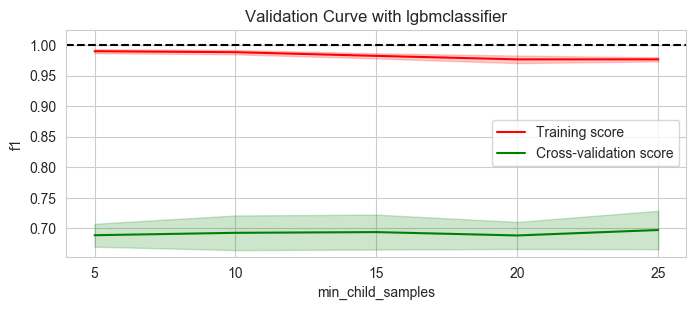

Best cross-validation result (0.70) obtained for min_child_samples: 25


In [139]:
lgb_best_params = {}
for param in params_dic:
    parameter = param
    param_range = params_dic[param]
    if param != "C":
        best_param = plot_validation_curve(classifier, classifier_name, parameter, param_range, 
                                           X_train_scaled[top5_feats].values, y_train.values, "f1","norm")
    else:
        best_param = plot_validation_curve(classifier, classifier_name, parameter, param_range, 
                                           X_train_scaled[top5_feats].values, y_train.values, "f1","log")
    
    lgb_best_params[param] = best_param

#### Run Bayesian Optimisation Tuning

##### Tuning Attempt 1 (Use Validation Curve to scope Parameter Range)
- Cross Validation and Test Results

In [140]:
lgb_param_space1 = {"boosting_type": hp.choice("boosting_type",["gbdt","dart","goss"]),
                   'num_leaves': scope.int(hp.quniform('num_leaves', 30, 50, 2)),
                    "learning_rate":hp.choice("learning_rate", [0.01,0.05,0.1,0.2,0.3]),
                  "gamma":scope.int(hp.quniform('gamma', 1, 5, 1)),
                  'colsample_bytree': hp.uniform('colsample_by_tree', 0.5, 1.0),
                  'reg_alpha': hp.choice('reg_alpha', [1e-2, 0.1, 1, 100,200,500]),
                  'reg_lambda':hp.choice('reg_lambda', [1e-2, 0.1, 1, 100,200,500]),
                  "max_depth": scope.int(hp.quniform('max_depth', 5, 10, 1)),
                  'min_child_weight': scope.int(hp.quniform('min_child_weight', 1, 7, 1)),
                  "n_estimators" : hp.choice("n_estimators", [5,10,20,50,100]),
                  "min_split_gain": hp.choice('min_split_gain',[0.01,0.05,0.1,0.5,1]),
                  "min_child_samples":scope.int(hp.quniform('min_child_samples', 5, 30, 5)),
                  "n_job":hp.choice('n_job',[3])}

bayes_opt(lgb.LGBMClassifier,lgb_param_space1,X_train_scaled[top5_feats].values, y_train.values,"f1")

100%|██████████| 100/100 [00:18<00:00,  5.33it/s, best loss: -0.7218245050501908]

##### Results
Score best parameters:  0.7218245050501908
Best parameters:  {'boosting_type': 0, 'colsample_by_tree': 0.8665295883253195, 'gamma': 2.0, 'learning_rate': 1, 'max_depth': 6.0, 'min_child_samples': 5.0, 'min_child_weight': 7.0, 'min_split_gain': 1, 'n_estimators': 2, 'n_job': 0, 'num_leaves': 40.0, 'reg_alpha': 1, 'reg_lambda': 0}


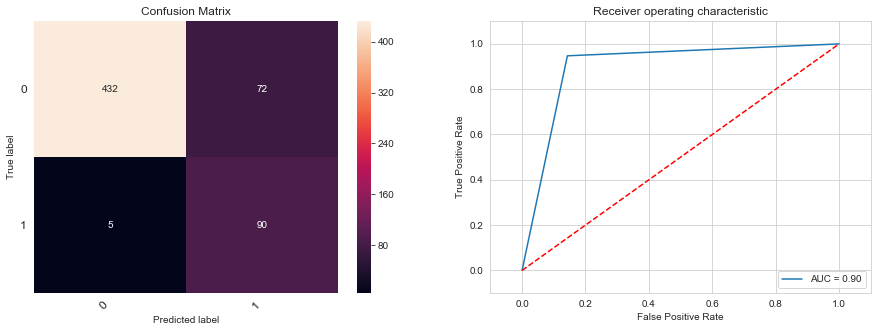

Accuracy:  0.8714524207011686
Sensitivity:  0.9473684210526315
Precision:  0.5555555555555556
f1 Score:  0.7003891050583657
ROC_AUC_Score: 0.9022556390977443
MCC:  0.6616235905524196


In [141]:
lg = LGBMClassifier(boosting_type="gbdt",colsample_by_tree = 0.854336569496965,gamma=4,learning_rate=0.05,
                        max_depth=6,min_child_samples=25,min_child_weight=6,min_split_gain=0.5,n_estimator=20,num_leaves=42,
                        n_job=3,reg_alpha=1,reg_lambda=1e-2,
                        random_state=1234)
lg.fit(sm_X_train, sm_y_train)
y_pred_lg = lg.predict(X_test_scaled[top5_feats].values)
cm = confusion_matrix(y_test, y_pred_lg)
cm_and_roc(cm, [0, 1], y_test, y_pred_lg, figsize = (15,5), fontsize=12)

print ("Accuracy: ", accuracy_score(y_test, y_pred_lg))
print("Sensitivity: ", recall_score(y_test, y_pred_lg))
print("Precision: ", precision_score(y_test, y_pred_lg))
print ("f1 Score: ", f1_score(y_test, y_pred_lg))
print("ROC_AUC_Score:", roc_auc_score(y_test, y_pred_lg))
print("MCC: ", matthews_corrcoef(y_test, y_pred_lg))

##### Tuning Attempt 2 (Use Attempt 1 to scope Parameter Range)
- Cross Validation and Test Results

In [142]:
lgb_param_space2 = {"boosting_type": hp.choice("boosting_type",["gbdt","dart","goss"]),
                   'num_leaves': scope.int(hp.quniform('num_leaves', 30, 50, 2)),
                    "learning_rate":hp.choice("learning_rate", [0.01,0.025,0.05,0.075,0.1,0.2]),
                  "gamma":scope.int(hp.quniform('gamma', 1, 5, 1)),
                  'colsample_bytree': hp.uniform('colsample_by_tree', 0.5, 1.0),
                  'reg_alpha': hp.choice('reg_alpha', [1e-05,1e-03,1e-2, 0.1, 1, 10]),
                  'reg_lambda':hp.choice('reg_lambda', [1e-05,1e-03,1e-2, 0.1, 1, 10]),
                  "max_depth": scope.int(hp.quniform('max_depth', 5, 10, 1)),
                  'min_child_weight': scope.int(hp.quniform('min_child_weight', 1, 7, 1)),
                  "n_estimators" : hp.choice("n_estimators", [10,20,40,50,100]),
                  "min_split_gain": hp.choice('min_split_gain',[0.01,0.025,0.05,0.075,0.1,0.5]),
                  "min_child_samples":scope.int(hp.quniform('min_child_samples', 10, 30, 5)),
                  "n_job":hp.choice('n_job',[3])}

bayes_opt(lgb.LGBMClassifier,lgb_param_space2,X_train_scaled[top5_feats].values, y_train.values,"f1")


100%|██████████| 100/100 [00:32<00:00,  3.06it/s, best loss: -0.7201964576778557]

##### Results
Score best parameters:  0.7201964576778557
Best parameters:  {'boosting_type': 0, 'colsample_by_tree': 0.8783440630692596, 'gamma': 5.0, 'learning_rate': 1, 'max_depth': 6.0, 'min_child_samples': 30.0, 'min_child_weight': 5.0, 'min_split_gain': 1, 'n_estimators': 2, 'n_job': 0, 'num_leaves': 40.0, 'reg_alpha': 1, 'reg_lambda': 0}


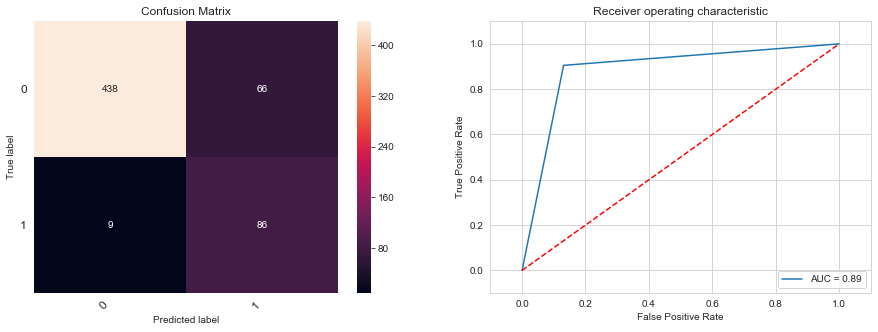

Accuracy:  0.8747913188647746
Sensitivity:  0.9052631578947369
Precision:  0.5657894736842105
f1 Score:  0.6963562753036437
ROC_AUC_Score: 0.887155388471178
MCC:  0.6500051823508064


In [143]:
lg = LGBMClassifier(boosting_type="gbdt",colsample_by_tree =0.8056846435332191,gamma=3,learning_rate=0.075,
                        max_depth=6,min_child_samples=30,min_child_weight=7,min_split_gain=0.05,n_estimator=20,num_leaves=32,
                        n_job=3,reg_alpha=1,reg_lambda=1e-05,
                        random_state=1234)
lg.fit(sm_X_train, sm_y_train)
y_pred_lg = lg.predict(X_test_scaled[top5_feats].values)
cm = confusion_matrix(y_test, y_pred_lg)
cm_and_roc(cm, [0, 1], y_test, y_pred_lg, figsize = (15,5), fontsize=12)

print ("Accuracy: ", accuracy_score(y_test, y_pred_lg))
print("Sensitivity: ", recall_score(y_test, y_pred_lg))
print("Precision: ", precision_score(y_test, y_pred_lg))
print ("f1 Score: ", f1_score(y_test, y_pred_lg))
print("ROC_AUC_Score:", roc_auc_score(y_test, y_pred_lg))
print("MCC: ", matthews_corrcoef(y_test, y_pred_lg))

##### Tuning Attempt 3 (Use Attempt 2 to scope Parameter Range)
- Cross Validation and Test Results

In [144]:
lgb_param_space3 = {"boosting_type": hp.choice("boosting_type",["gbdt","dart","goss"]),
                   'num_leaves': scope.int(hp.quniform('num_leaves', 30, 50, 2)),
                    "learning_rate":hp.choice("learning_rate", [0.01,0.025,0.05,0.075,0.1,0.2]),
                  "gamma":scope.int(hp.quniform('gamma', 1, 5, 1)),
                  'colsample_bytree': hp.uniform('colsample_by_tree', 0.5, 1.0),
                  'reg_alpha': hp.choice('reg_alpha', [1e-2, 0.1, 1, 10]),
                  'reg_lambda':hp.choice('reg_lambda', [0,1e-05,1e-03,1e-2, 0.1, 1]),
                  "max_depth": scope.int(hp.quniform('max_depth', 5, 10, 1)),
                  'min_child_weight': scope.int(hp.quniform('min_child_weight', 1, 7, 1)),
                  "n_estimators" : hp.choice("n_estimators", [15,20,25,30,40]),
                  "min_split_gain": hp.choice('min_split_gain',[0.01,0.025,0.05,0.075,0.1,0.5]),
                  "min_child_samples":scope.int(hp.quniform('min_child_samples', 10, 30, 5)),
                  "n_job":hp.choice('n_job',[3])}

bayes_opt(lgb.LGBMClassifier,lgb_param_space3,X_train_scaled[top5_feats].values, y_train.values,"f1")

100%|██████████| 100/100 [00:21<00:00,  4.62it/s, best loss: -0.7215889323579472]

##### Results
Score best parameters:  0.7215889323579472
Best parameters:  {'boosting_type': 2, 'colsample_by_tree': 0.8646238183396758, 'gamma': 5.0, 'learning_rate': 3, 'max_depth': 8.0, 'min_child_samples': 20.0, 'min_child_weight': 7.0, 'min_split_gain': 0, 'n_estimators': 0, 'n_job': 0, 'num_leaves': 36.0, 'reg_alpha': 2, 'reg_lambda': 4}


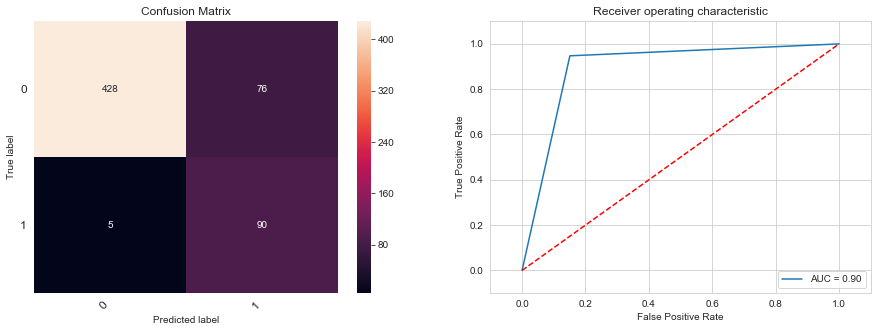

Accuracy:  0.8647746243739566
Sensitivity:  0.9473684210526315
Precision:  0.5421686746987951
f1 Score:  0.6896551724137931
ROC_AUC_Score: 0.8982873851294902
MCC:  0.6501381118713189


In [145]:
lg = LGBMClassifier(boosting_type="dart",colsample_by_tree =0.8591725014391239,gamma=2,learning_rate=0.075,
                        max_depth=6,min_child_samples=30,min_child_weight=2,min_split_gain=0.5,n_estimator=20,num_leaves=30,
                        n_job=3,reg_alpha=1e-2,reg_lambda=1,
                        random_state=1234)
lg.fit(sm_X_train, sm_y_train)
y_pred_lg = lg.predict(X_test_scaled[top5_feats].values)
cm = confusion_matrix(y_test, y_pred_lg)
cm_and_roc(cm, [0, 1], y_test, y_pred_lg, figsize = (15,5), fontsize=12)

print ("Accuracy: ", accuracy_score(y_test, y_pred_lg))
print("Sensitivity: ", recall_score(y_test, y_pred_lg))
print("Precision: ", precision_score(y_test, y_pred_lg))
print ("f1 Score: ", f1_score(y_test, y_pred_lg))
print("ROC_AUC_Score:", roc_auc_score(y_test, y_pred_lg))
print("MCC: ", matthews_corrcoef(y_test, y_pred_lg))

## 11. Stacking

### 5 Best Models for First Layer
- Random Forest
- XGBoost
- Decision Tree
- Bagging
- LightGBM

### Second Layer
- XGBoost

In [147]:
# Class to extend the Sklearn classifier
class SklearnHelper(object):
    def __init__(self, clf, seed=1234, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def predict_proba(self, x):
        return self.clf.predict_proba(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
        print(self.clf.fit(x,y).feature_importances_)


### Cross Validation with SMOTE Pipeline Function
This function is a modification of the cross validation that enables only the training set in each fold to undergo Oversampling (SMOTE) to address the unbalanced training set in each fold. This is to ensure that there is no information lekage from the validation set to training set in each fold. 

In [157]:
# from imblearn.pipeline import make_pipeline as make_pipeline_imb, Pipeline
def get_oof(classifier, X_train, y_train, X_test, ntrain, ntest):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((5, ntest))
    
    skf = StratifiedKFold(n_splits=5,random_state=1234)
    
    for i, (train_index, test_index) in enumerate(skf.split(X_train, y_train)):
        
        # train-test split in each fold
        X_train_cv, X_test_cv = X_train[train_index], X_train[test_index]
        y_train_cv, y_test_cv = y_train[train_index], y_train[test_index]
        
        # SMOTE oversampling on the training set of the fold 
        pipeline = make_pipeline_imb(SMOTE(random_state = 1234), classifier)
        model = pipeline.fit(X_train_cv, y_train_cv)
        
        oof_train[test_index] = model.predict(X_test_cv)
        oof_test_skf[i, :] = model.predict(X_test)
        
    oof_test[:] = oof_test_skf.mean(axis=0)
    
    return oof_train.reshape(-1,1), oof_test.reshape(-1,1)
    

### 11. 1 Building the First Layer

In [158]:
# Random Forest parameters - CV: 71.63% Test: 67.76%
rf_params = {
    'bootstrap':True,
    'criterion':'gini',
    'max_depth':10,
    'max_features':5,
    'min_samples_leaf':10,
    'min_samples_split':40,
    'n_estimators':210,
    'random_state':1234,
}

In [159]:
# Extreme Gradient Boosting parameters - CV: 71.99%  Test: 68.06%
xgb_params = {
    'colsample_by_tree': 0.7465937617317032, 
    'gamma': 7.0, 
    'learning_rate': 0.4, 
    'max_depth': 6, 
    'min_child_weight': 24, 
    'n_estimators': 200, 
    'reg_alpha': 1.5, 
    'reg_lambda': 1, 
    'subsample': 0.7069236585610036,
    'random_state': 1234
}

In [160]:
# DT parameters - CV: 72.06% Test: 68.29%
dt_params = {
    'criterion': 'gini', 
    'max_depth': 11, 
    'max_features': 3, 
    'min_impurity_decrease': 1e-07, 
    'min_samples_leaf': 20, 
    'min_samples_split': 80,
    'random_state' :1234
}

In [161]:
# Bagging parameters - CV: 71.24% Test: 71.35%
bag_params = { 
    'base_estimator':DecisionTreeClassifier(criterion="gini",
                            max_depth=11,
                            max_features=3,
                            min_impurity_decrease=1e-07,
                            min_samples_leaf=20,
                            min_samples_split=80,
                            random_state=1234),
    'bootstrap': False, 
    'n_estimators': 5,
    'random_state' :1234
}

In [162]:
# lgb Parameters - CV: 72.1% Test: 69.27%
lgb_params = {
    'boosting_type': 'gbdt', 
    'colsample_by_tree': 0.8309554549705769, 
    'gamma': 5.0, 
    'learning_rate': 0.05, 
    'max_depth': 6, 
    'min_child_samples': 25, 
    'min_child_weight': 6, 
    'min_split_gain': 0.5, 
    'n_estimators': 20, 
    'num_leaves': 42, 
    'reg_alpha': 1, 
    'reg_lambda': 1e-02,
    'random_state' :1234,
    'n_jobs':3
}

In [163]:
# Create 5 objects that represent our 4 models
rf = SklearnHelper(clf=RandomForestClassifier, seed=1234, params=rf_params)
xgb = SklearnHelper(clf=XGBClassifier, seed=1234, params=xgb_params)
dt = SklearnHelper(clf=DecisionTreeClassifier, seed=1234, params=dt_params)
bag = SklearnHelper(clf=BaggingClassifier, seed=1234, params=bag_params)
lgb = SklearnHelper(clf=LGBMClassifier, seed=1234, params=lgb_params)

In [164]:
ntrain = len(X_train_scaled)
ntest = len(X_test_scaled)

In [165]:
# Create our OOF train and test predictions. These base results will be used as new features
rf_oof_train, rf_oof_test = get_oof(rf, X_train_scaled.values, y_train.values, X_test_scaled.values, ntrain, ntest) # Random Forest


In [166]:
xgb_oof_train, xgb_oof_test = get_oof(xgb, X_train_scaled.values, y_train.values, X_test_scaled.values, ntrain, ntest) # AdaBoost 


In [167]:
dt_oof_train, dt_oof_test = get_oof(dt, X_train_scaled.values, y_train.values, X_test_scaled.values, ntrain, ntest) # Gradient Boost


In [168]:
bag_oof_train, bag_oof_test = get_oof(bag, X_train_scaled.values, y_train.values, X_test_scaled.values, ntrain, ntest) # log reg Classifier


In [169]:
lgb_oof_train, lgb_oof_test = get_oof(lgb, X_train_scaled.values, y_train.values, X_test_scaled.values, ntrain, ntest) # log reg Classifier
print("Training is complete")



Training is complete


In [170]:
final_X_train = np.concatenate((rf_oof_train, xgb_oof_train, dt_oof_train, bag_oof_train, lgb_oof_train), axis=1)
final_X_test = np.concatenate((rf_oof_test, xgb_oof_test, dt_oof_test, bag_oof_test, lgb_oof_test), axis=1)

In [171]:
# SMOTE oversample the final_X_train
# Address the Unbalanced Training Set by Oversampling SMOTE
sm = SMOTE(random_state=1234)
sm_final_X_train, sm_final_y_train = sm.fit_sample(final_X_train, y_train.ravel())

### 11.2 Building the Second Layer

### Second Level - XGBoost

In [172]:
params_dic = {
    "learning_rate": np.array([0.01,0.05,0.1,0.2,0.3,0.5,1]),
    "gamma": np.arange(1,6,1),
    "subsample": np.arange(0.5, 1.01, 0.1),
    "colsample_bytree": np.arange(0.5, 1.01, 0.1),
    "reg_alpha": np.array([1e-5, 1e-2, 0.1, 1, 100]),
    "reg_lambda": np.array([1e-5, 1e-2, 0.1, 1, 100]),
    "max_depth": np.arange(5,11,1),
    "min_child_weight": np.arange(4,21,1),
    "n_estimators": np.array([10,20,50,100,200])
}

In [173]:
classifier = XGBClassifier(random_state=1234)
classifier_name = "xgbclassifier"

#### Run Validation Curve 
- identify the value of parameter that gives the best score

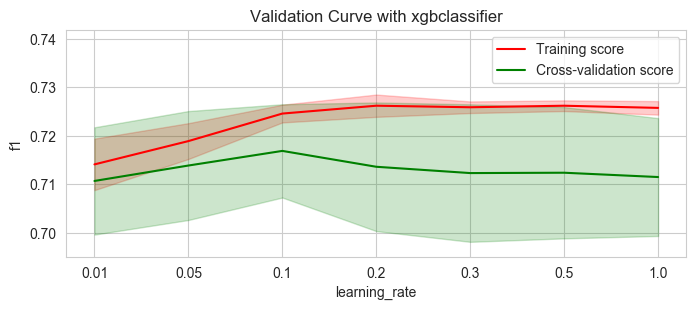

Best cross-validation result (0.72) obtained for learning_rate: 0.1


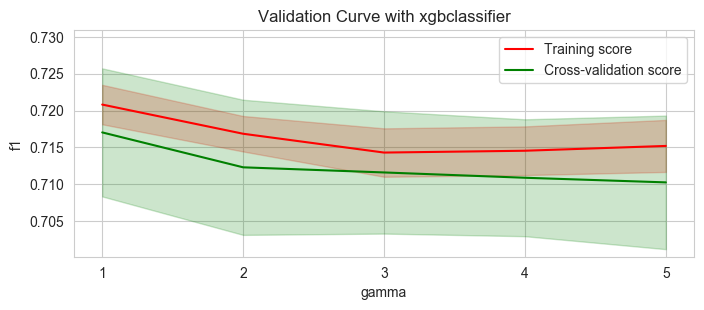

Best cross-validation result (0.72) obtained for gamma: 1


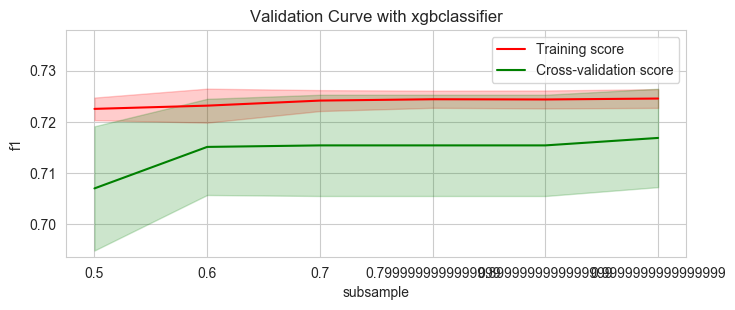

Best cross-validation result (0.72) obtained for subsample: 0.9999999999999999


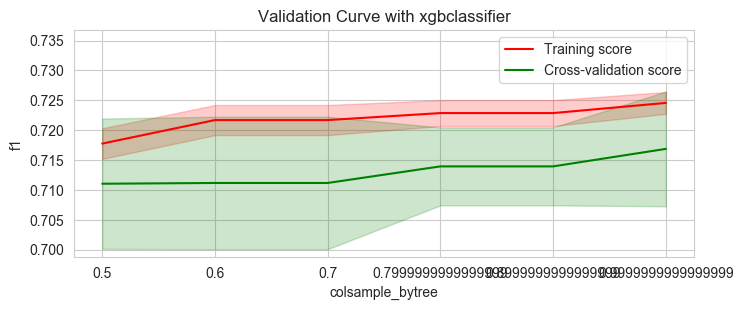

Best cross-validation result (0.72) obtained for colsample_bytree: 0.9999999999999999


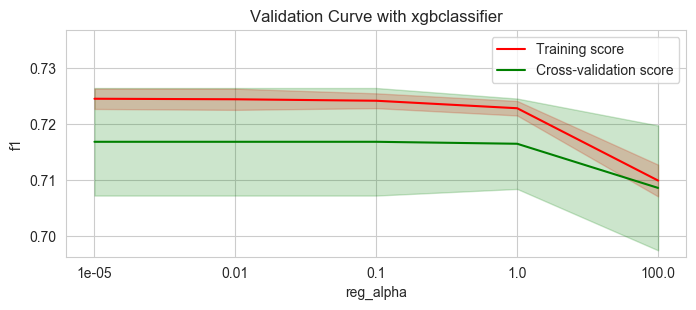

Best cross-validation result (0.72) obtained for reg_alpha: 1e-05


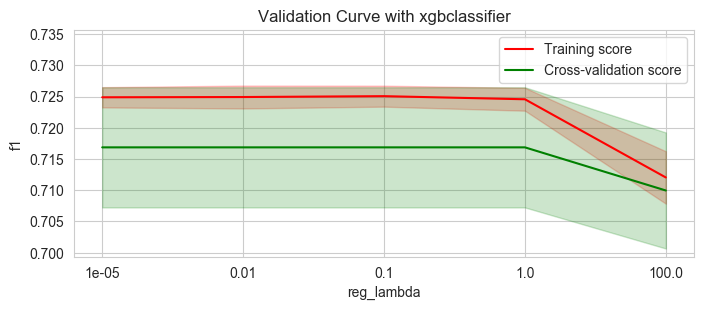

Best cross-validation result (0.72) obtained for reg_lambda: 1e-05


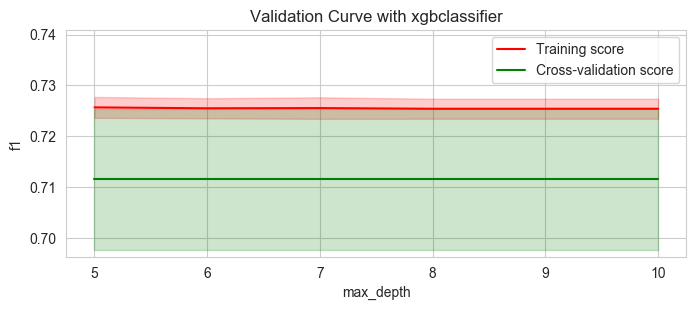

Best cross-validation result (0.71) obtained for max_depth: 5


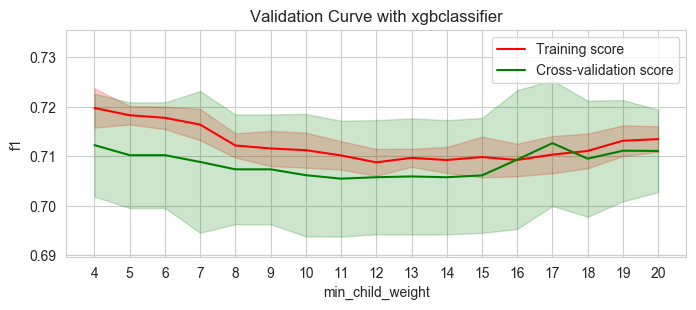

Best cross-validation result (0.71) obtained for min_child_weight: 17


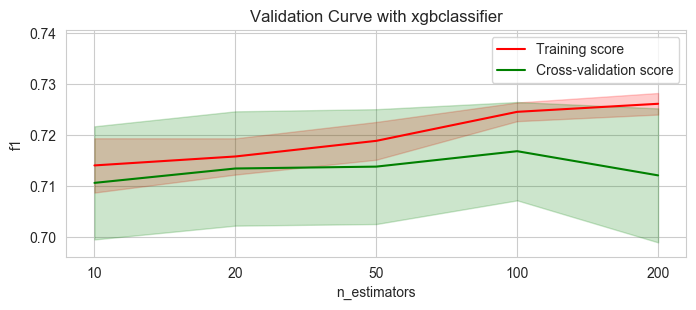

Best cross-validation result (0.72) obtained for n_estimators: 100


In [174]:
xgb_best_params = {}
for param in params_dic:
    parameter = param
    param_range = params_dic[param]
    if param != "C":
        best_param = plot_validation_curve(classifier, classifier_name, parameter, param_range, 
                                           final_X_train, y_train.values, "f1","norm")
    else:
        best_param = plot_validation_curve(classifier, classifier_name, parameter, param_range, 
                                           final_X_train, y_train.values, "f1","log")
    
    xgb_best_params[param] = best_param

#### Run Bayesian Optimisation Tuning

##### Tuning Attempt 1 (Use Validation Curve to scope parameter range)
- Cross Validation and Test Results

In [175]:
xgb_best_params

{'learning_rate': 0.1,
 'gamma': 1,
 'subsample': 0.9999999999999999,
 'colsample_bytree': 0.9999999999999999,
 'reg_alpha': 1e-05,
 'reg_lambda': 1e-05,
 'max_depth': 5,
 'min_child_weight': 17,
 'n_estimators': 100}

In [177]:
xgb_param_space1 = {"learning_rate": hp.choice("learning_rate", [0.05, 0.07, 0.1, 0.15, 0.2]),
                   "min_child_weight": scope.int(hp.quniform("min_child_weight", 10,20,1)),
                   "gamma": scope.int(hp.quniform("gamma", 0,4,1)),
                   "subsample": hp.uniform("subsample", 0.6, 1.0),
                   "colsample_bytree": hp.uniform("colsample_by_tree", 0.4, 1),
                   "reg_alpha": hp.choice("reg_alpha", [1e-5, 0.1, 1, 100]),
                   "reg_lambda": hp.choice("reg_lambda", [1e-5, 1e-2, 0.1]),
                   "max_depth": scope.int(hp.quniform("max_depth", 1, 10, 1)),
                   "n_estimators": hp.choice("n_estimators", [50, 75, 100, 150, 200])
                  }
bayes_opt(XGBClassifier, xgb_param_space1, final_X_train, y_train.values, "f1")

100%|██████████| 100/100 [00:48<00:00,  2.08it/s, best loss: -0.7174758655534326]

##### Results
Score best parameters:  0.7174758655534326
Best parameters:  {'colsample_by_tree': 0.6209505599689564, 'gamma': 1.0, 'learning_rate': 4, 'max_depth': 8.0, 'min_child_weight': 16.0, 'n_estimators': 2, 'reg_alpha': 2, 'reg_lambda': 1, 'subsample': 0.6741648759414965}


In [178]:
xgb_model = XGBClassifier(random_state=1234,
                          colsample_bytree=0.6209505599689564,
                          gamma=1,
                          learning_rate=0.2,
                          max_depth=8,
                          min_child_weight=16,
                          n_estimators=100,
                          reg_alpha=1,
                          reg_lambda=1e-2,
                          subsample=0.6741648759414965
                         )

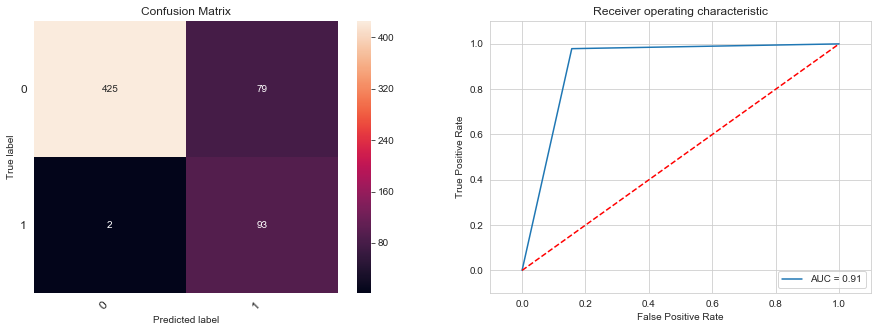

Accuracy:  0.8647746243739566
Sensitivity:  0.9789473684210527
Precision:  0.5406976744186046
f1 Score:  0.696629213483146
ROC_AUC_Score: 0.9111006683375104
MCC:  0.6638608969649519


In [179]:
xgb_model.fit(sm_final_X_train, sm_final_y_train)
y_pred_xgb = xgb_model.predict(final_X_test)
cm = confusion_matrix(y_test, y_pred_xgb)
cm_and_roc(cm, [0, 1], y_test, y_pred_xgb, figsize = (15,5), fontsize=12)

print ("Accuracy: ", accuracy_score(y_test, y_pred_xgb))
print("Sensitivity: ", recall_score(y_test, y_pred_xgb))
print("Precision: ", precision_score(y_test, y_pred_xgb))
print ("f1 Score: ", f1_score(y_test, y_pred_xgb))
print("ROC_AUC_Score:", roc_auc_score(y_test, y_pred_xgb))
print("MCC: ", matthews_corrcoef(y_test, y_pred_xgb))

##### Tuning Attempt 2 (Use Attempt 1 to scope Parameter Range)
- Cross Validation and Test Results

In [180]:
xgb_param_space2 = {"learning_rate": hp.choice("learning_rate", [0.2, 0.25, 0.3, 0.35, 0.4]),
                   "min_child_weight": scope.int(hp.quniform("min_child_weight", 16,25,1)),
                   "gamma": scope.int(hp.quniform("gamma", 0,4,1)),
                   "subsample": hp.uniform("subsample", 0.3, 0.7),
                   "colsample_bytree": hp.uniform("colsample_by_tree", 0.4, 1),
                   "reg_alpha": hp.choice("reg_alpha", [1e-5, 0.1, 0.5, 1, 1.5, 2]),
                   "reg_lambda": hp.choice("reg_lambda", [1e-5, 1e-2, 0.1]),
                   "max_depth": scope.int(hp.quniform("max_depth", 8, 20, 1)),
                   "n_estimators": hp.choice("n_estimators", [50, 75, 100, 150, 200])
                  }
bayes_opt(XGBClassifier, xgb_param_space2, final_X_train, y_train.values, "f1")

100%|██████████| 100/100 [00:50<00:00,  1.99it/s, best loss: -0.7180392306651678]

##### Results
Score best parameters:  0.7180392306651678
Best parameters:  {'colsample_by_tree': 0.7891506999960809, 'gamma': 1.0, 'learning_rate': 0, 'max_depth': 16.0, 'min_child_weight': 19.0, 'n_estimators': 3, 'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 0.456421525369848}


In [181]:
xgb_model = XGBClassifier(random_state=1234,
                          colsample_bytree=0.7891506999960809,
                          gamma=1,
                          learning_rate=0.2,
                          max_depth=16,
                          min_child_weight=19,
                          n_estimators=150,
                          reg_alpha=0.1,
                          reg_lambda=1e-2,
                          subsample=0.456421525369848
                         )

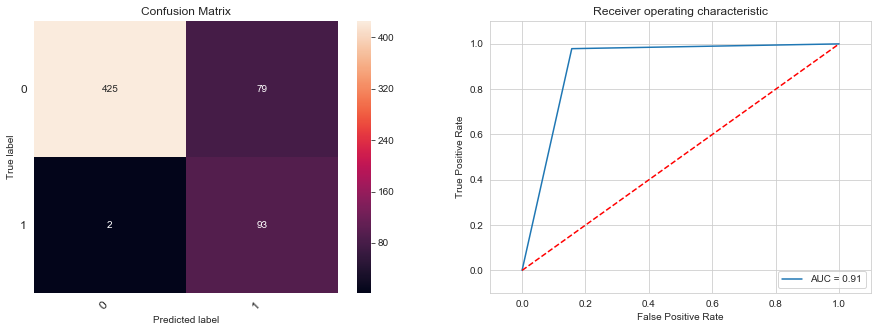

Accuracy:  0.8647746243739566
Sensitivity:  0.9789473684210527
Precision:  0.5406976744186046
f1 Score:  0.696629213483146
ROC_AUC_Score: 0.9111006683375104
MCC:  0.6638608969649519


In [182]:
xgb_model.fit(sm_final_X_train, sm_final_y_train)
y_pred_xgb = xgb_model.predict(final_X_test)
cm = confusion_matrix(y_test, y_pred_xgb)
cm_and_roc(cm, [0, 1], y_test, y_pred_xgb, figsize = (15,5), fontsize=12)

print ("Accuracy: ", accuracy_score(y_test, y_pred_xgb))
print("Sensitivity: ", recall_score(y_test, y_pred_xgb))
print("Precision: ", precision_score(y_test, y_pred_xgb))
print ("f1 Score: ", f1_score(y_test, y_pred_xgb))
print("ROC_AUC_Score:", roc_auc_score(y_test, y_pred_xgb))
print("MCC: ", matthews_corrcoef(y_test, y_pred_xgb))